# Exploratory Data Analysis (EDA) of the **CBIS-DDSM** Dataset
In this section, we conduct an exploratory data analysis of the CBIS-DDSM Case and DICOM datasets prepared in prior sections. The purpose of this EDA is three-fold:
1. Discover the relationships among the features
2. Explore the nature of the relationships between the features and the diagnostic target.
3. Assess image quality and properties as they pertain to image preprocessing. 

## The Datasets
This analysis will involve the following datasets:
- Case Dataset: Calcification and mass datasets containing patient, abnormality, BI-RADS assessment, image image_view, breast density, subtlety, and pathology (diagnosis) information.
- DICOM Dataset: Contains image properties, i.e., image size, shape, bit-depth, aspect ratio, and photometric interpretation.
- DICOM Images: The mammography, ROI masks, and cropped images in DICOM format.


### Case Dataset Dictionary

| #  | Variable             | Type        | Description                                                                                                                  | 
|----|----------------------|-------------|------------------------------------------------------------------------------------------------------------------------------|
| 1  | patient_id           | Nominal     | Unique identifier for each patient.                                                                                          |
| 2  | breast_density       | Discrete    | BI-RADS overall assessment of the volume of attenuating tissues in the breast.                                             |
| 3  | left_or_right_breast | Nominal     | Which breast was imaged.                                                                                                     |
| 4  | image_view           | Dichotomous | Either cranialcaudal or mediolateral oblique image_view.                                                                            |
| 5  | abnormality_id       | Discrete    | Number of abnormalities for the patient.                                                                                       |
| 6  | abnormality_type     | Dichotomous | BI-RADS category of the abnormality.                                                                                         | 
| 7  | calc_type            | Nominal     | Characterization of the type of calcification (where applicable)                                                             | 
| 8  | calc_distribution    | Nominal     | The arrangement of the calcifications inside the breast and, relative to the probability of malignancy. (where applicable) | 
| 9  | mass_shape           | Nominal     | Shape of the mass                                                                                                            |
| 10 | mass_margins         | Nominal     | Feature that separates the mass from the adjacent breast parenchyma.                                                         |
| 11 | assessment           | Discrete    | Overall BI-RADS assessment of the mammography                                                                                |
| 12 | pathology            | Nominal     | Determination of the malignancy of the case.                                                                                 |
| 13 | subtlety             | Discrete    | Degree of diagnostic difficulty                                                                                              |
| 14 | fileset              | Nominal     | Indicates training or test set.                                                                                              |
| 15 | case_id              | Nominal     | Unique identifier for the case.                                                                                              |
| 16 | cancer               | Dichotomous | Indicates whether the cancer is diagnosed.                                                                                   |

As described in the prior section, compound morphological categories for calc_type, calc_distribution, mass_shape, and mass_margins, were separated into unary categories and dummy encoded.

### DICOM Dataset Dictionary
| #  | Variable                   | Type        | Description                                                               |
|----|----------------------------|-------------|---------------------------------------------------------------------------|
| 1  | series_uid                 | Nominal     | Unique identifier for a series of images.                                 |
| 2  | filepath                   | Nominal     | The path to the image.                                                    |
| 3  | patient_id                 | Nominal     | Unique identifier for each patient.                                       |
| 4  | side                       | Nominal     | Which breast was imaged.                                                  |
| 5  | image_view                 | Dichotomous | Either cranialcaudal or mediolateral oblique image_view.                         |
| 6  | photometric_interpretation | Nominal     | Intended interpretation of the pixel data.                                |
| 7  | samples_per_pixel          | Discrete    | Number of samples (planes) in this image.                                 |
| 8  | height                     | Discrete    | Number of rows in the image.                                              |
| 9  | width                      | Discrete    | Number of columns in the image.                                           |
| 10 | size                       | Discrete    | Number of pixels in the image.                                            |
| 11 | aspect_ratio               | Continuous  | Ratio of vertical and horizontal size.                                    |
| 12 | bit_depth                       | Discrete    | Number of bit_depth stored for each pixel sample.                              |
| 13 | min_pixel_value       | Discrete    | The minimum actual pixel value encountered in the image.                  |
| 14 | largest_image_pixel        | Discrete    | The maximum actual pixel value encountered in the image.                  |
| 15 | range_pixel_values          | Discrete    | Difference between largest and smallest image pixel.                      |
| 16 | series_description         | Nominal     | Whether the series contains full mammography, ROI mask, or cropped images. |

The DICOM dataset also includes case data for each DICOM series.

## Approach
### Guiding Questions
> “Far better an approximate answer to the right question, which is often vague, than an exact answer to the wrong question, which can always be made precise.” — John Tukey

Here, we'll put forward a set of questions to motivate and guide the discovery process.

**Cases**
1. What are the relationships between calcification and mass morphological features and malignancy?
2. To what degree does breast density relate to abnormality types and malignancy?
3. Are certain abnormalities more or less subtle?
4. What are the relative features of importance concerning diagnosis?

**DICOM Metadata**
1. How are image properties such as size, aspect ratio, and shape distributed?
2. Do the images have a standard representation, in terms of bit-depth, and photometric interpretation?

**DICOM Images**
1. To what degree are artifacts (marks and texts) extant in the imaging?
2. How would image quality, brightness, and contrast be characterized in the dataset?

### Exploratory Data Analysis Plan
The EDA will be conducted in three primary stages:
1. **Case EDA**: Univariate, Bivariate and Multivariate EDA of the case data
2. **DICOM Metadata EDA**: Exploration of DICOM image properties and metadata.
3. **DICOM Image EDA**: Image Quality Analysis

**Preliminaries**
The section has the following python package dependencies:
- **Pandas**: Tabular data processing and analysis
- **Numpy**: Numerical processing
- **Matplotlib** and **Seaborn**: Data visualization
- **Scipy**: Statistical analysis
- **StudioAI**: Data visualization and statistical analysis

In [1]:
import sys
import os
if 'jbook' in os.getcwd():
    os.chdir(os.path.abspath(os.path.join("../../..")))
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
from scipy import stats
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from bcd.analyze.explore.case import CaseExplorer
from bcd.analyze.explore.dicom import DicomExplorer
from bcd.analyze.explore.multivariate.pipeline import PipelineBuilder
from bcd.analyze.explore.multivariate.selection import ModelSelector

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
sns.set_style('whitegrid')
sns.set_palette("Blues_r")

In [3]:
CASE_FP = "data/meta/3_cooked/cases.csv"
DICOM_FP = "data/meta/2_clean/dicom.csv"

In [4]:
cases = CaseExplorer(filepath=CASE_FP)
calc = CaseExplorer(df=cases.get_calc_data())
mass = CaseExplorer(df=cases.get_mass_data())

## Case EDA
This stage will comprise univariate, bivariate, and multivariate analyses of the case data.
### Case Univariate Analysis
Let's get an overall sense of the data.

In [5]:
summary = cases.summary()
summary

Summary
Patients                            1566
Cases                               3566
Calcification Cases                 1872
Calcification Cases - Benign        1199
Calcification Cases - Malignant      673
Mass Cases                          1694
Mass Cases - Benign                  910
Mass Cases - Malignant               784

In [6]:
st = summary.T
pct_calc = round(st['Calcification Cases'] / st['Cases'] * 100,2).values[0]
pct_mass = round(st['Mass Cases'] / st['Cases'] * 100,2).values[0]
pct_calc_mal = round(st['Calcification Cases - Malignant'] / st['Calcification Cases'] * 100,2).values[0]
pct_calc_bn = round(st['Calcification Cases - Benign'] / st['Calcification Cases'] * 100,2).values[0]
pct_mass_mal = round(st['Mass Cases - Malignant'] / st['Mass Cases'] * 100,2).values[0]
pct_mass_bn = round(st['Mass Cases - Benign'] / st['Mass Cases'] * 100,2).values[0]
cases_per_patient = round(st['Cases'] / st['Patients'],2).values[0]
msg = f"Key Observations\n"
msg += f"1.\tThe number of patients, {st['Patients'].values[0]} comports with the TCIA data description.\n"
msg += f"2.\tWe have {st['Cases'].values[0]} cases, {pct_calc}% are calcification cases and {pct_mass}% are mass cases.\n"
msg += f"3.\tOf the calcification cases, {pct_calc_bn}% are benign, {pct_calc_mal} or malignant.\n"
msg += f"4.\tOf the mass cases, {pct_mass_bn}% are benign, {pct_mass_mal} or malignant.\n"
msg += f"5\tOn average we have approximately {cases_per_patient} cases per patient."
print(msg)

Key Observations
1.	The number of patients, 1566 comports with the TCIA data description.
2.	We have 3566 cases, 52.5% are calcification cases and 47.5% are mass cases.
3.	Of the calcification cases, 64.05% are benign, 35.95 or malignant.
4.	Of the mass cases, 53.72% are benign, 46.28 or malignant.
5	On average we have approximately 2.28 cases per patient.


Let's take a look at the calcification and mass data.

In [7]:
cases.get_calc_data().sample(5)
cases.get_mass_data().sample(5)

case_id patient_id  breast_density  \
164   Calcification-Train_P_00232_RIGHT_MLO_1    P_00232               4   
976    Calcification-Train_P_01274_LEFT_MLO_2    P_01274               2   
1307    Calcification-Train_P_01705_LEFT_CC_1    P_01705               4   
261     Calcification-Train_P_00385_LEFT_CC_2    P_00385               2   
339    Calcification-Train_P_00471_LEFT_MLO_2    P_00471               3   

     left_or_right_breast image_view  abnormality_id  \
164                 RIGHT        MLO               1   
976                  LEFT        MLO               2   
1307                 LEFT         CC               1   
261                  LEFT         CC               2   
339                  LEFT        MLO               2   

                            calc_type calc_distribution  assessment  \
164                          PUNCTATE         CLUSTERED           4   
976                          VASCULAR         SEGMENTAL           2   
1307                         PUNCTATE            LINEAR           4   
261   VASCULAR-COARSE-LUCENT_CENTERED         SEGMENTAL           2   
339                   VASCULAR-COARSE         SEGMENTAL           2   

                    pathology  subtlety fileset  cancer  
164                 MALIGNANT         1   train    True  
976   BENIGN_WITHOUT_CALLBACK         5   train   False  
1307                   BENIGN         1   train   False  
261   BENIGN_WITHOUT_CALLBACK         5   train   False  
339   BENIGN_WITHOUT_CALLBACK         3   train   False

case_id patient_id  breast_density  \
2728    Mass-Train_P_01231_LEFT_CC_1    P_01231               1   
1938    Mass-Train_P_00092_LEFT_CC_1    P_00092               2   
2381   Mass-Train_P_00730_RIGHT_CC_1    P_00730               3   
2122  Mass-Train_P_00370_RIGHT_MLO_1    P_00370               2   
2181   Mass-Train_P_00432_LEFT_MLO_1    P_00432               1   

     left_or_right_breast image_view  abnormality_id  \
2728                 LEFT         CC               1   
1938                 LEFT         CC               1   
2381                RIGHT         CC               1   
2122                RIGHT        MLO               1   
2181                 LEFT        MLO               1   

                    mass_shape    mass_margins  assessment  \
2728  ASYMMETRIC_BREAST_TISSUE      SPICULATED           3   
1938                      OVAL   CIRCUMSCRIBED           4   
2381                 LOBULATED  MICROLOBULATED           4   
2122                 IRREGULAR     ILL_DEFINED           4   
2181                 IRREGULAR      SPICULATED           4   

                    pathology  subtlety fileset  cancer  
2728  BENIGN_WITHOUT_CALLBACK         4   train   False  
1938                MALIGNANT         5   train    True  
2381                MALIGNANT         1   train    True  
2122                MALIGNANT         1   train    True  
2181                MALIGNANT         3   train    True

Our univariate analysis will cover:
- Breast Density
- Left or Right Breast
- Image View
- Abnormality Id
- Abnormality Type
- Subtlety
- BI-RADS Assessment
- Calcification Type
- Calcification Distribution
- Mass Shape
- Mass Margins
- Pathology
- Cancer (Target)

#### Breast Density
Radiologists classify breast density using a 4-level density scale {cite}`BreastImagingReporting`:

1. Almost entirely fatty
2. Scattered areas of fibroglandular density
3. Heterogeneously dense
4. Extremely dense

Note: the corresponding BI-RADS breast density categories are a, b, c, and d (not 1,2,3, and 4 as listed above) so as not to be confused with the BI-RADS assessment categories. Notwithstanding, CBIS-DDSM data encodes these values as ordinal numeric variables.   The following chart illustrates the distribution of BI-RADS breast density categories within the CBIS-DDSM.

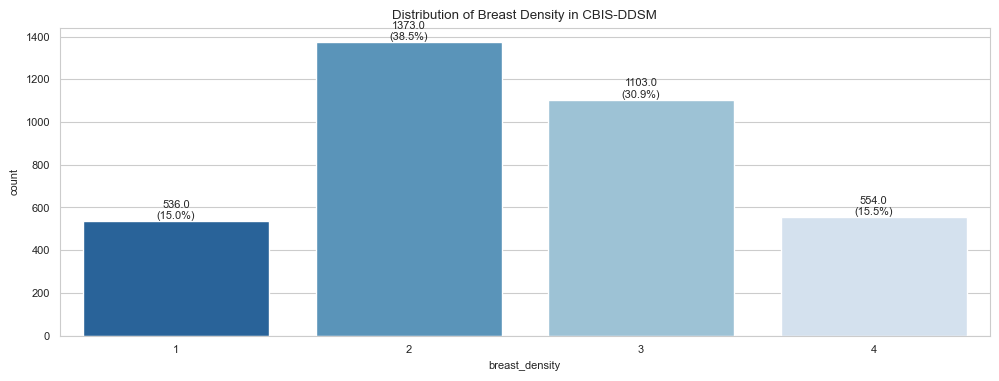

In [8]:
fig, ax = plt.subplots(figsize=(12,4))
cases.plot.countplot(x='breast_density', ax=ax, title ="Distribution of Breast Density in CBIS-DDSM", plot_counts=True)

#### Left or Right Side

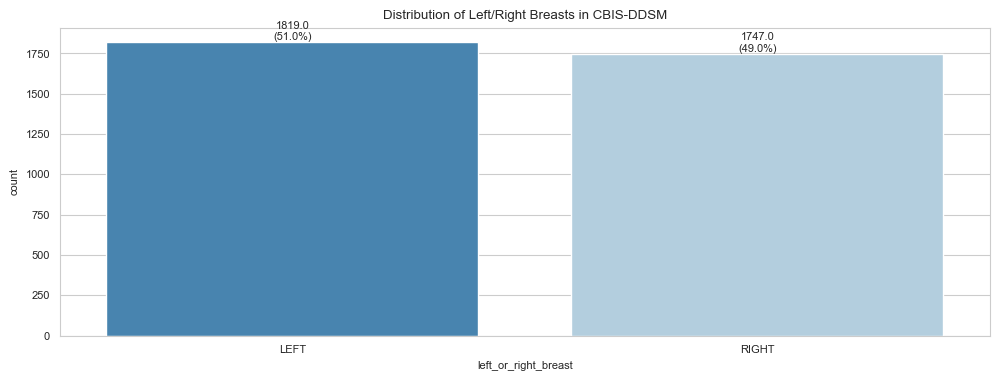

In [9]:
fig, ax = plt.subplots(figsize=(12,4))
cases.plot.countplot(x='left_or_right_breast', ax=ax, title ="Distribution of Left/Right Breasts in CBIS-DDSM", plot_counts=True)

The dataset is approximately balanced with respect to left or right breast images.

#### Image View
CBIS-DDSM contains digital mammography images in two different image_views: cranial-caudal (CC) and mediolateral oblique (MLO). The CC image_view is taken from above the breast, and best visualizes the subarcolar, central, medial, and posteromedial aspects of the breast. The MLO projection (side-image_view) images the breast in its entirety and best visualizes the posterior and upper-outer quadrants of the breast {cite}`lilleMammographicImagingPractical2019`.

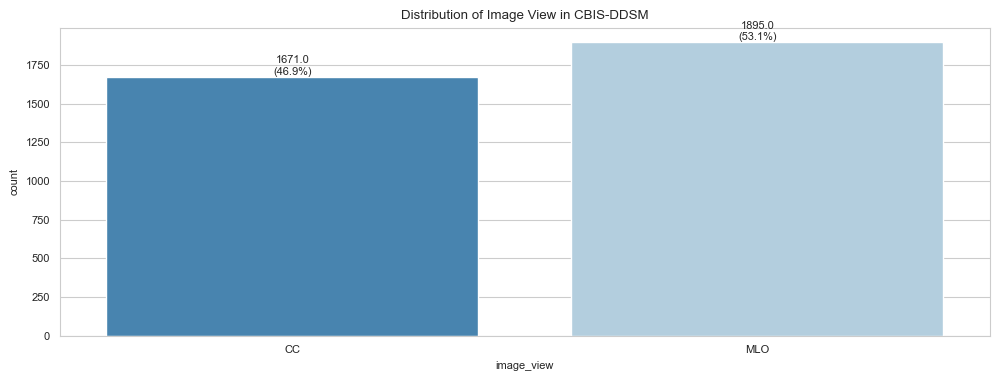

In [10]:
fig, ax = plt.subplots(figsize=(12,4))
cases.plot.countplot(x='image_view', ax=ax, title ="Distribution of Image View in CBIS-DDSM", plot_counts=True)

The proportions of CC and MLO image_views are approximately 47% and 53% respectively.

#### Abnormality Id
The abnormality id is a sequence number assigned to each abnormality for a patient.

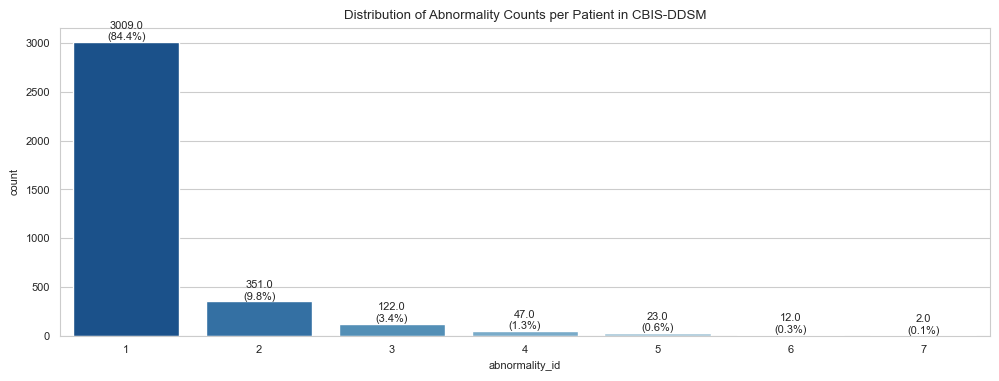

In [11]:
fig, ax = plt.subplots(figsize=(12,4))
cases.plot.countplot(x='abnormality_id', ax=ax, title ="Distribution of Abnormality Counts per Patient in CBIS-DDSM", plot_counts=True)

The vast majority of patients present with a single abnormality; although, a considerable number have two or more.

#### Abnormality Type
CBIS-DDSM contains two abnormality types: calcification and mass. 

Calcifications, common on mammograms, especially after age 50, are calcium deposits within the breast tissue. Typically benign, calcifications show up as either macrocalcifications or microcalcifications. Macrocalcifications appear as large white dots or dashes which are almost always noncancerous, requiring no further testing or follow-up. Microcalcifications show up as fine, white specks, similar to grains of salt. Usually noncancerous, but certain patterns can be an early sign of cancer.

Masses are also common, particularly among women of reproductive age. For the 25% of women affected by breast disease in their lifetime, the vast majority will present initially with a new breast mass in the primary care setting. Breast masses have a wide range of causes, from physiological adenosis to highly aggressive malignancy.  

As shown below, the dataset contains a balance of calcification and mass cases.

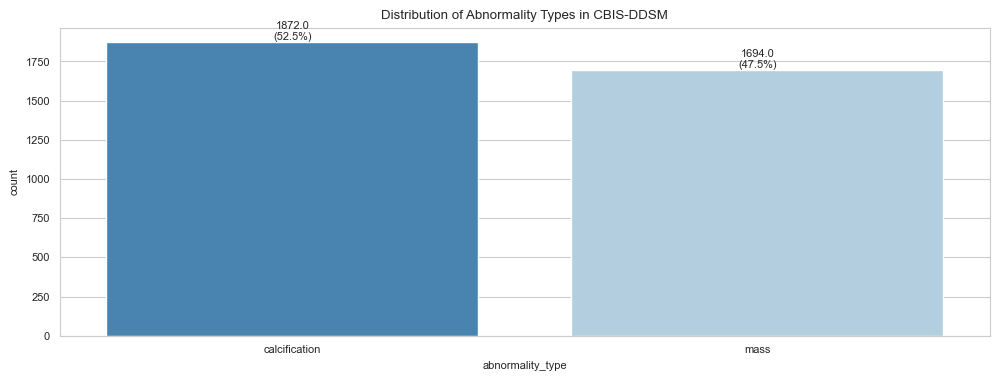

In [12]:
fig, ax = plt.subplots(figsize=(12,4))
cases.plot.countplot(x='abnormality_type', ax=ax, title ="Distribution of Abnormality Types in CBIS-DDSM", plot_counts=True)

#### Subtlety
Subtlety is a measure of the degree to which a particular case is difficult to diagnose. Values range from 1 (highly subtle) to 5 (obvious).

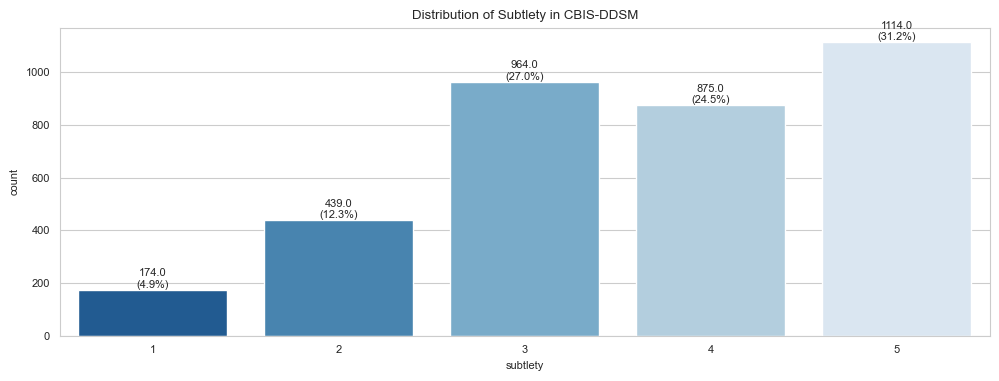

In [13]:
fig, ax = plt.subplots(figsize=(12,4))
cases.plot.countplot(x='subtlety', ax=ax, title ="Distribution of Subtlety in CBIS-DDSM", plot_counts=True)

Approximately 17% of the cases are highly subtle (1,2). A plurality of cases are moderately to slightly subtle and nearly a 1/3rd of the cases are considered obvious.

#### BI-RADS Assessment
A BI-RADS assessment is based upon a thorough evaluation of the mammographic features of concern and has the following six categories {cite}`BreastImagingReporting`:

| Category | Definition                                                                                                                                                         |
|----------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 0        | Means the findings are unclear. The radiologist will need more images to determine a score                                                                       |
| 1        | Means the findings are negative and the breast tissue appears normal. No masses, calcifications, asymmetry, or other abnormalities have been found.             |
| 2        | Means the findings are benign, which is also negative for cancer. While a   mass, calcification, or other abnormality may have been detected, it’s not cancerous. |
| 3        | Means the findings are probably benign. While a mass, calcification, or other abnormality may have been found, it’s most likely not cancerous.                    |
| 4        | Means cancer is suspected. Four subcategories relate the probability of a malignancy: 4A (2-10%) 4B (10-50%) 4C (50-95%)                       |
| 5        | Means cancer is highly suspected. Findings have a 95% chance or higher of being cancerous.                                                                       |
| 6        | Cancer was previously diagnosed using a biopsy.       
                                                                                                                  |

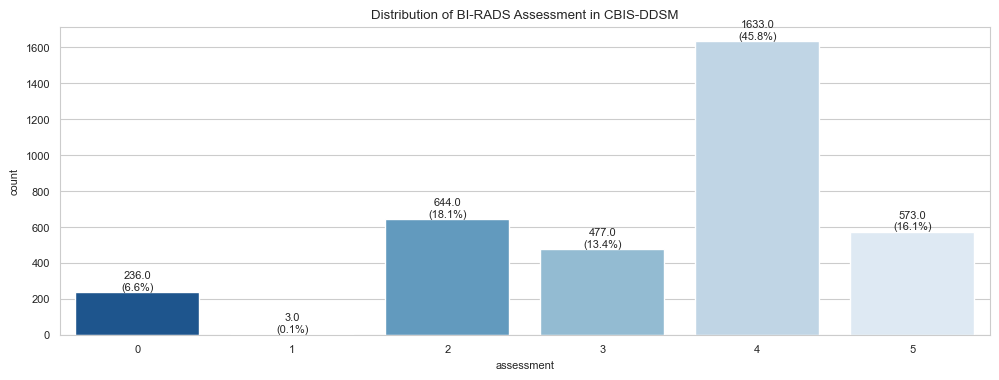

In [14]:
fig, ax = plt.subplots(figsize=(12,4))
cases.plot.countplot(x='assessment', ax=ax, title ="Distribution of BI-RADS Assessment in CBIS-DDSM", plot_counts=True)

#### Calcification Type
Calcification type describes the morphology of a case and is the most important factor in the differentiation between benign and malignant cases. There are over 40 different categories of calc_type in the dataset; and, the some of the main categories are {cite}`BreastImagingReporting`:

| #  | Morphology            |                                                                                                                | Assessment     |
|----|-----------------------|----------------------------------------------------------------------------------------------------------------|----------------|
| 1  | Amorphous             | Indistinct calcifications, without clearly defined shape, small and/or   hazy in appearance                    | BI-RADS 4B     |
| 2  | Coarse Heterogeneous  | Irregular, conspicuous calcifications, typically larger than 0.5 mm.                                           | BI-RADS 3      |
| 3  | Dystrophic            | Irregular, 'lava-shaped', larger than 0.5 mm, which develop 3-5 years   after treatment in about 30% of women. | BI-RADS 1 or 2 |
| 4  | Eggshell              | Very thin benign calcifications that appear as calcium                                                         | BI-RADS 1 or 2 |
| 5  | Fine Linear Branching | Thin linear or curvilinear irregular.                                                                          | BI-RADS 4B     |
| 6  | Large Rod-like        | Benign calcifications that form continuous rods that may occassionally be   branching.                         | BI-RADS 1 or 2 |
| 7  | Lucent-Centered       | Round or oval calcifications, typically result of fat necrosis, or   calcified debris in ducts                 | BI-RADS 1 or 2 |
| 8  | Milk of Calcium       | Benign sedimented calcifications in macro or microcysts.                                                       | BI-RADS 1 or 2 |
| 9  | Pleomorphic           | Calcifications varying in size and shape, more conspicuous than amorphic   calcifications.                     | BI-RADS 4B     |
| 10 | Punctate              | Round calcifications 0.5-1 mm in size.                                                                         | BI-RADS 2,3,4  |
| 11 | Skin                  | Skin calcifications, usually lucent-centered deposits                                                          | BI-RADS 1 or 2 |
| 12 | Vascular              | Linear or form parallel tracks, usually associated with blood vessels.                                         | BI-RADS 1 or 2 |

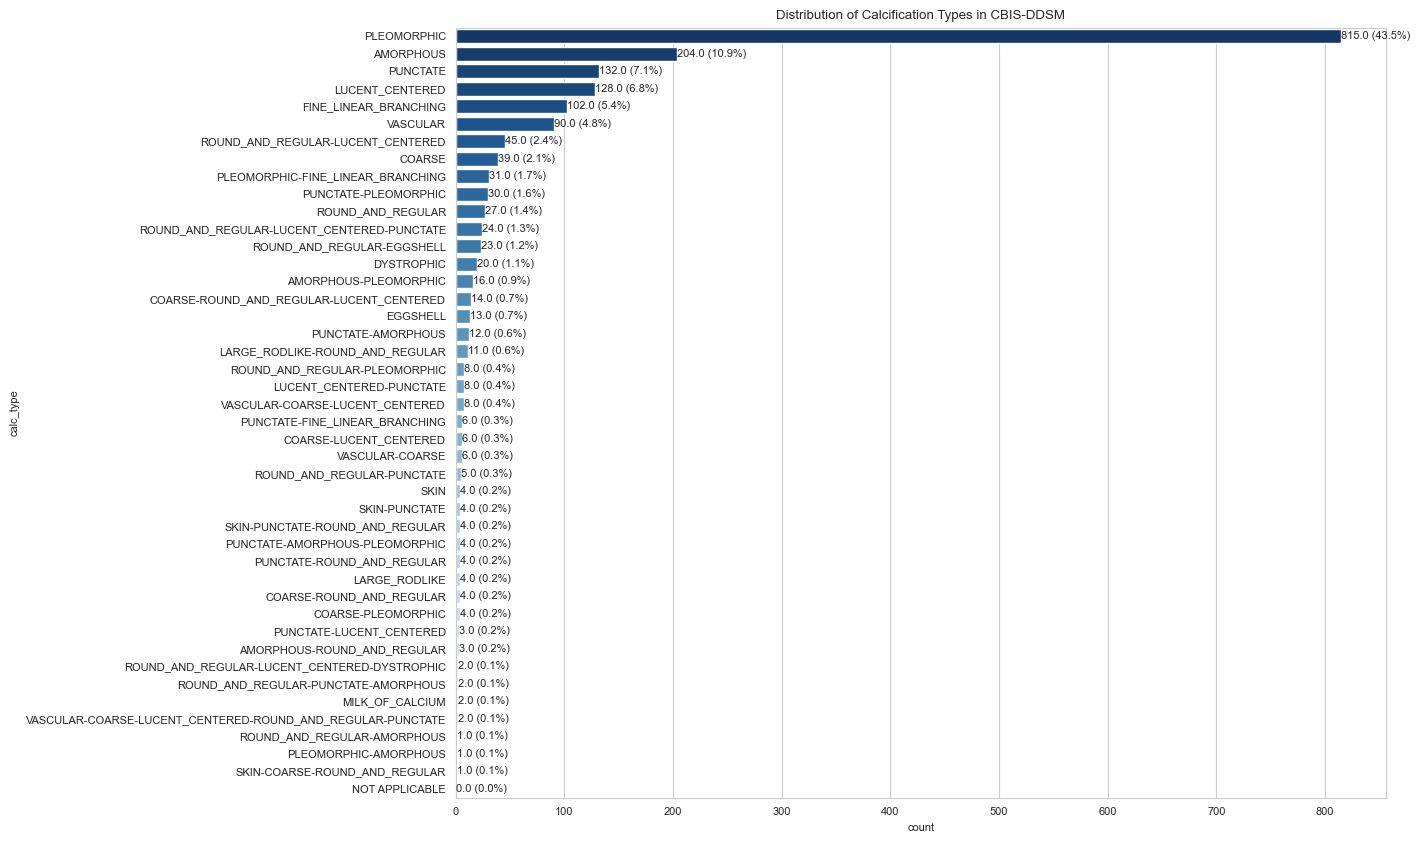

In [15]:
fig, ax = plt.subplots(figsize=(12,10))
calc.plot.countplot(y='calc_type', ax=ax, title ="Distribution of Calcification Types in CBIS-DDSM", plot_counts=True, order_by_count=True)

Pleomorphic and amorphous calcifications account for over half of the calcification cases in the dataset. Nearly 75% of the calcification cases are represented by five types.

#### Calcification Distribution
Calcification distribution refers to the arrangement of the calcifications inside the breast. BI-RADS describes the following categories of calcification distribution {cite}`BreastImagingReporting`:
1. Diffuse or Scattered: Calcifications throughout the whole breast.
2. Regional: Scattered in a larger volume (> 2 cc) of breast tissue and not in the expected ductal distribution.
3. Clustered: Groups of at least 5 calcifications in a small volume of tissue
4. Segmental: Calcium deposits appear in ducts or branches of a segment or lobe.

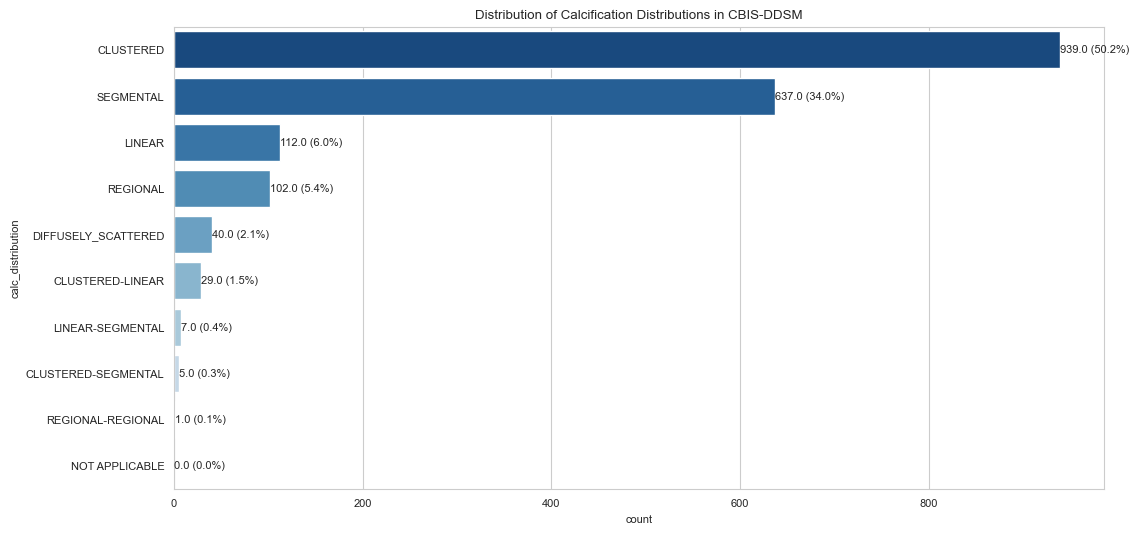

In [16]:
fig, ax = plt.subplots(figsize=(12,6))
calc.plot.countplot(y='calc_distribution', ax=ax, title ="Distribution of Calcification Distributions in CBIS-DDSM", plot_counts=True, order_by_count=True)

Over 80% of the calfication cases have either clustered or segmental distributions.

#### Mass Shape
The BI-RADS lexicon defines three mass shapes {cite}`BreastImagingReporting`:
1. Round
2. Oval
3. Irregular

The CBIS-DDSM; however, includes additional categories that further describe the mass shape, symmetry, and architecture.

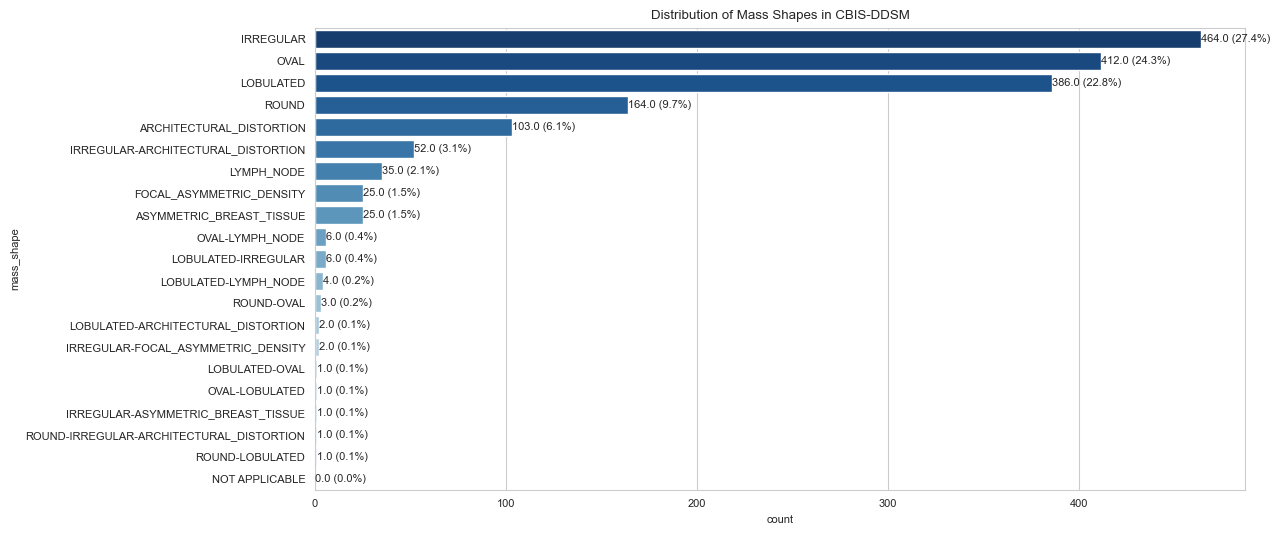

In [17]:
fig, ax = plt.subplots(figsize=(12,6))
mass.plot.countplot(y='mass_shape', ax=ax, title ="Distribution of Mass Shapes in CBIS-DDSM", plot_counts=True, order_by_count=True)

#### Mass Margins
Mass margins are features that separate the mass from the adjacent breast parenchyma. Mass margins can be {cite}`BreastImagingReporting`:
1. Circumscribed: Low probability of malignancy.
2. Obscured: Undetermined likelihood of malignancy.
3. Spiculated: Higher likelihood of malignancy.
4. Microlobulated: Suspicious for breast carcinoma: 
5. Ill-Defined: Also called 'indistinct'. Generally suspicious of malignancy.

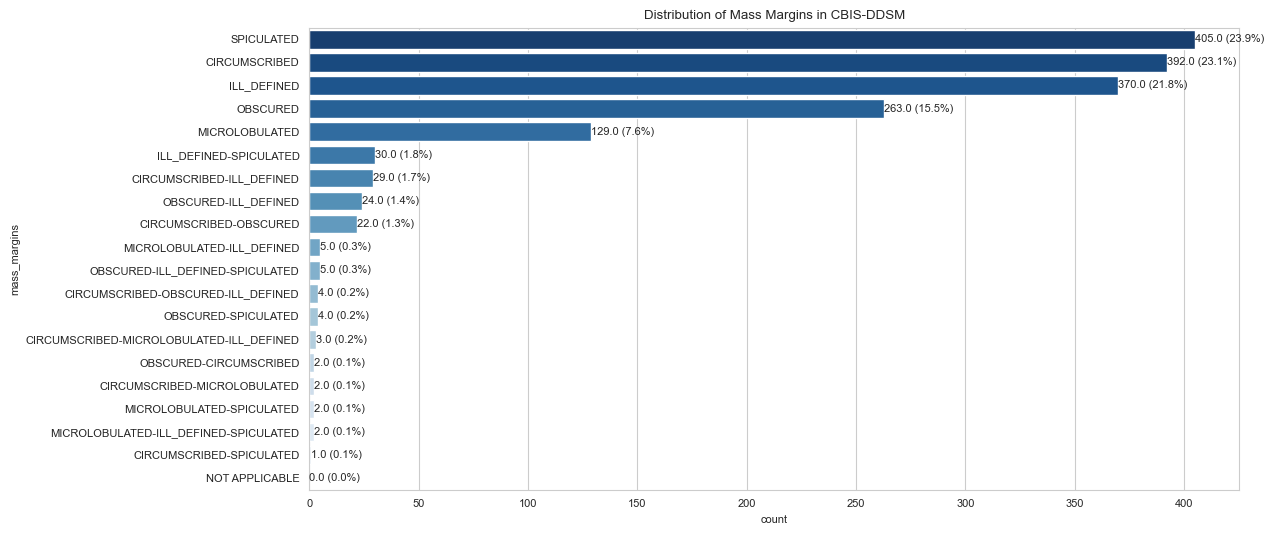

In [18]:
fig, ax = plt.subplots(figsize=(12,6))
mass.plot.countplot(y='mass_margins', ax=ax, title ="Distribution of Mass Margins in CBIS-DDSM", plot_counts=True, order_by_count=True)

Spiculated, circumscribed and ill-defined make up nearly 70% of the mass abnormalities.

#### Pathology
The dataset distinguishes three outcomes: malignant, benign, and benign without callback. The latter indicates that the region may be suspicious, and should be monitored, but no further investigation is required.

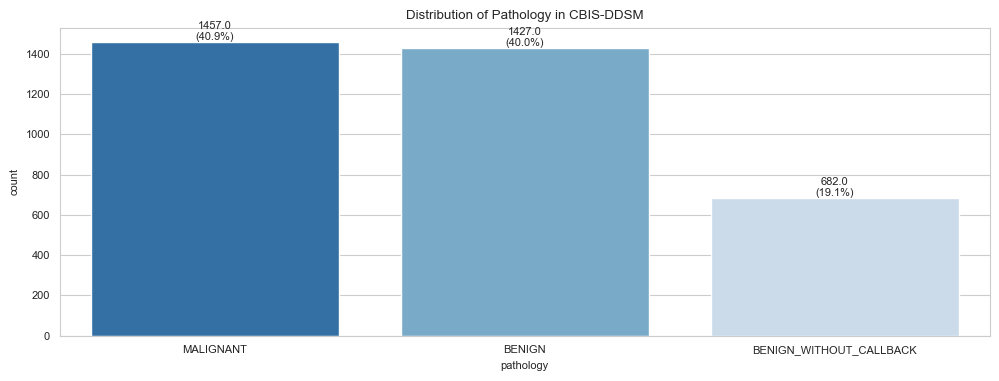

In [19]:
fig, ax = plt.subplots(figsize=(12,4))
cases.plot.countplot(x='pathology', ax=ax, title ="Distribution of Pathology in CBIS-DDSM", plot_counts=True, order_by_count=True)

The majority of cases are benign; although, benign without callback represents a considerable proportion of the cases.

#### Cancer
Here, we collapse BENIGN and BENIGN_WITHOUT_CALLBACK into a single category.

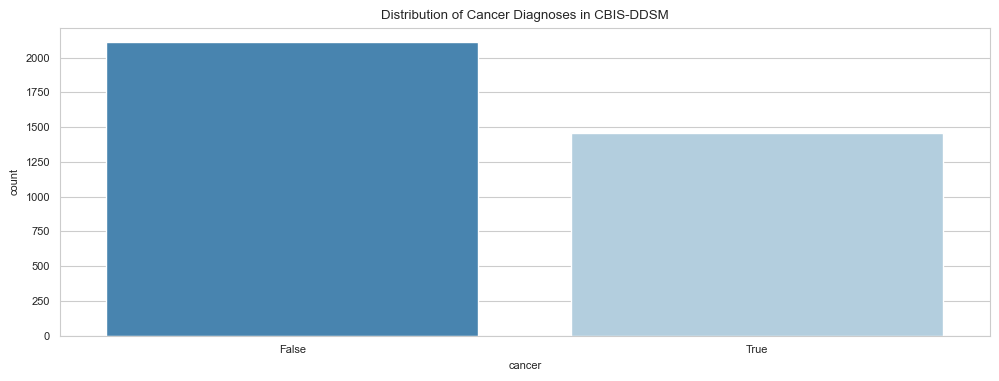

In [20]:
fig, ax = plt.subplots(figsize=(12,4))
cases.plot.countplot(x='cancer', ax=ax, title ="Distribution of Cancer Diagnoses in CBIS-DDSM")

#### Summary CBIS-DDSM Case Univariate Analysis
Several observations can be made at this stage.
1. The CBIS-DDSM is well-balanced with respect to breast density, morphology, subtlety, BI-RADS assessment, and pathology. 
2. Over 40 calcification types are represented; however, the majority of cases fall into one of five types.
3. Similarly, there are nearly 20 categories of mass margins; yet, but most cases fall into one of the five major classes:
   1. Spiculated
   2. Circumscribed
   3. Obscured
   4. Ill-Defined

Next up? Bivariate analysis.

### Case Bivariate Analysis
This bivariate analysis will comprise a dependency analysis, and an inter-dependence analysis.  The former assesses the degree to which a cancer diagnosis depends upon the values of the explanatory variables, such as breast density, type and distribution of calcifications, and the shape and margins of masses. The inter-dependence analysis explores the association between two independent variables.

In [21]:
df = cases.as_df(categorize_ordinals=True)

#### Bivariate Target Variable Association Analysis

##### Cancer Diagnosis by Breast Density

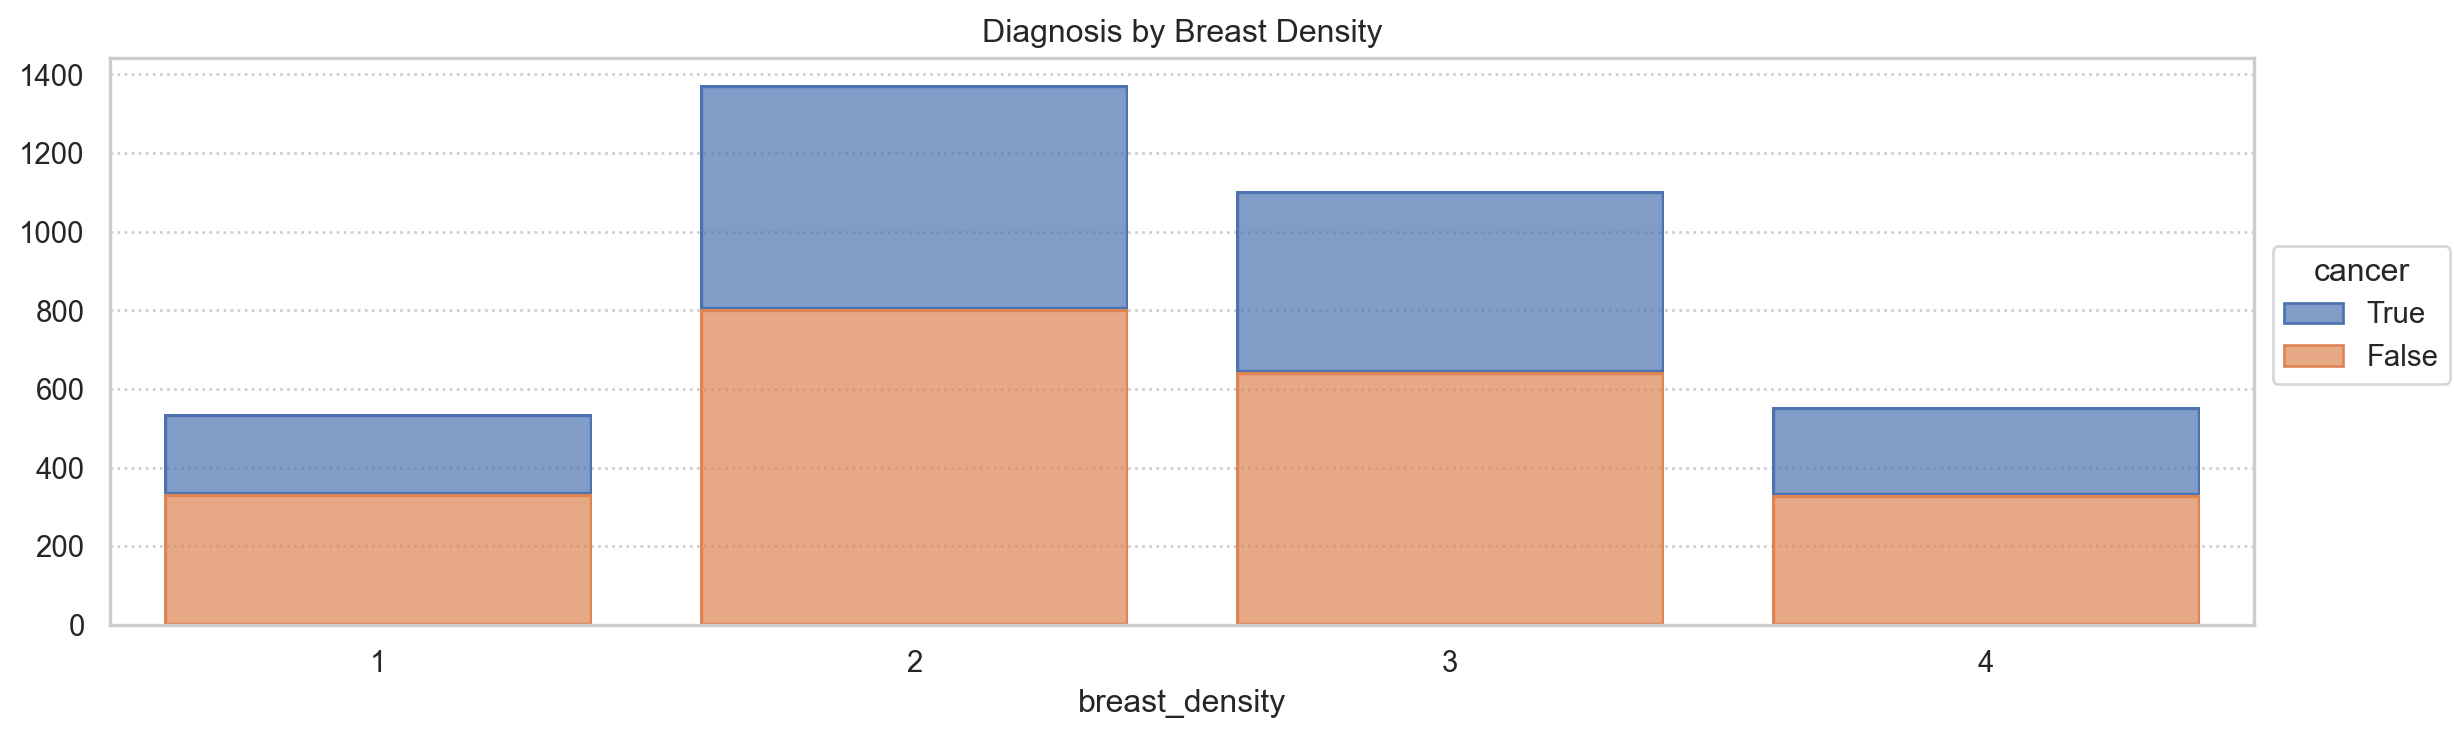

In [22]:
sns.objects.Plot(df, x='breast_density', color='cancer').add(so.Bar(), so.Count(), so.Stack()).theme({**sns.axes_style("whitegrid"), "grid.linestyle": ":"}).label(title="Diagnosis by Breast Density").layout(size=(12,4), engine='tight')

It's rather difficult to assess the degree to which breast density related to a diagnosis. Let's plot the relative proportions.

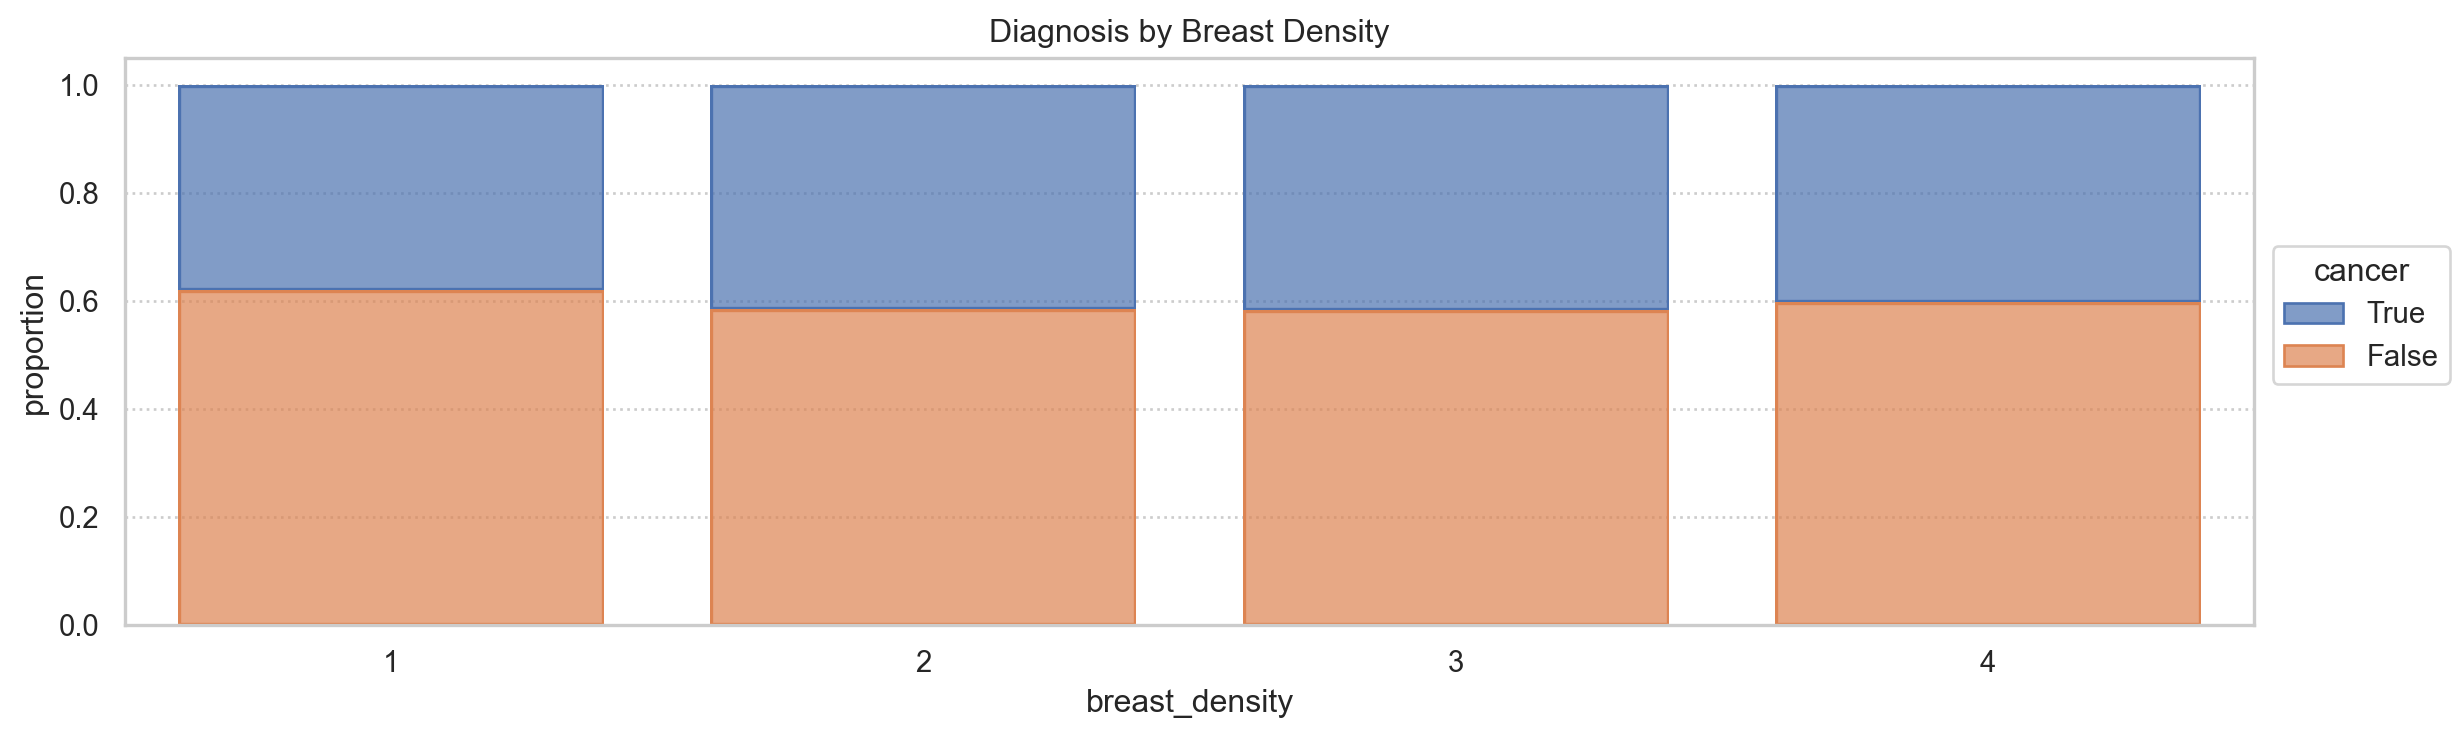

In [23]:
prop = df[['breast_density', 'cancer']].groupby(by=['breast_density']).value_counts(normalize=True).to_frame().reset_index().sort_values(by=['breast_density','cancer'])
sns.objects.Plot(prop, x='breast_density', y='proportion', color='cancer').add(so.Bar(), so.Stack()).theme({**sns.axes_style("whitegrid"), "grid.linestyle": ":"}).label(title="Diagnosis by Breast Density").layout(size=(12,4), engine='tight')

Breast density is considered a risk factor for breast cancer, as women with dense breasts have a higher risk of breast cancer than women with fatty breasts {cite}`DenseBreastsAnswers2018`. Notwithstanding, the CBIS-DDSM data don't reveal a strong relationship between breast density and diagnosis. Let's see if a test of association supports our inference.

In [24]:
kt = cases.stats.kendallstau(a='breast_density', b='cancer')
print(kt)



                          KendallsTau                           
                            Name | Kendall's τ
                           Value | 0.011138411035362646
                          Pvalue | 0.5382894688881223
                           Alpha | 0.05
                               A | breast_density
                               B | cancer
                               N | 3566
                        Strength | Weak




The Kendall's Tau test measuring the association between breast density and malignancy indicated a non-significant association of weak effect, ($\phi_\tau$ = 0.01, p = 0.54).

##### Cancer Diagnosis by Breast
A 2022 study published in Nature {cite}`abdouLeftSidedBreast2022` suggests that breast cancer is slightly more prevalent on the left side of the body than it is on the right. Do the CBIS-DDSM data support this finding?

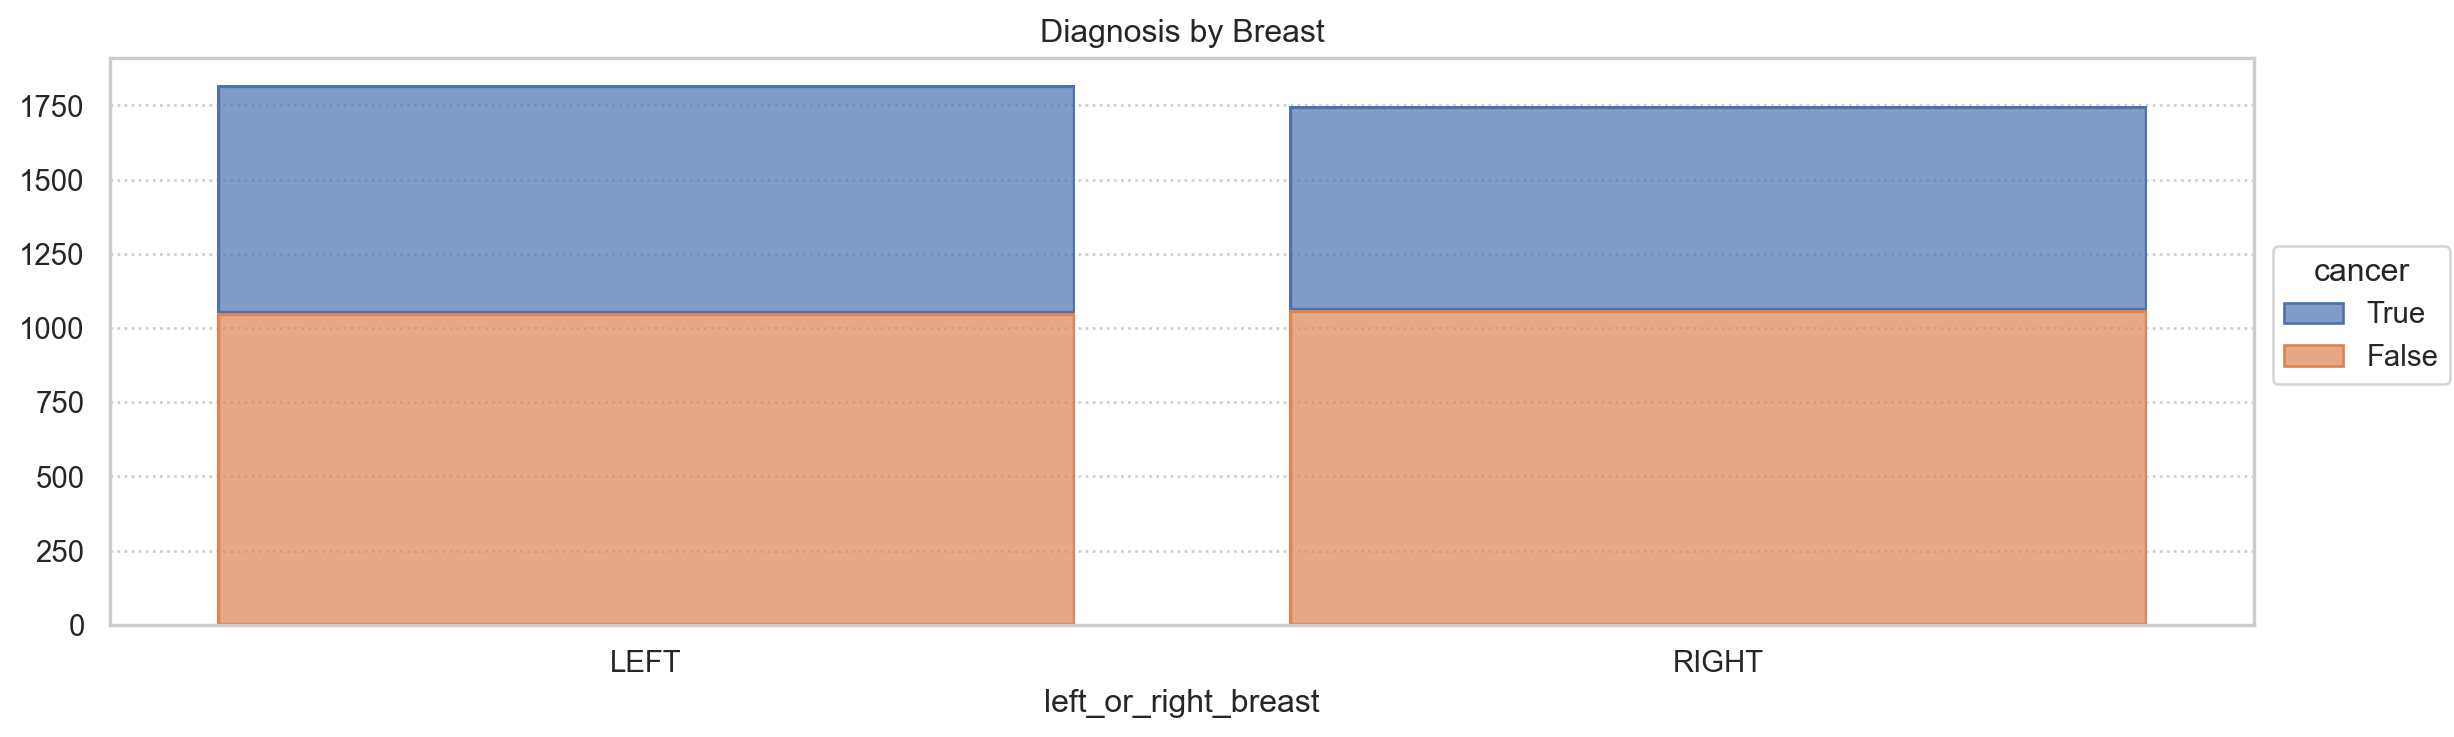

In [25]:
sns.objects.Plot(df, x='left_or_right_breast', color='cancer').add(so.Bar(), so.Count(), so.Stack()).theme({**sns.axes_style("whitegrid"), "grid.linestyle": ":"}).label(title="Diagnosis by Breast").layout(size=(12,4), engine='tight')

If there is a slightly greater risk of cancer in the left breast, it would not be evident in the CBIS-DDSM data.

In [26]:
cv = cases.stats.cramersv(a='left_or_right_breast', b='cancer')
print(cv)



                            CramersV                            
                            Name | Cramer's V
                           Value | 0.028861432861833916
                          Pvalue | 0.08480010265447133
                           Alpha | 0.05
                        Strength | Negligible
                               A | left_or_right_breast
                               B | cancer
                               N | 3566
                             Dof | 1
                         X2alpha | 0.05
                              X2 | 2.970414906184831
                           X2dof | 1




The chi-square test above, indicates a non-significant association of negligible effect between breast and diagnosis, ($X^2$ (1,n=3566)=2.97 p=0.08, $\phi$=.03).

##### Cancer by Image View
A study published in RSNA Journals {cite}`korhonenBreastCancerConspicuity2019` analyzed breast cancer conspicuity by image_view and determined that cancers were more likely to have high conspicuity in the craniocaudal (CC) than the mediolateral oblique (MLO) image_view.  Let's see what our data suggest.

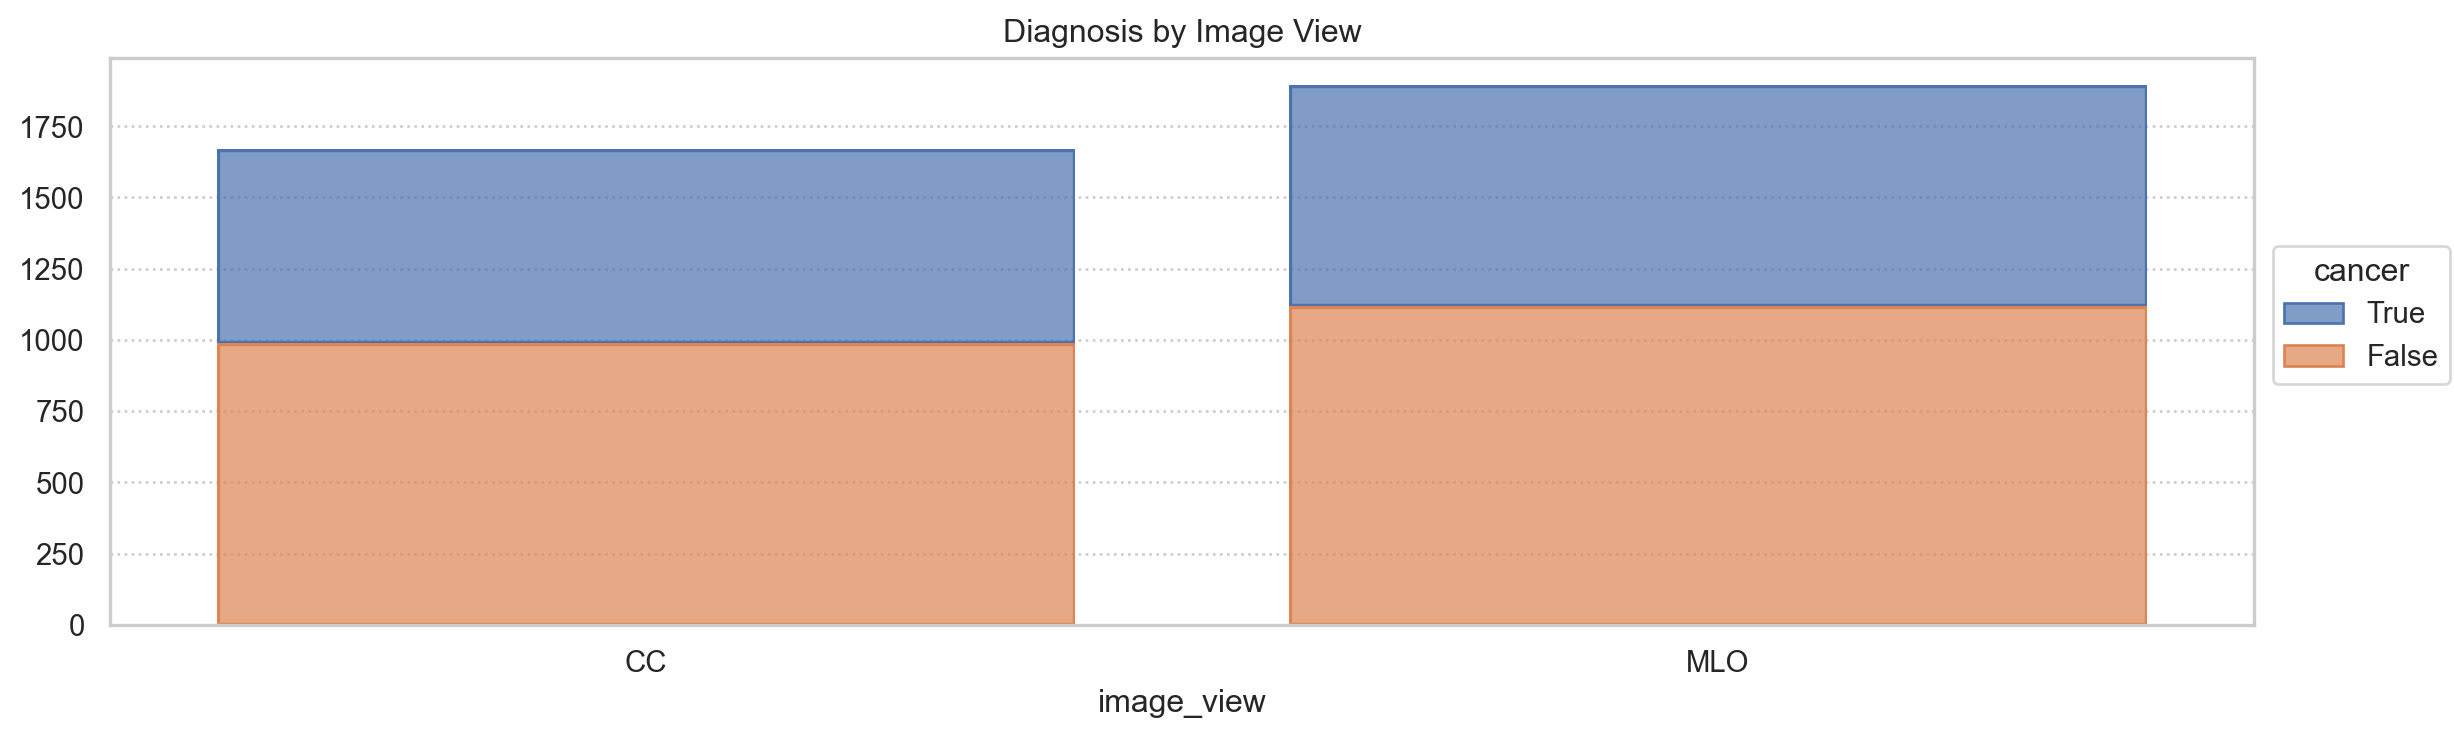

In [27]:
sns.objects.Plot(df, x='image_view', color='cancer').add(so.Bar(), so.Count(), so.Stack()).theme({**sns.axes_style("whitegrid"), "grid.linestyle": ":"}).label(title="Diagnosis by Image View").layout(size=(12,4), engine='tight')

In [28]:
df[[ 'cancer', 'image_view']].groupby(by=['image_view']).value_counts(normalize=True).to_frame()

proportion
image_view cancer            
CC         False         0.59
           True          0.41
MLO        False         0.59
           True          0.41

Both image_views have the same proportion of malignancies suggesting no association between image image_view and the diagnosis.

In [29]:
cv = cases.stats.cramersv(a='image_view', b='cancer')
print(cv)



                            CramersV                            
                            Name | Cramer's V
                           Value | 0.0014163311721585292
                          Pvalue | 0.9325971883801198
                           Alpha | 0.05
                        Strength | Negligible
                               A | image_view
                               B | cancer
                               N | 3566
                             Dof | 1
                         X2alpha | 0.05
                              X2 | 0.007153374565586881
                           X2dof | 1




The chi-square test above, indicates a non-significant association of negligible effect between image image_view and diagnosis, ($X^2$ (1,n=3566)=0.007 p=0.93, $\phi$=.002).

##### Cancer by Abnormality Type
Is abnormality type an indicator of malignancy?

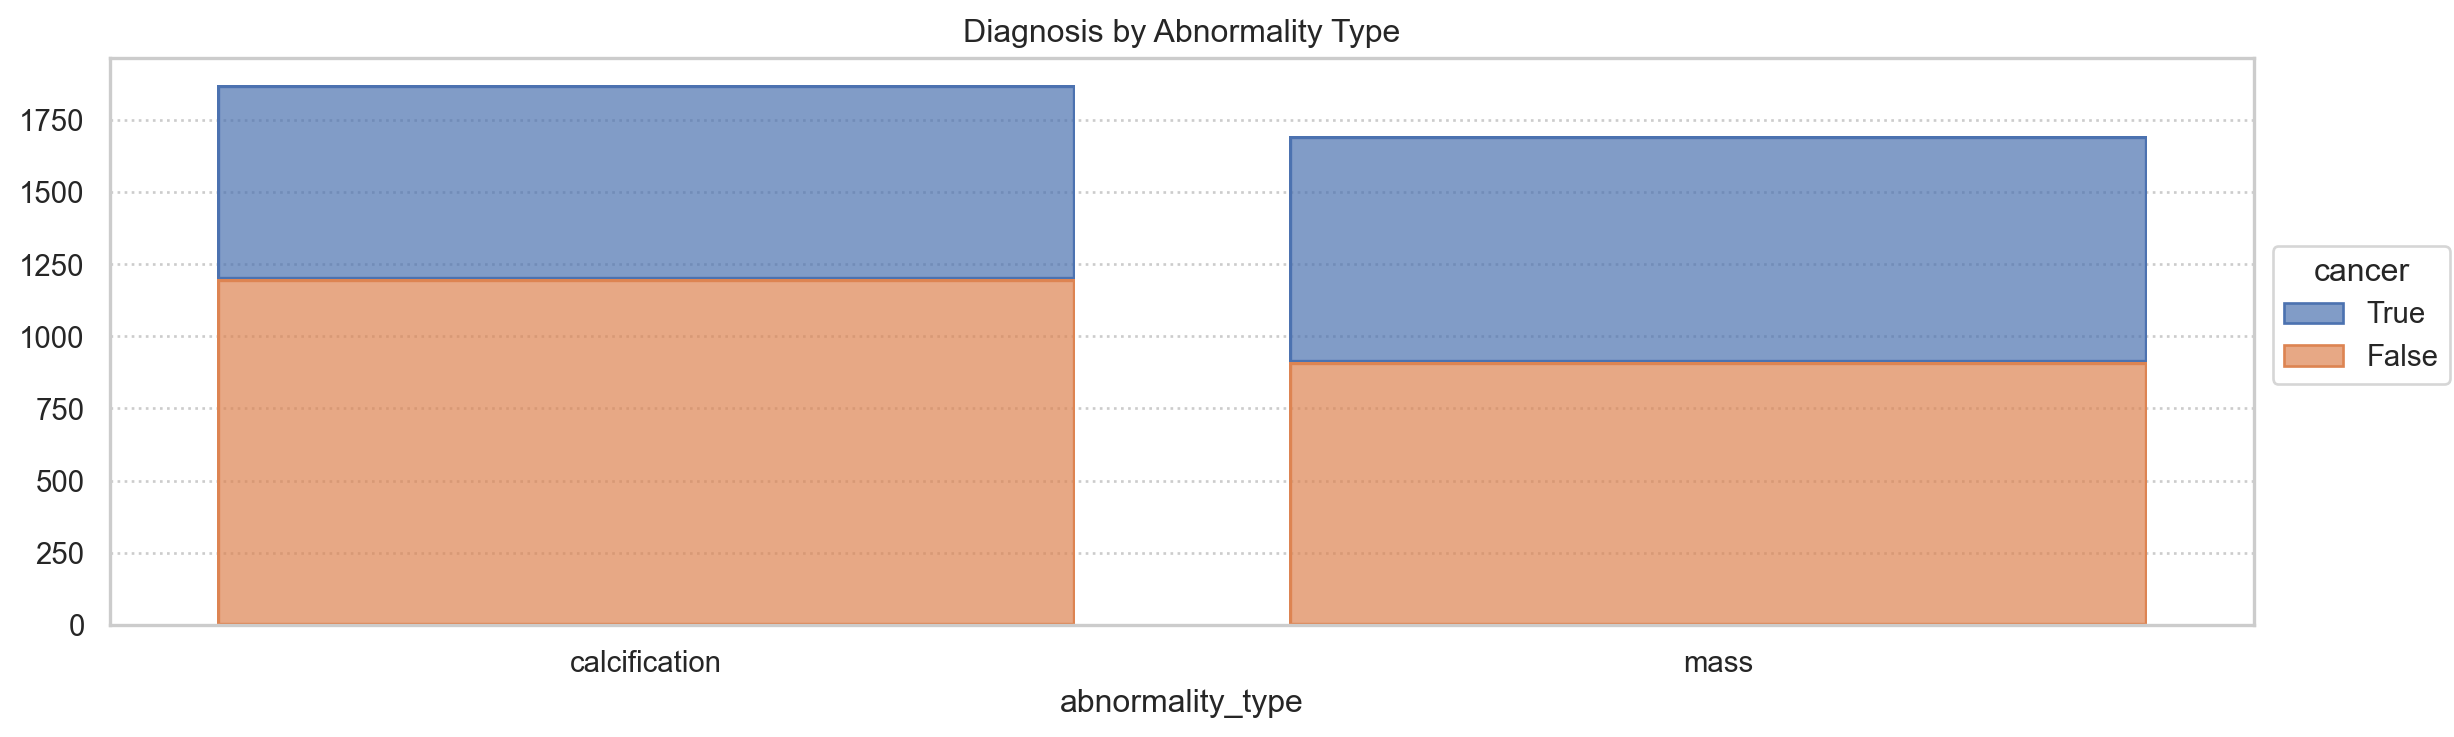

In [30]:
sns.objects.Plot(df, x='abnormality_type', color='cancer').add(so.Bar(), so.Count(), so.Stack()).theme({**sns.axes_style("whitegrid"), "grid.linestyle": ":"}).label(title="Diagnosis by Abnormality Type").layout(size=(12,4), engine='tight')

In [31]:
df[[ 'cancer', 'abnormality_type']].groupby(by=['cancer']).value_counts(normalize=True).to_frame()

proportion
cancer abnormality_type            
False  calcification           0.57
       mass                    0.43
True   mass                    0.54
       calcification           0.46

These data indicate that the probability of a malignancy is slightly higher for masses than calcifications. Is this significant?

In [32]:
cv = cases.stats.cramersv(a='abnormality_type', b='cancer')
print(cv)



                            CramersV                            
                            Name | Cramer's V
                           Value | 0.10437040964253724
                          Pvalue | 4.5880686528820935e-10
                           Alpha | 0.05
                        Strength | Small
                               A | abnormality_type
                               B | cancer
                               N | 3566
                             Dof | 1
                         X2alpha | 0.05
                              X2 | 38.84508847031938
                           X2dof | 1




The chi-square test above, indicates a significant association of small effect between abnormality type and diagnosis, ($X^2$ (1,n=3566)=38.85 p<0.01, $\phi$=.10). More malignancies were diagnosed among the mass cases, compared to calcifications (54% vs 46%).

##### BI-RADS Assessment and Cancer
To what degree is there (dis)agreement between the BI-RADS assessment the diagnosis. The BI-RADS assessment is an overall summary of the mammography report and has seven categories.

| Label | Description                                                                              | Likelihood of Cancer                                                        |
| ----- | ---------------------------------------------------------------------------------------- | --------------------------------------------------------------------------- |
| 0     | Incomplete . Need Additional   Imaging Evaluation and/or Prior Mammograms for Comparison | NA                                                                          |
| 1     | Negative Routine mammography                                                             | Essentially 0% likelihood of malignancy                                     |
| 2     | Benign Routine mammography                                                               | Essentially 0% likelihood of malignancy                                     |
| 3     | Probably Benign Short-interval   (6-month)                                               | > 0% but . 2% likelihood of malignancy                                      |
| 4     | Suspicious                                                                               | Low: 2% to ≤ 10%      Moderate: > 10% to ≤ 50%       High: > 50% to < 95% |
| 5     | Highly Suggestive of Malignancy                                                          | > 95% likelihood of malignancy                                              |
| 6     | Known Biopsy-Proven Malignancy                                                           | NA                                                                          |

To what degree is there agreement between the BI-RADS assessments and diagnosis.

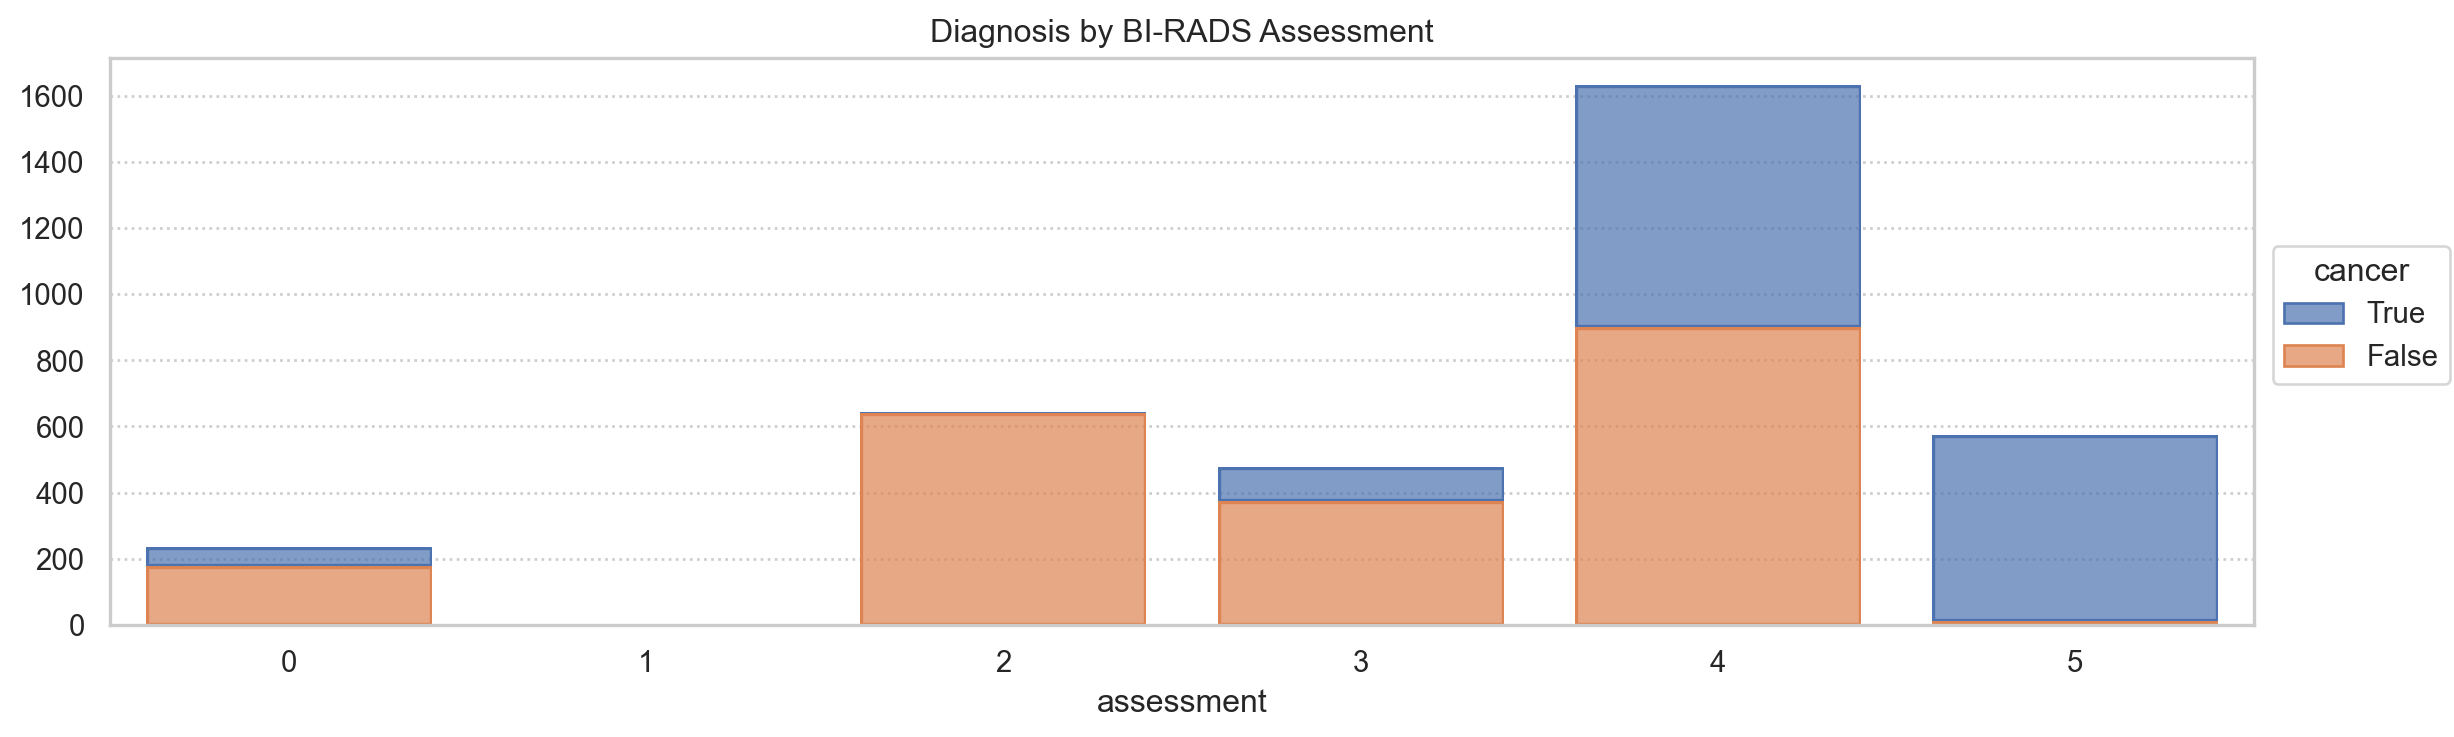

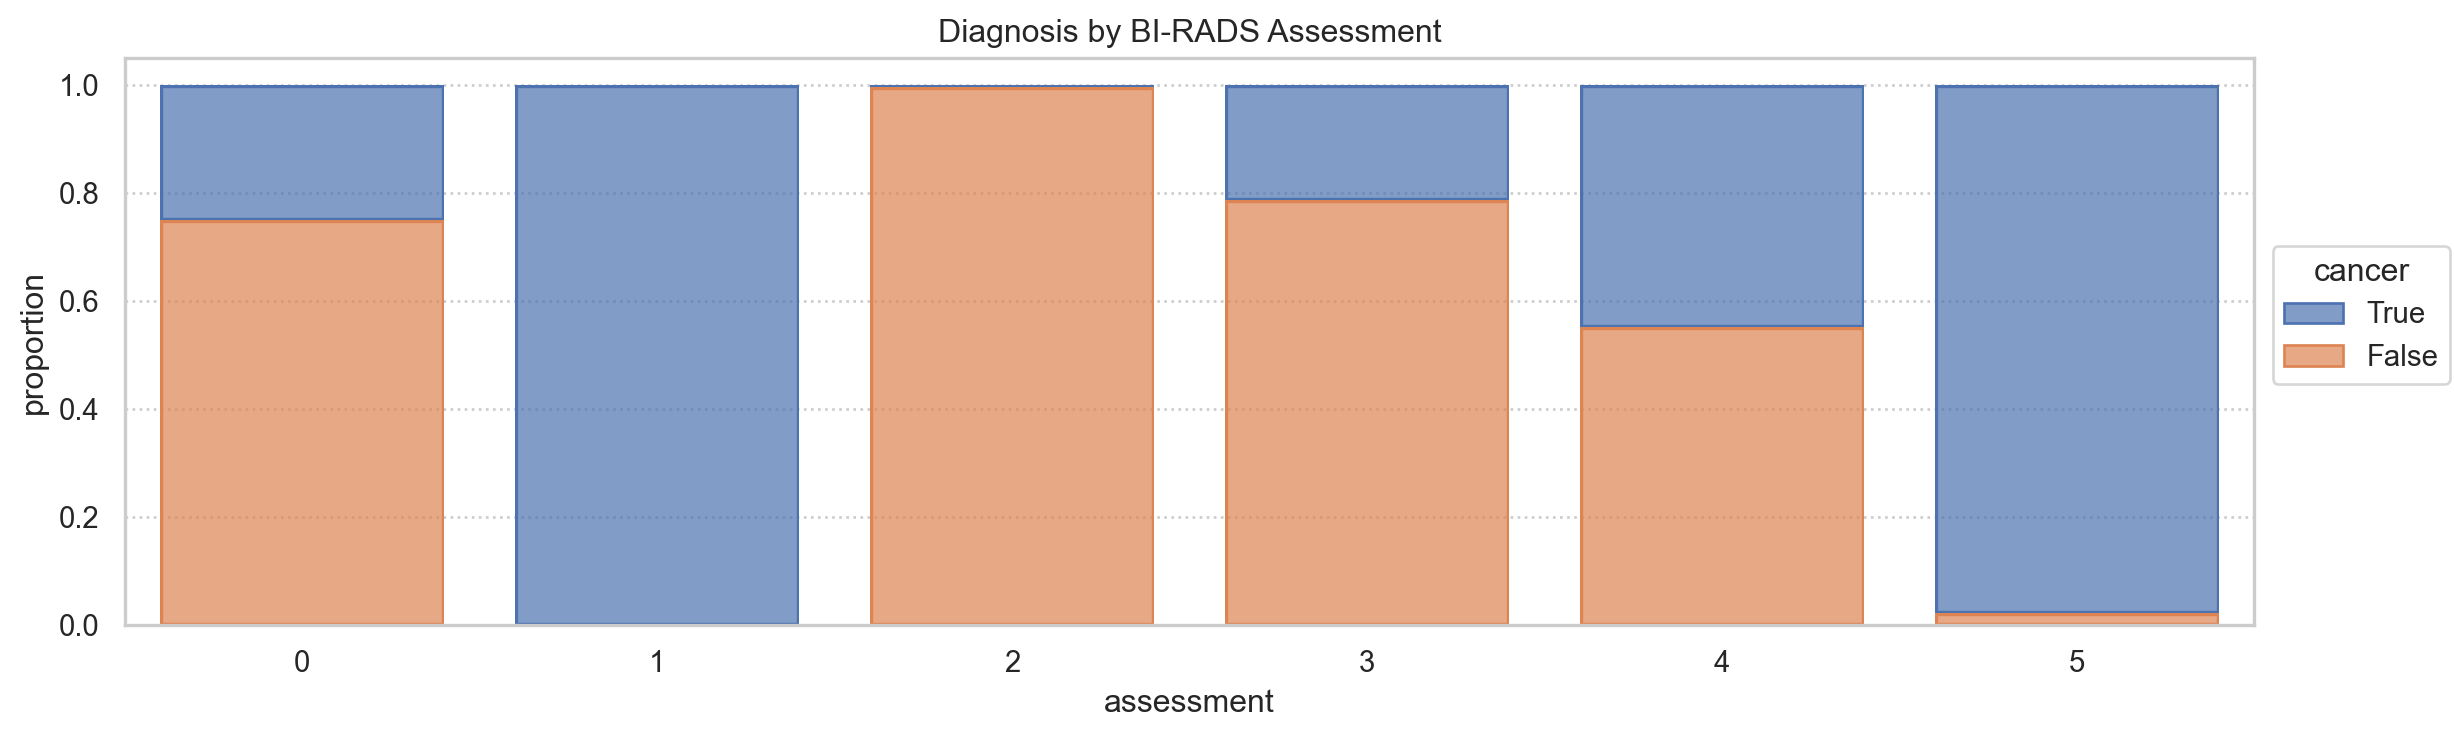

In [33]:
sns.objects.Plot(df, x='assessment', color='cancer').add(so.Bar(), so.Count(), so.Stack()).theme({**sns.axes_style("whitegrid"), "grid.linestyle": ":"}).label(title="Diagnosis by BI-RADS Assessment").layout(size=(12,4), engine='tight')
prop = df[['assessment', 'cancer']].groupby(by=['assessment']).value_counts(normalize=True).to_frame().reset_index().sort_values(by=['assessment','cancer'])
sns.objects.Plot(prop, x='assessment', y='proportion', color='cancer').add(so.Bar(), so.Stack()).theme({**sns.axes_style("whitegrid"), "grid.linestyle": ":"}).label(title="Diagnosis by BI-RADS Assessment").layout(size=(12,4), engine='tight')

In [34]:
counts = df[[ 'assessment', 'cancer']].groupby(by=['assessment']).value_counts(normalize=False).to_frame().sort_values(by=['assessment', 'cancer'])
prop = df[[ 'assessment', 'cancer']].groupby(by=['assessment']).value_counts(normalize=True).to_frame().sort_values(by=['assessment', 'cancer'])
pd.concat([counts, prop], axis=1)

count  proportion
assessment cancer                   
0          False     177        0.75
           True       59        0.25
1          False       0        0.00
           True        3        1.00
2          False     642        1.00
           True        2        0.00
3          False     375        0.79
           True      102        0.21
4          False     902        0.55
           True      731        0.45
5          False      13        0.02
           True      560        0.98

These data do show a relationship between BI-RADS assessment and diagnosis. Let's evaluate the effect size.

In [35]:
kt = cases.stats.kendallstau(a='assessment', b='cancer')
print(kt)



                          KendallsTau                           
                            Name | Kendall's τ
                           Value | 0.5994799138998625
                          Pvalue | 1.4696313517612682e-244
                           Alpha | 0.05
                               A | assessment
                               B | cancer
                               N | 3566
                        Strength | Strong




Indeed, the Kendall's Tau test above, indicates a significant association of strong effect between BI-RADS assessment and diagnosis, ($\phi_\tau$=0.60, p<0.01).

Several observations. 
1. Incomplete assessments had a malignancy approaching 25%.
2. There were only three BI-RADS Category 1 assessments.
3. Category 2 assessments, were all negative for cancer.
4. Approximately 20% of the BI-RADS category 3, probably benign, were ultimately diagnosed as malignant.
5. Suspicious cases (BI-RADS 4) were nearly 50/50 benign/malignant.
6. Just 2% of the highly suspicious cases were benign.

##### Subtlety and Cancer
Are malignancies more or less conspicuous?

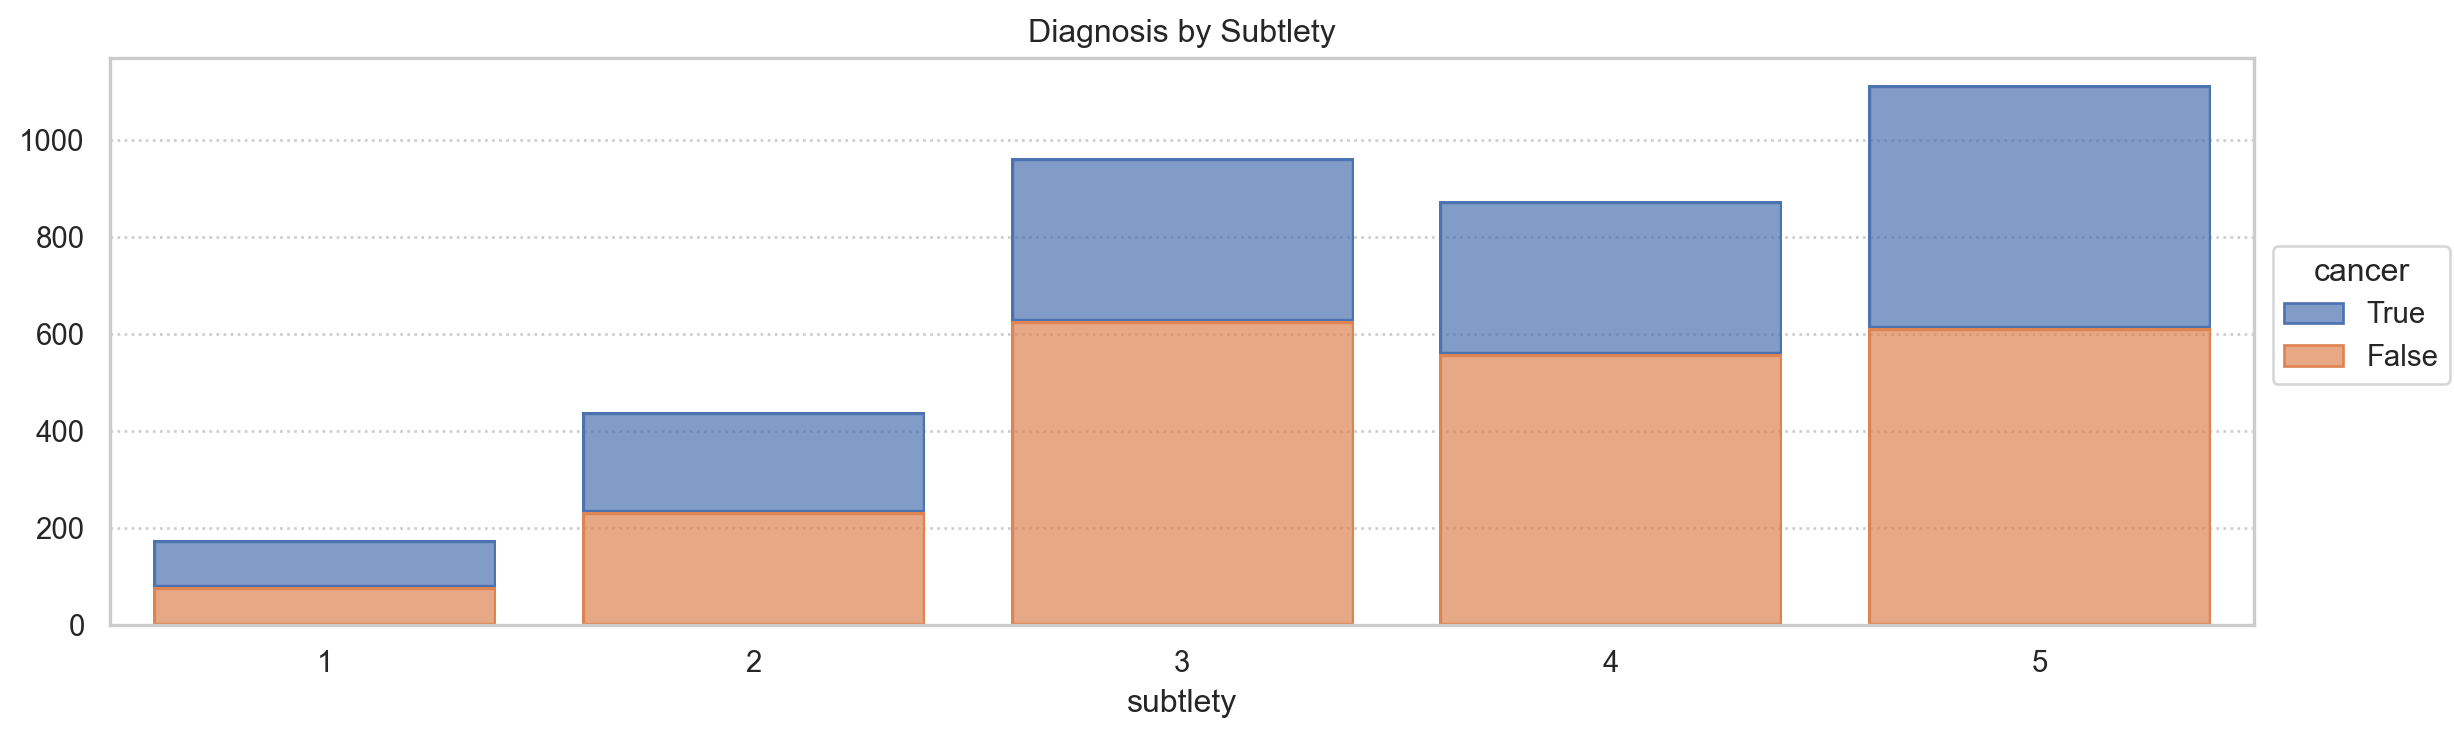

In [36]:
sns.objects.Plot(df, x='subtlety', color='cancer').add(so.Bar(), so.Count(), so.Stack()).theme({**sns.axes_style("whitegrid"), "grid.linestyle": ":"}).label(title="Diagnosis by Subtlety").layout(size=(12,4), engine='tight')

Any association between subtlety and malignancy isn't clear from the above. Let's examine the relative proportions of malignancy vis-a-vis subtlety.

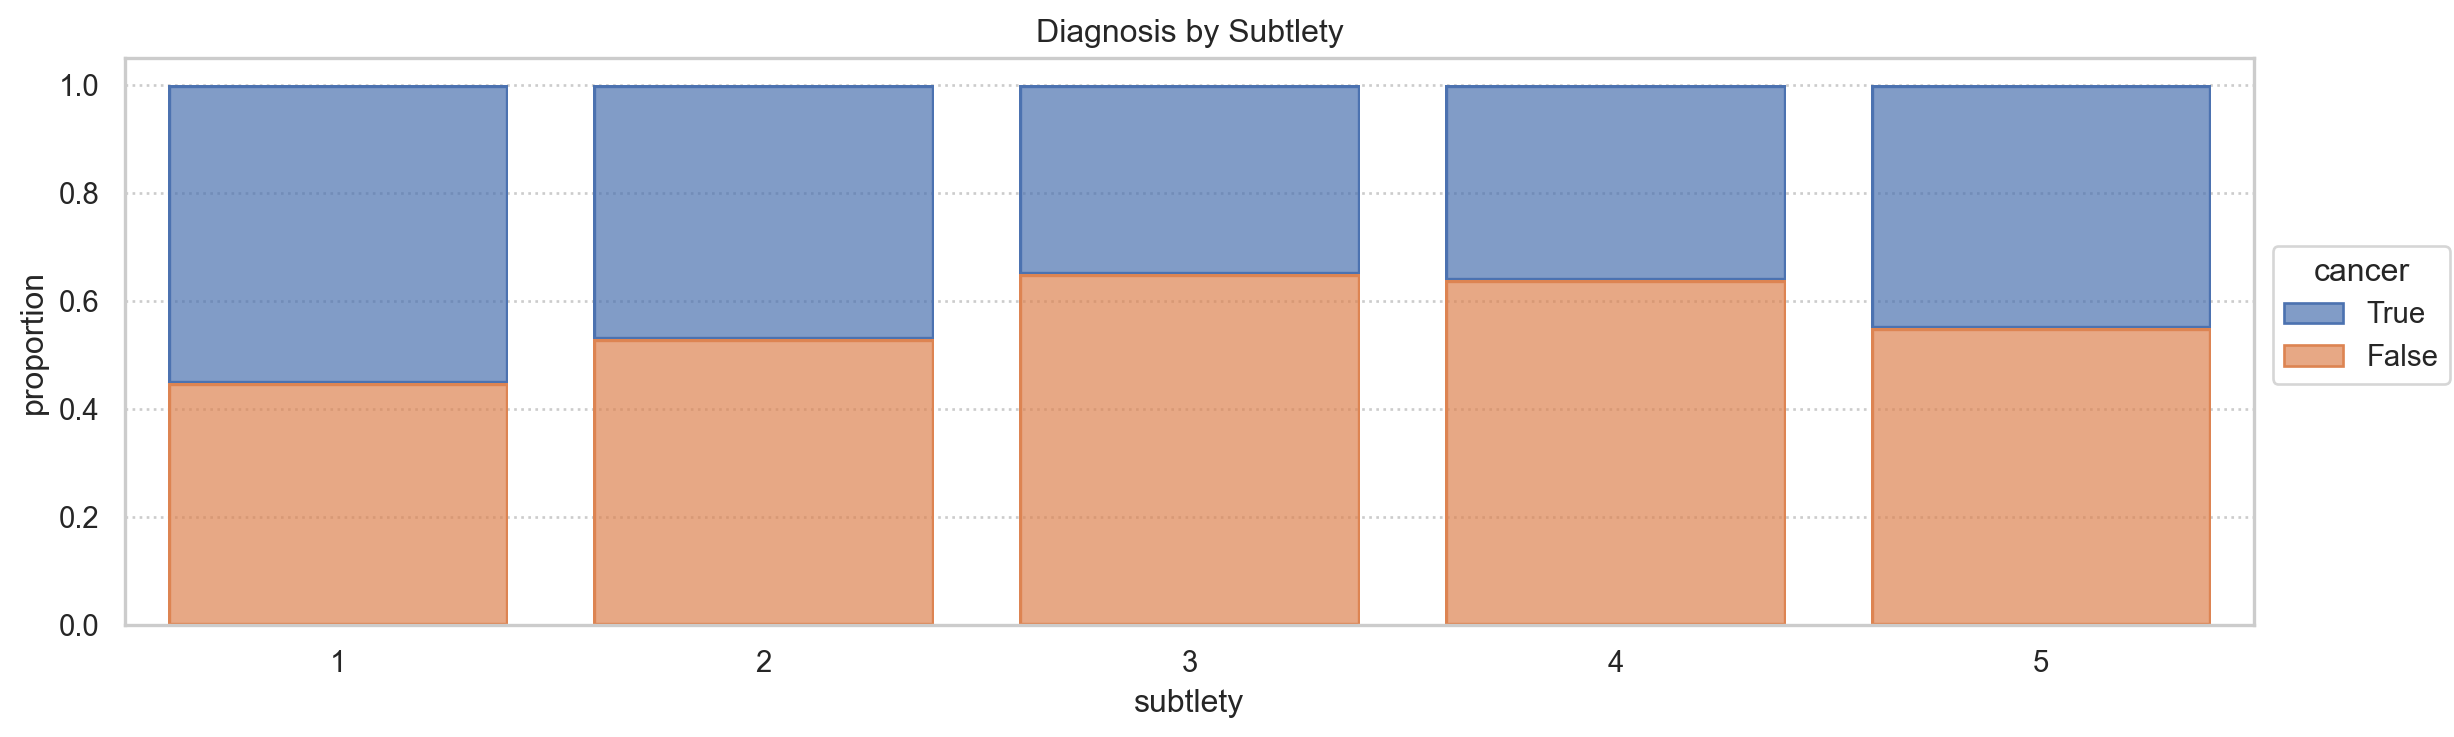

In [37]:
prop = df[['subtlety', 'cancer']].groupby(by=['subtlety']).value_counts(normalize=True).to_frame().reset_index().sort_values(by=['subtlety','cancer'])
sns.objects.Plot(prop, x='subtlety', y='proportion', color='cancer').add(so.Bar(), so.Stack()).theme({**sns.axes_style("whitegrid"), "grid.linestyle": ":"}).label(title="Diagnosis by Subtlety").layout(size=(12,4), engine='tight')

An association seems to be present. Let's look at the numbers.

In [38]:
counts = df[[ 'subtlety', 'cancer']].groupby(by=['subtlety']).value_counts(normalize=False).to_frame().sort_values(by=['subtlety', 'cancer'])
prop = df[[ 'subtlety', 'cancer']].groupby(by=['subtlety']).value_counts(normalize=True).to_frame().sort_values(by=['subtlety', 'cancer'])
pd.concat([counts, prop], axis=1)

count  proportion
subtlety cancer                   
1        False      78        0.45
         True       96        0.55
2        False     232        0.53
         True      207        0.47
3        False     627        0.65
         True      337        0.35
4        False     559        0.64
         True      316        0.36
5        False     613        0.55
         True      501        0.45

Again, it would be difficult to draw an inference of association between subtlety and diagnosis.

In [39]:
kt = cases.stats.kendallstau(a='subtlety', b='cancer')
print(kt)



                          KendallsTau                           
                            Name | Kendall's τ
                           Value | 0.003196827770471352
                          Pvalue | 0.8618112089236021
                           Alpha | 0.05
                               A | subtlety
                               B | cancer
                               N | 3566
                        Strength | Weak




The Kendall's Tau test measuring the association between subtlety and malignancy indicated a non-significant association of weak effect, $\phi_\tau$ = 0.003, p = 0.86.

##### Calcification Type and Cancer
What is the association between calcification type and malignancy. According to the literature, fine linear branching, and pleomorphic calcifications are of the highest concern, followed by amorphous and coarse heterogenous abnormalities.

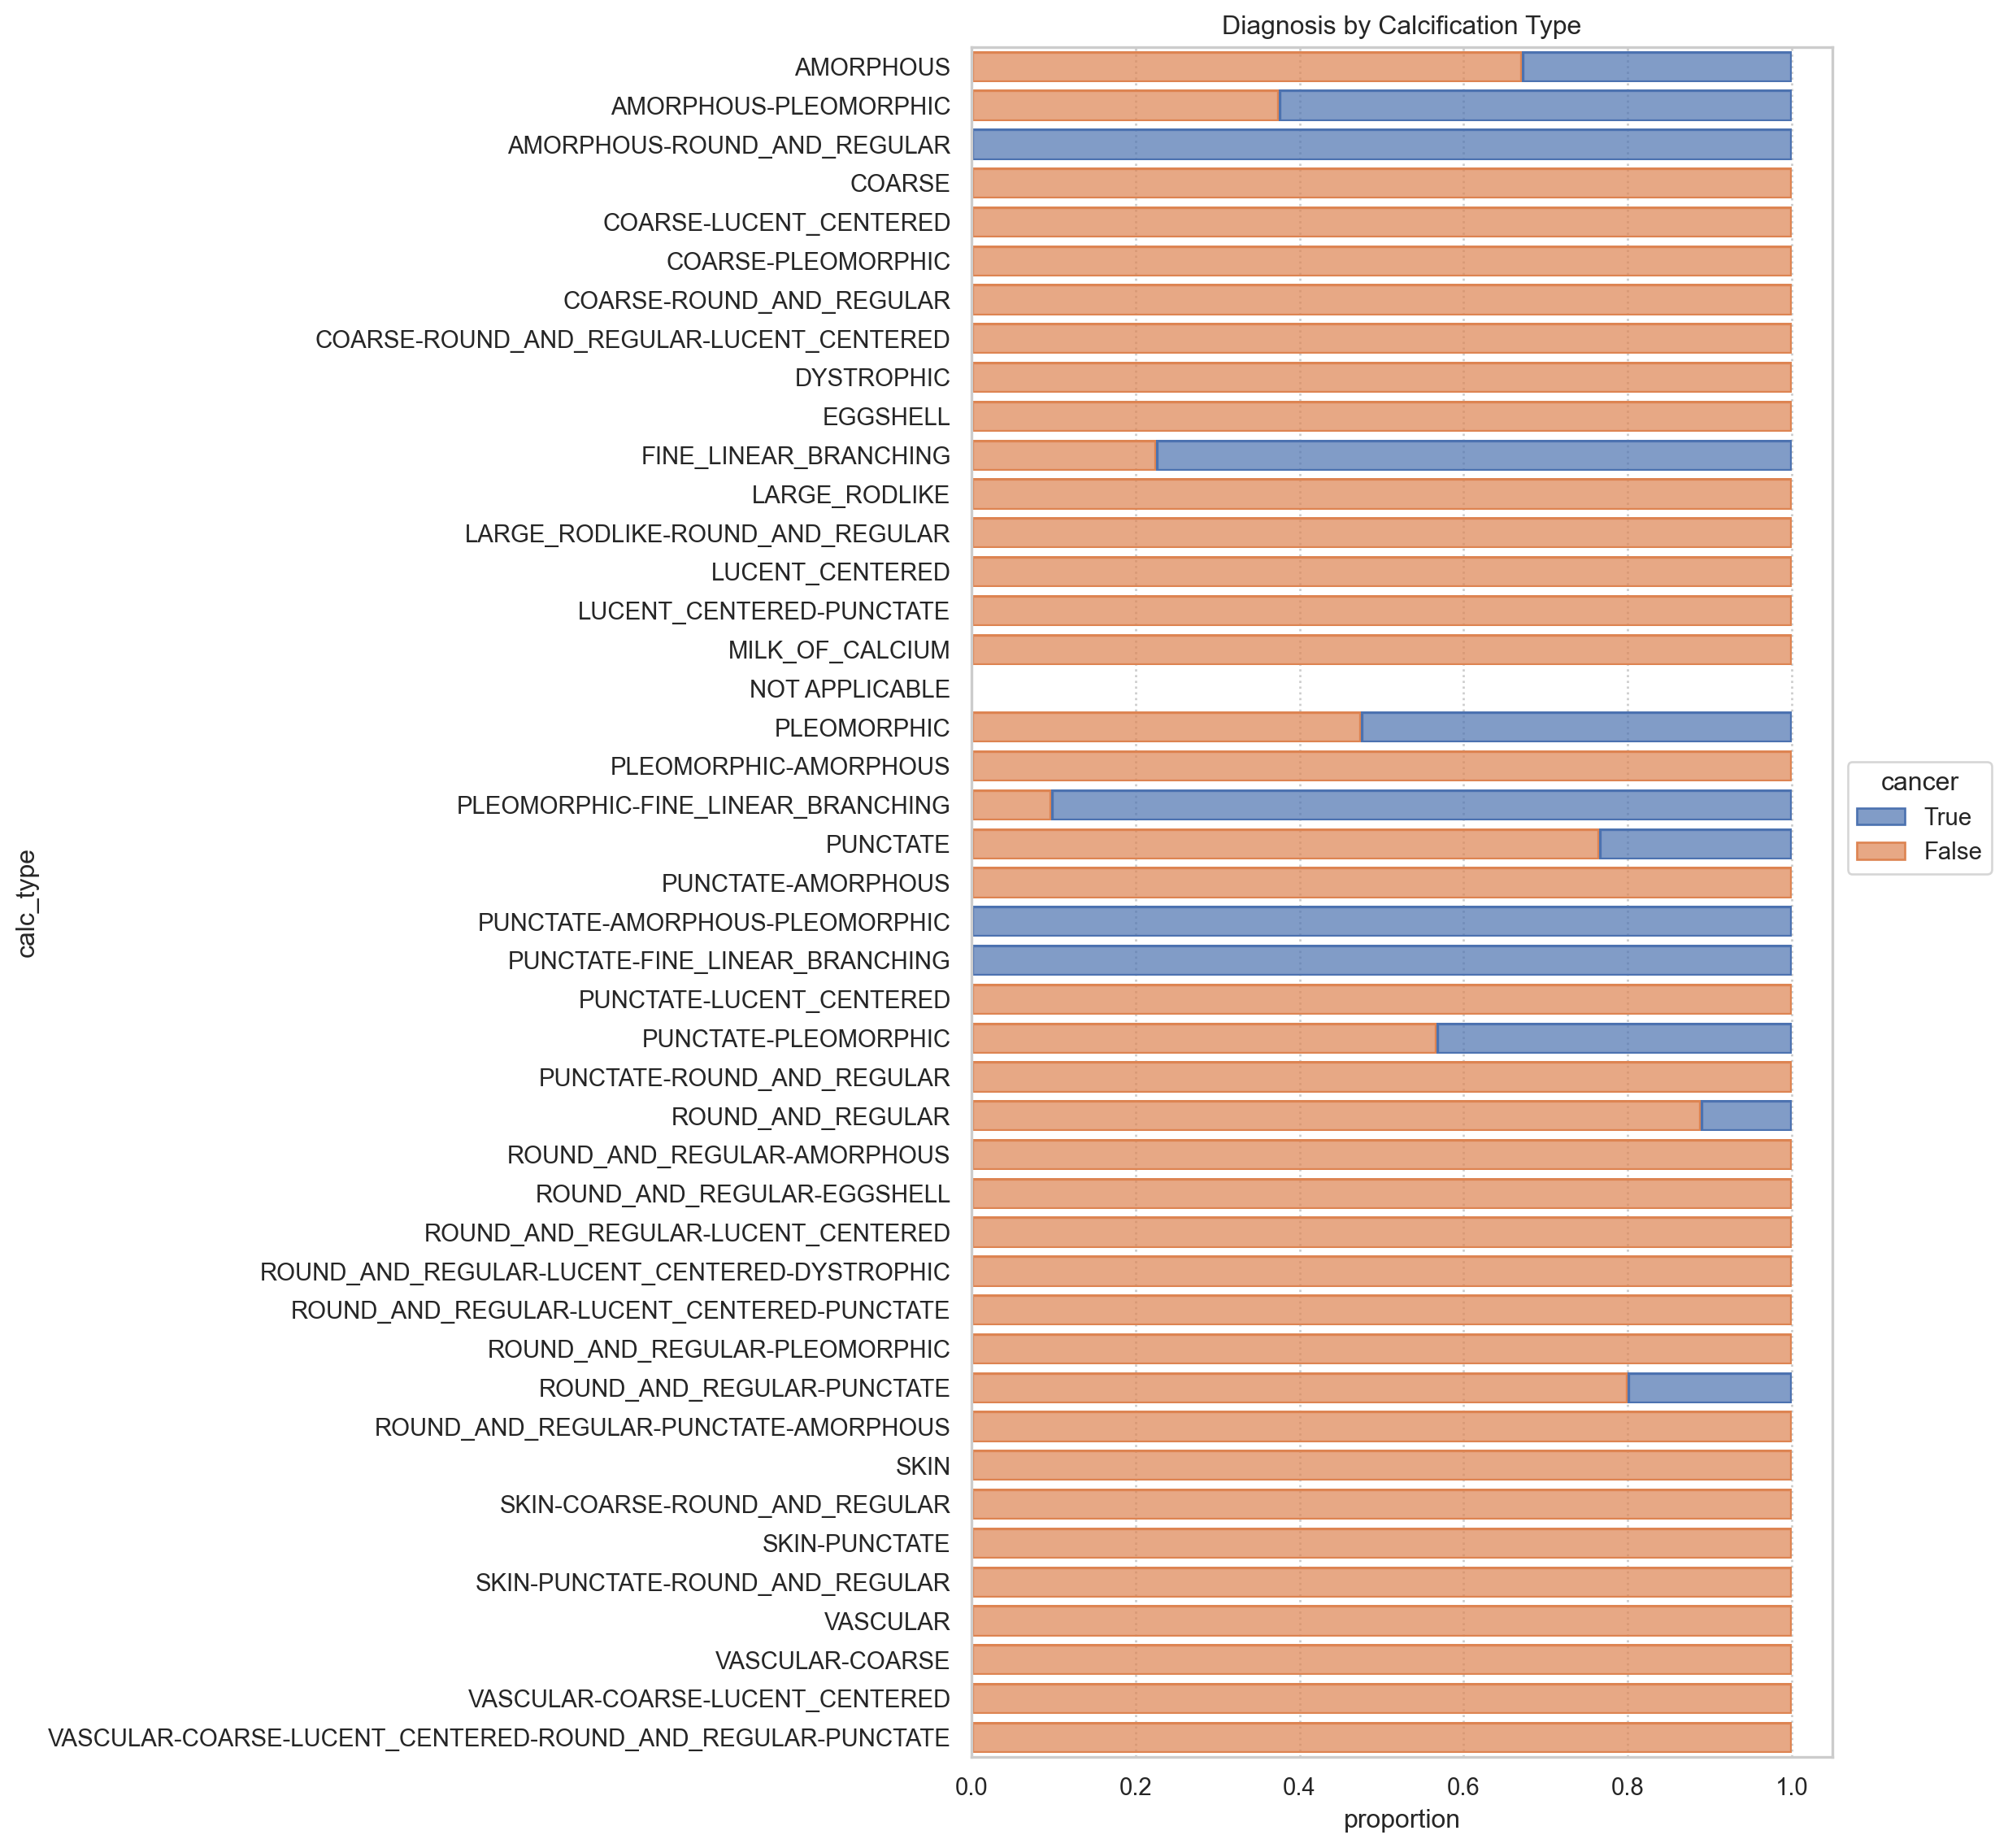

In [40]:
df_calc = calc.as_df()
prop = df_calc[['calc_type', 'cancer']].groupby(by=['calc_type']).value_counts(normalize=True).to_frame().reset_index().sort_values(by=['calc_type','cancer'])
sns.objects.Plot(prop, y='calc_type', x='proportion', color='cancer').add(so.Bar(), so.Stack()).theme({**sns.axes_style("whitegrid"), "grid.linestyle": ":"}).label(title="Diagnosis by Calcification Type").layout(size=(12,12), engine='tight')

As this plot suggests, an association between calcification type and diagnosis is extant. Let's check the strength of this association.

In [41]:
cv = calc.stats.cramersv(a='calc_type', b='cancer')
print(cv)



                            CramersV                            
                            Name | Cramer's V
                           Value | 0.5363368552127653
                          Pvalue | 2.078377585363777e-87
                           Alpha | 0.05
                        Strength | Large
                               A | calc_type
                               B | cancer
                               N | 1872
                             Dof | 1
                         X2alpha | 0.05
                              X2 | 538.4943200698192
                           X2dof | 42




This chi-square test of independence between calcification type and diagnosis indicates a significant association of large effect ($X^2$(1,n=1872)=539.69 p<0.01, $V$=0.54).

The following lists the top 10 most malignant calcification types by proportion in the CBIS-DDSM.

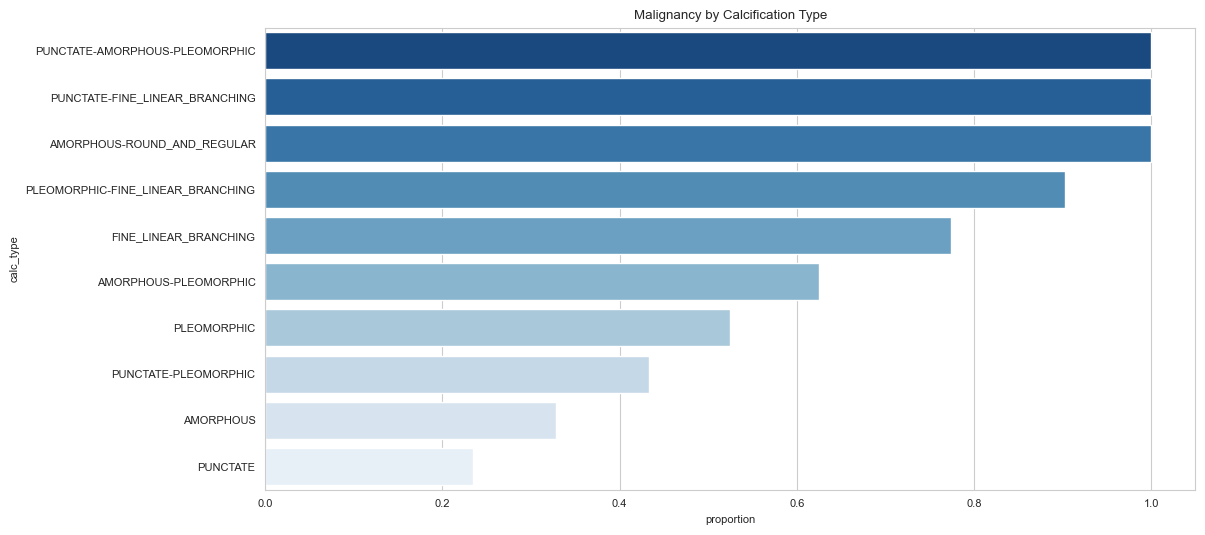

In [42]:
fig, ax = plt.subplots(figsize=(12,6))
calc_types = cases.get_most_malignant_calc(x='calc_type', n=10)
calc.plot.barplot(data=calc_types, y='calc_type', x='proportion', title='Malignancy by Calcification Type', ax=ax)

##### Calcification Distribution
How do we characterize the association between calcification distribution and malignancy?

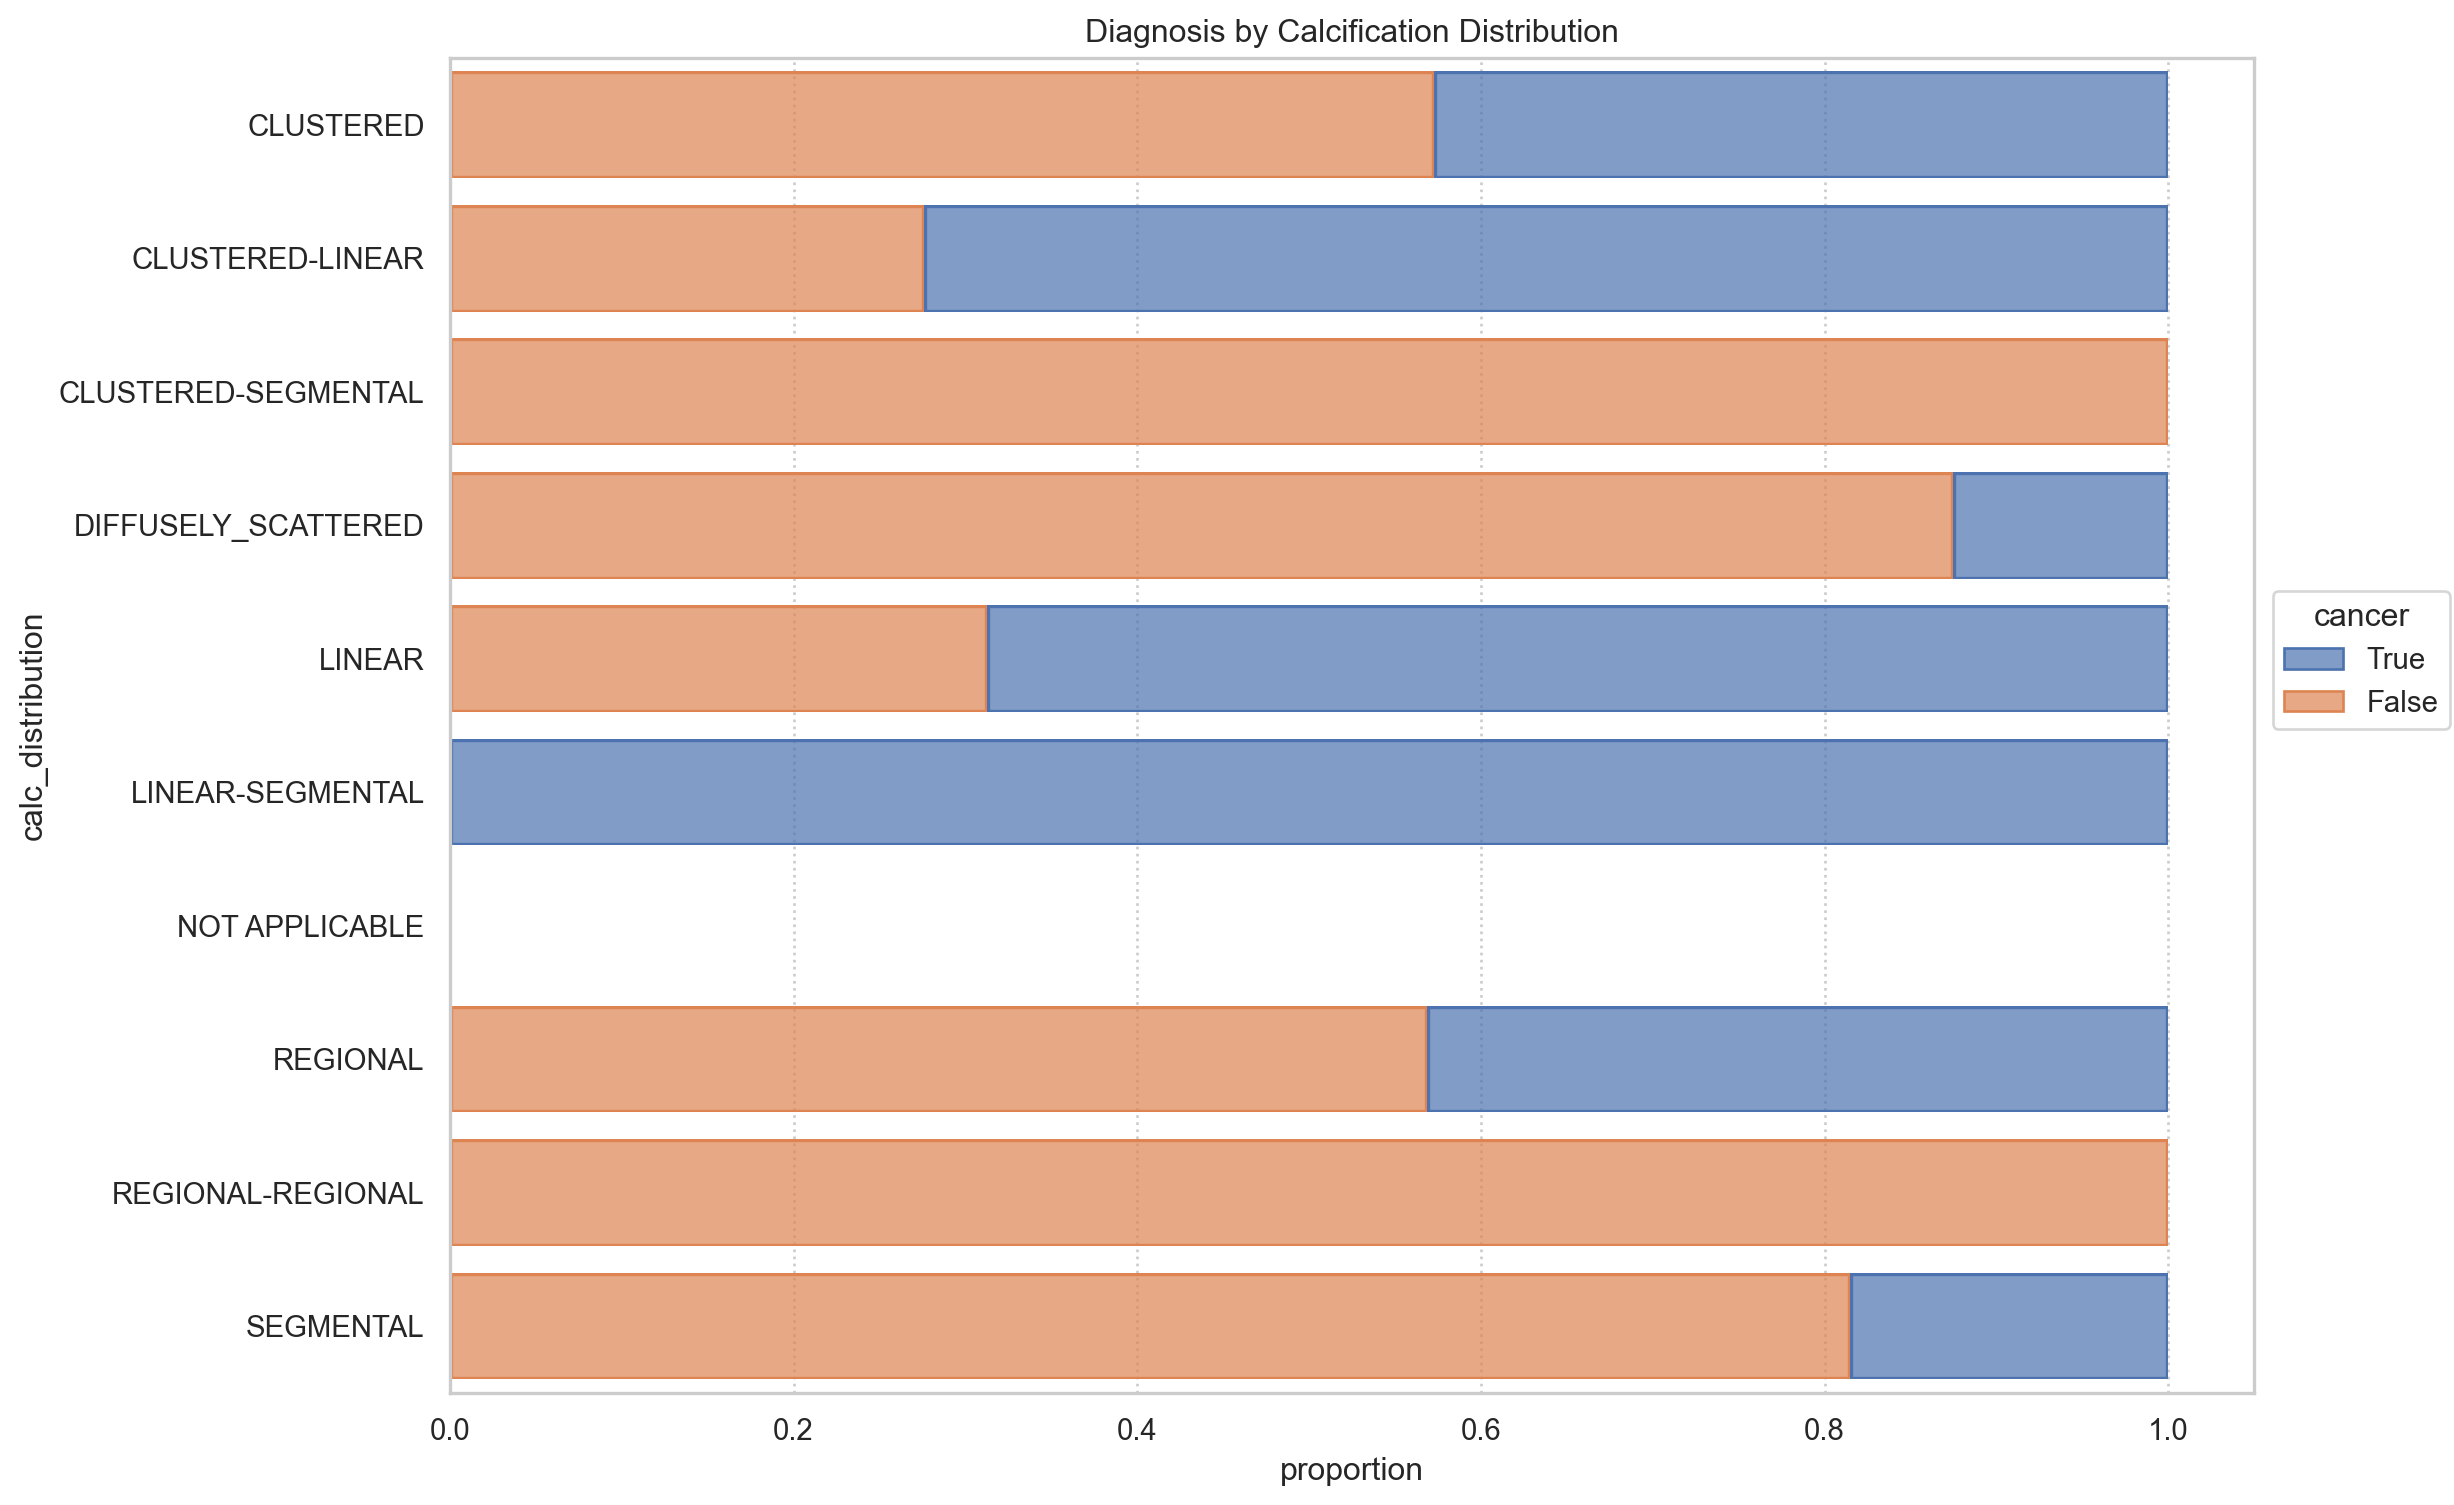

In [43]:
df_calc = calc.as_df()
prop = df_calc[['calc_distribution', 'cancer']].groupby(by=['calc_distribution']).value_counts(normalize=True).to_frame().reset_index().sort_values(by=['calc_distribution','cancer'])
sns.objects.Plot(prop, y='calc_distribution', x='proportion', color='cancer').add(so.Bar(), so.Stack()).theme({**sns.axes_style("whitegrid"), "grid.linestyle": ":"}).label(title="Diagnosis by Calcification Distribution").layout(size=(12,8), engine='tight')

Again, we see an association between calcification distribution and malignancy.  Let's check the most malignant calcification distributions.

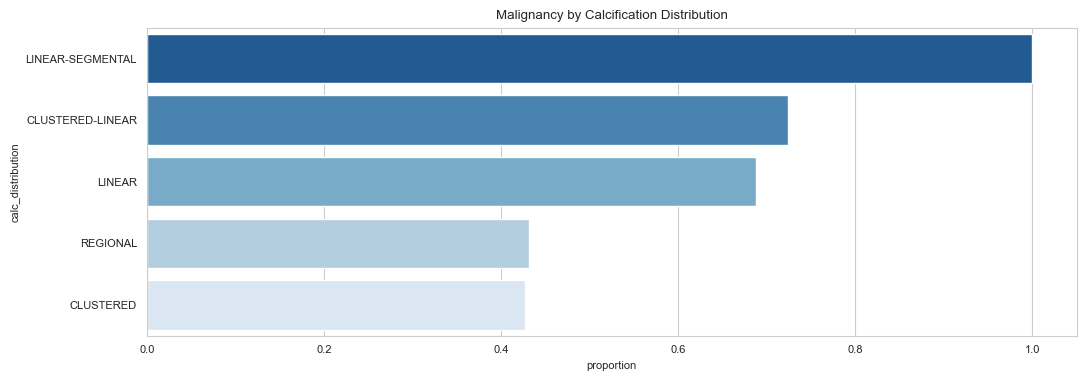

In [44]:
fig, ax = plt.subplots(figsize=(12,4))
calc_types = cases.get_most_malignant_calc(x='calc_distribution', n=5)
calc.plot.barplot(data=calc_types, y='calc_distribution', x='proportion', title='Malignancy by Calcification Distribution', ax=ax)

In [45]:
cv = calc.stats.cramersv(a='calc_distribution', b='cancer')
print(cv)



                            CramersV                            
                            Name | Cramer's V
                           Value | 0.32634130163729136
                          Pvalue | 8.693260459198279e-39
                           Alpha | 0.05
                        Strength | Moderate
                               A | calc_distribution
                               B | cancer
                               N | 1872
                             Dof | 1
                         X2alpha | 0.05
                              X2 | 199.36546372889003
                           X2dof | 8




This chi-square test of independence between calcification distribution and diagnosis indicates a moderate and significant association ($X^2$(1,n=1872)=198.56 p<0.01, $V$=0.33).

##### Mass Shape and Cancer
Mass shape and mass margins are the most significant features that indicate whether a mass is benign or malignant {cite}`bassettAbnormalMammogram2003`.

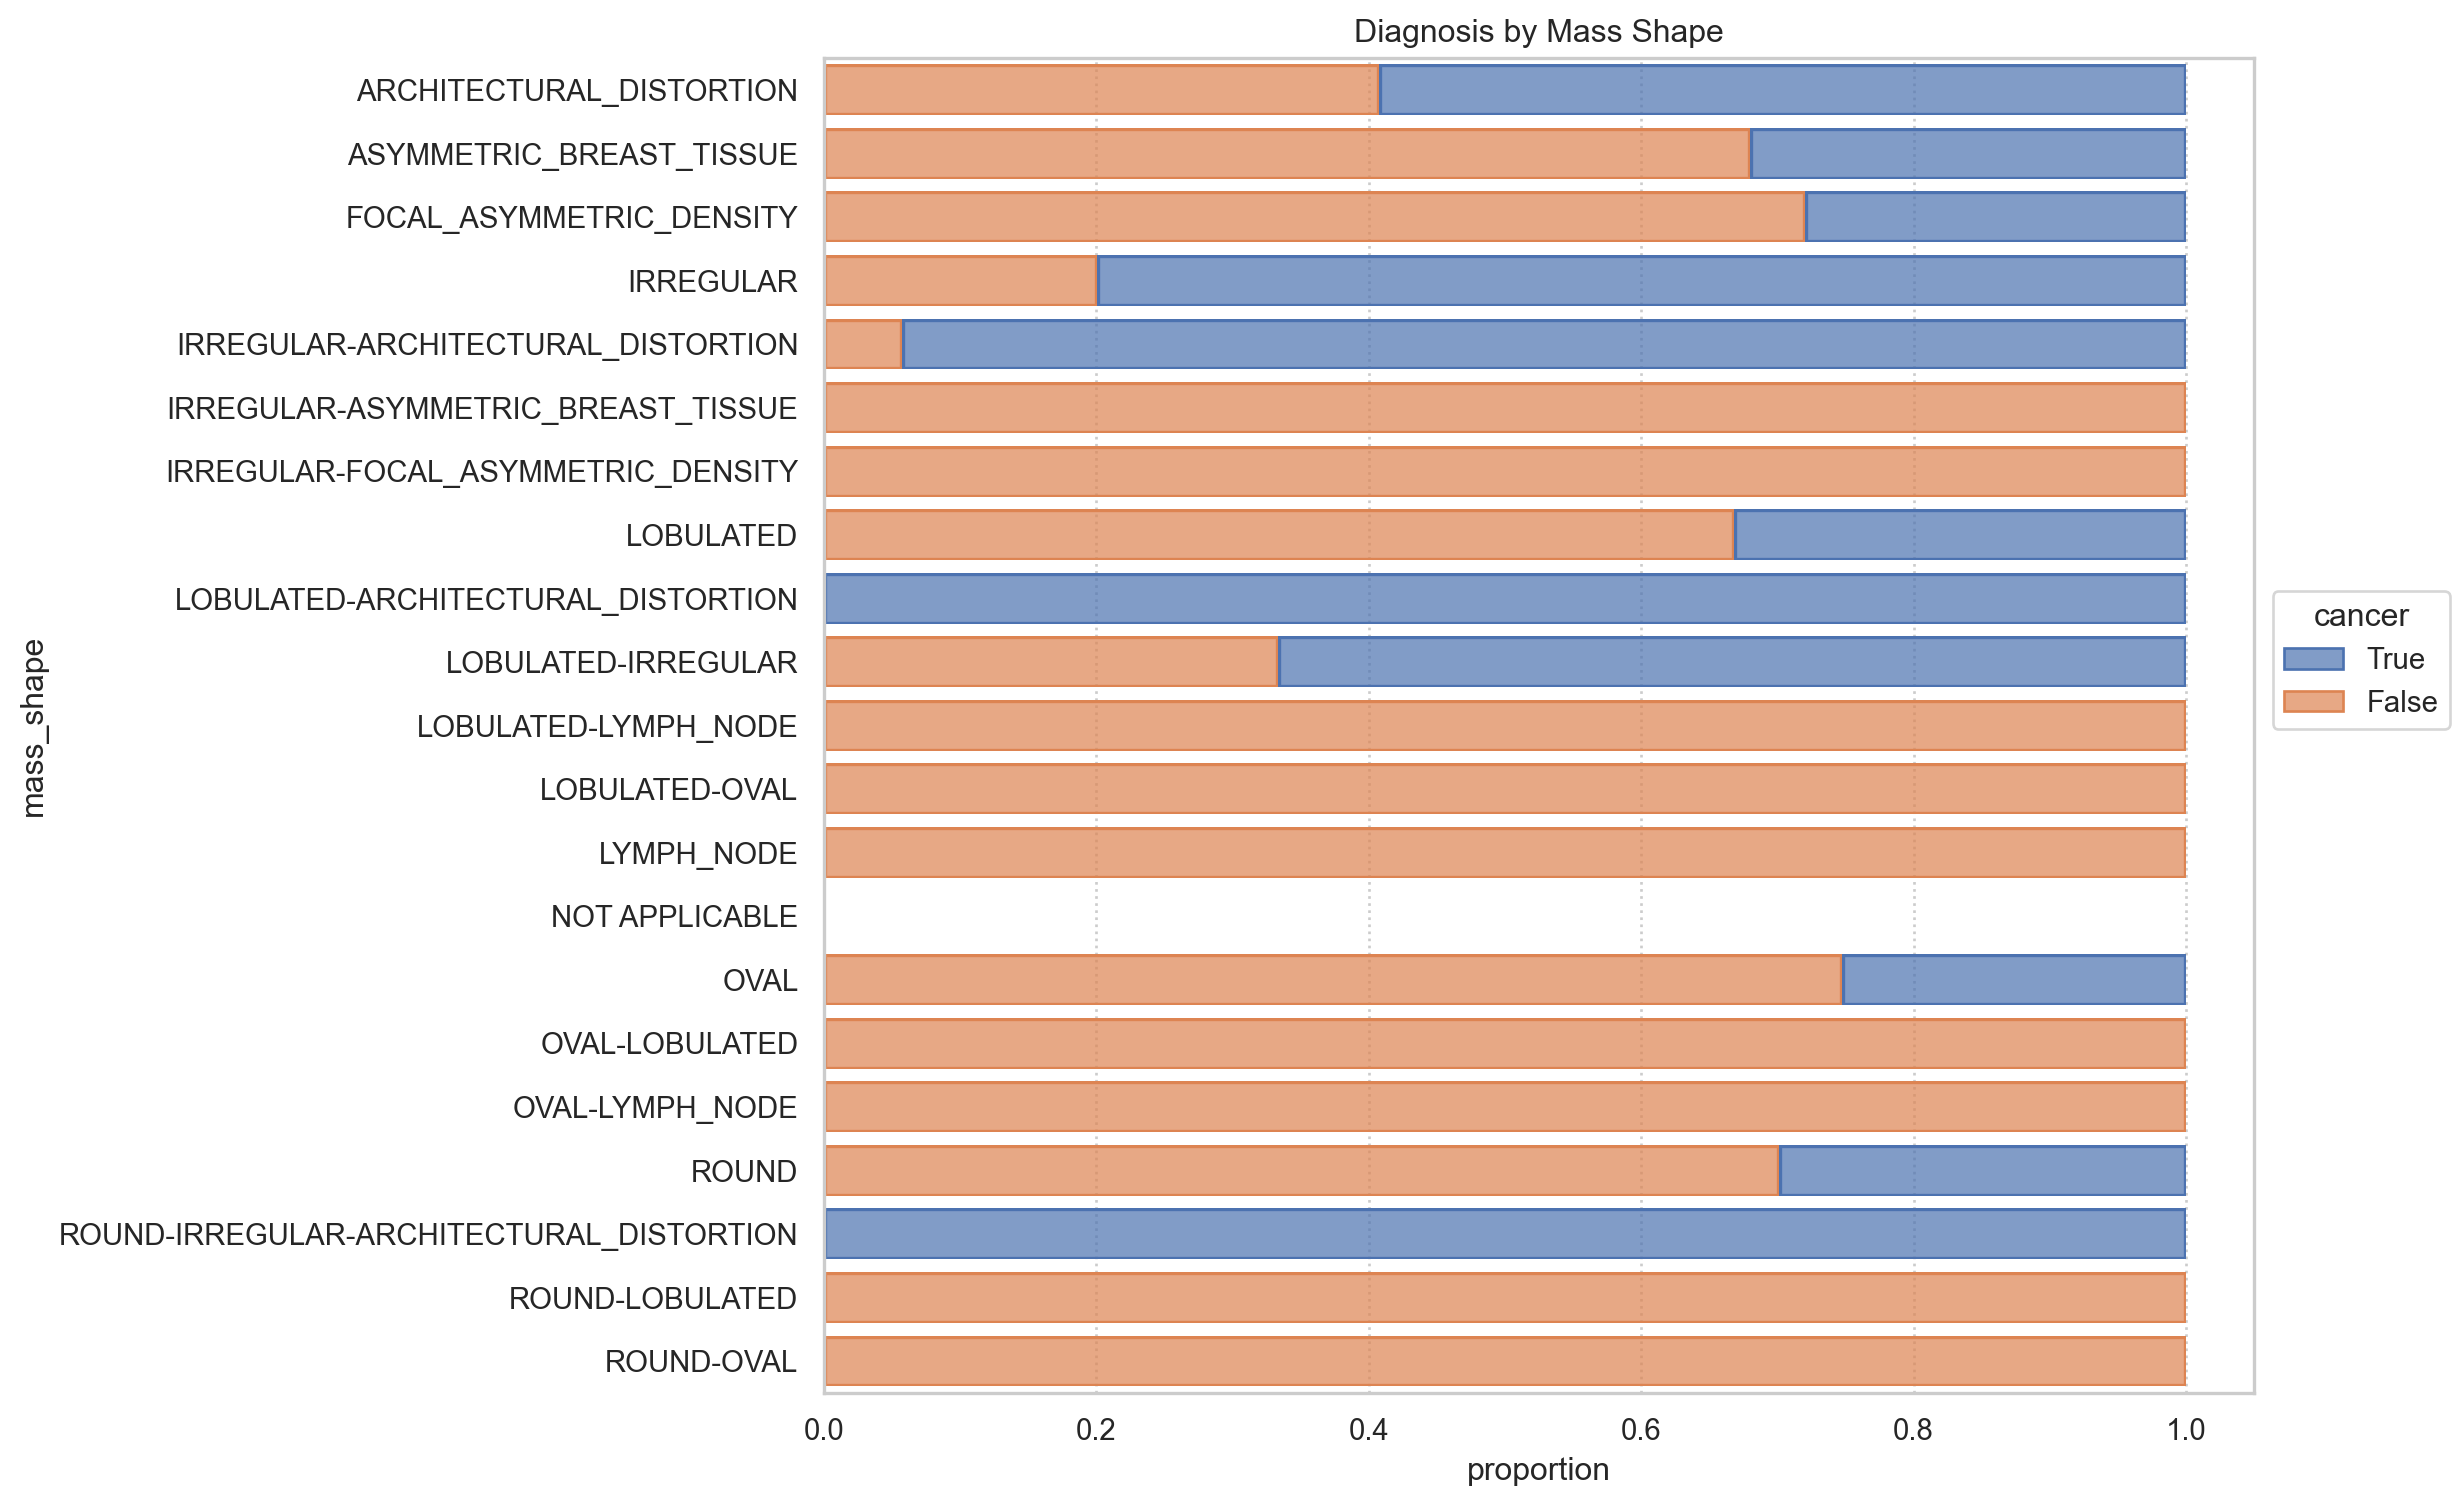

In [46]:
df_mass = mass.as_df()
prop = df_mass[['mass_shape', 'cancer']].groupby(by=['mass_shape']).value_counts(normalize=True).to_frame().reset_index().sort_values(by=['mass_shape','cancer'])
sns.objects.Plot(prop, y='mass_shape', x='proportion', color='cancer').add(so.Bar(), so.Stack()).theme({**sns.axes_style("whitegrid"), "grid.linestyle": ":"}).label(title="Diagnosis by Mass Shape").layout(size=(12,8), engine='tight')

As suggested, an association between mass shape and diagnosis is evident. Which mass shapes are most malignant?

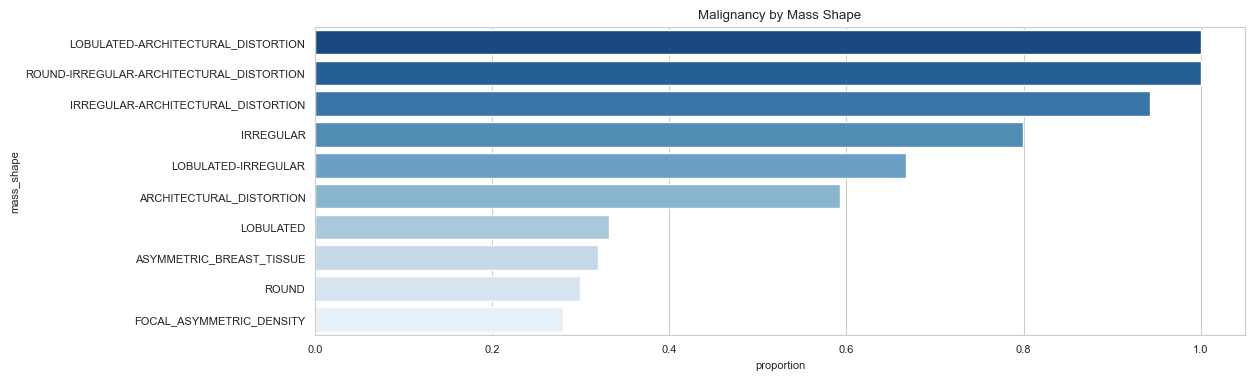

In [47]:
fig, ax = plt.subplots(figsize=(12,4))
mass_shapes = cases.get_most_malignant_mass(x='mass_shape', n=10)
mass.plot.barplot(data=mass_shapes, y='mass_shape', x='proportion', title='Malignancy by Mass Shape', ax=ax)

In [48]:
cv = mass.stats.cramersv(a='mass_shape', b='cancer')
print(cv)



                            CramersV                            
                            Name | Cramer's V
                           Value | 0.510182454781321
                          Pvalue | 1.297593104510473e-81
                           Alpha | 0.05
                        Strength | Large
                               A | mass_shape
                               B | cancer
                               N | 1694
                             Dof | 1
                         X2alpha | 0.05
                              X2 | 440.9247163603807
                           X2dof | 19




This chi-square test of independence between mass shape and diagnosis indicates a large and significant association ($X^2$(1,n=1694)=440.92 p<0.01, $V$=0.51).

##### Mass Margins and Cancer
Mass margins, a feature that separates the mass from the adjacent breast parenchyma, is often the feature which enables differentiation between benign and malignant.

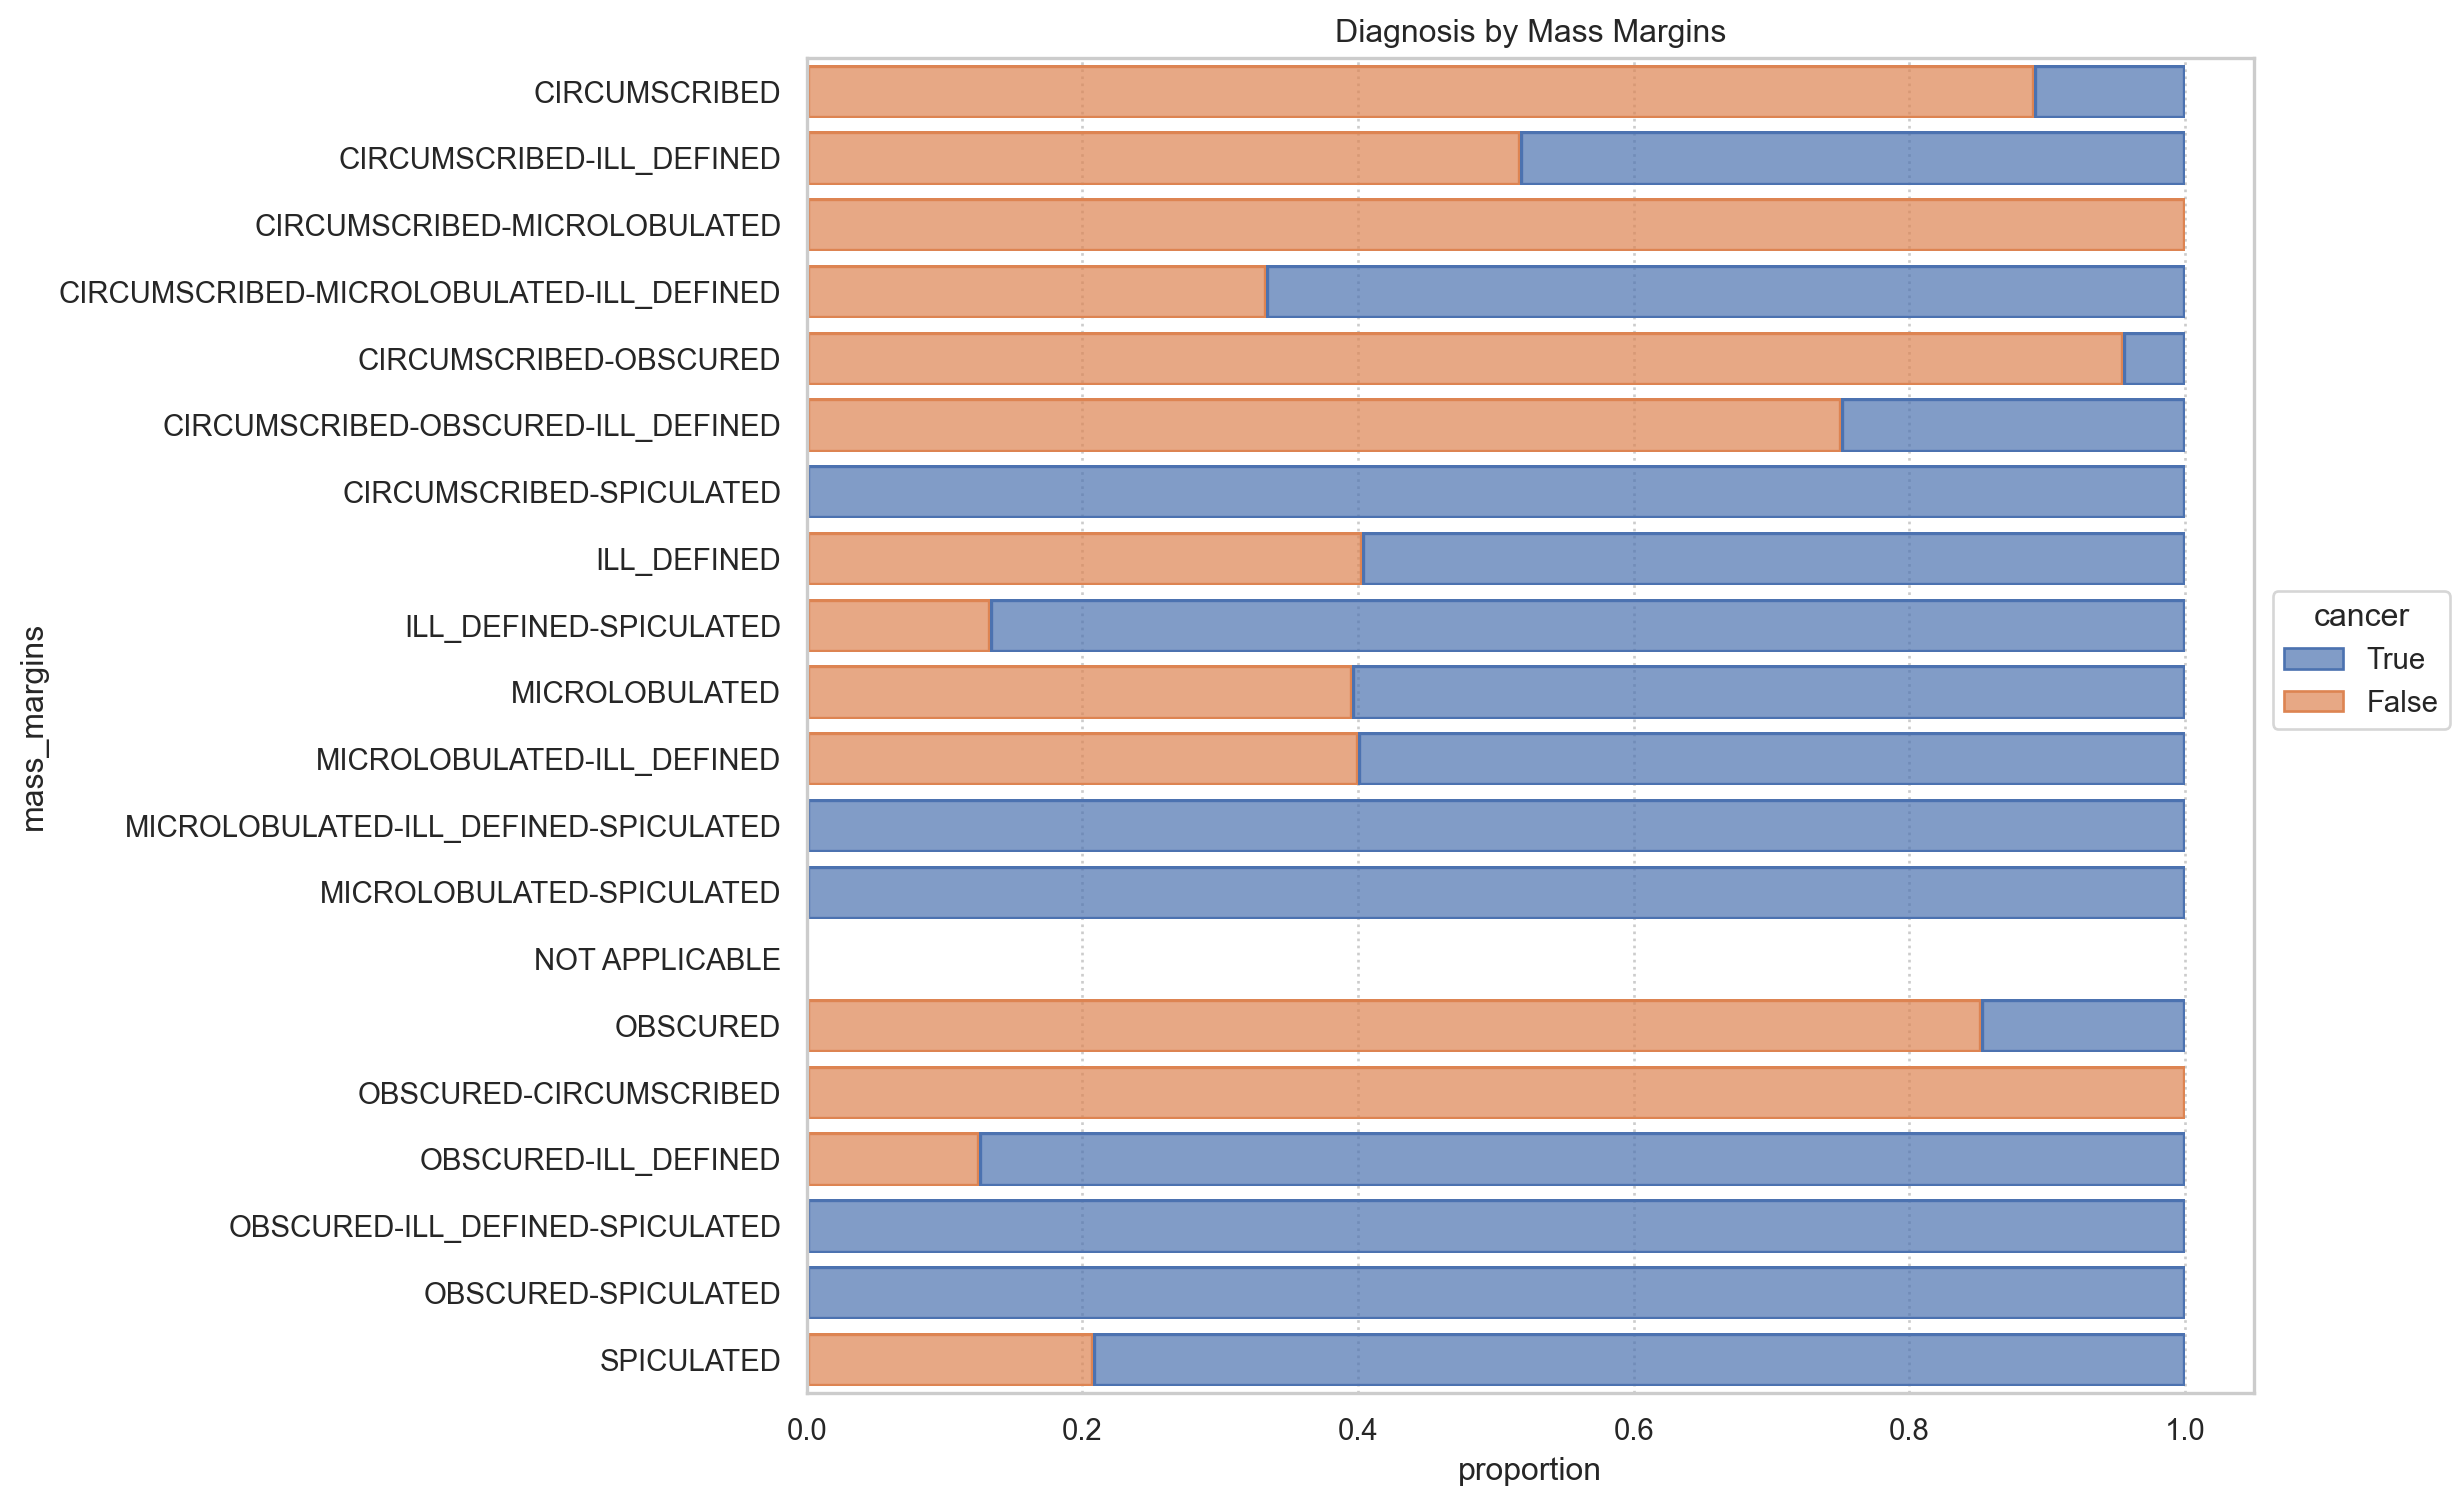

In [49]:
prop = df_mass[['mass_margins', 'cancer']].groupby(by=['mass_margins']).value_counts(normalize=True).to_frame().reset_index().sort_values(by=['mass_margins','cancer'])
sns.objects.Plot(prop, y='mass_margins', x='proportion', color='cancer').add(so.Bar(), so.Stack()).theme({**sns.axes_style("whitegrid"), "grid.linestyle": ":"}).label(title="Diagnosis by Mass Margins").layout(size=(12,8), engine='tight')

As expected, mass margins appear determinative. Which mass margins are most concerning?

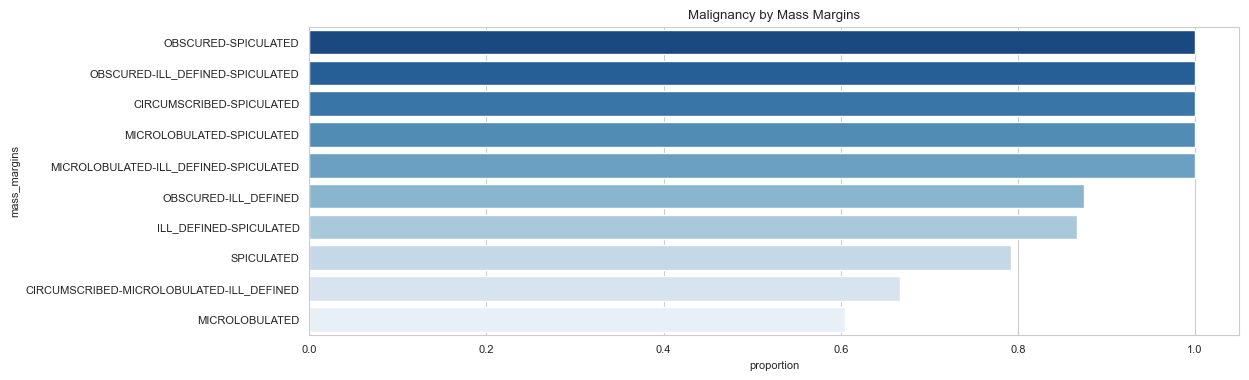

In [50]:
fig, ax = plt.subplots(figsize=(12,4))
mass_margins = cases.get_most_malignant_mass(x='mass_margins', n=10)
mass.plot.barplot(data=mass_margins, y='mass_margins', x='proportion', title='Malignancy by Mass Margins', ax=ax)

In [51]:
cv = mass.stats.cramersv(a='mass_margins', b='cancer')
print(cv)



                            CramersV                            
                            Name | Cramer's V
                           Value | 0.5894681913733985
                          Pvalue | 2.1871720584088994e-113
                           Alpha | 0.05
                        Strength | Large
                               A | mass_margins
                               B | cancer
                               N | 1694
                             Dof | 1
                         X2alpha | 0.05
                              X2 | 588.6188361978973
                           X2dof | 18




This chi-square test of independence between mass margins and diagnosis indicates a large and significant association ($X^2$(1,n=1694)=588.62 p<0.01, $V$=0.59).

That concludes the target association section of the bivariate analysis. Let's examine the relationships among the features.

#### Case Bivariate Feature Association Analysis
What does calcification type imply about calcification distribution? To what degree is mass shape and mass margin related? Are certain morphologies more or less subtle? In this section, we examine the strength of associations among the features in the CBIS-DDSM using Cramer's V effect size measurement. For this exercise, we'll interpret the Cramer's V effect sizes as follows:

|      V      |   Effect   |
|:-----------:|:----------:|
|    ≥ 0.5    |    Large   |
| ≥ 0.3 < 0.5 |  Moderate  |
| ≥ 0.1 < 0.3 |    Small   |
|   0 < 0.1   | Negligible |

We'll start with the full dataset, to investigate the relationships between non-morphological features. Then, we'll analyze mass and calcification cases separately to avoid in spurious associations across abnormality types.

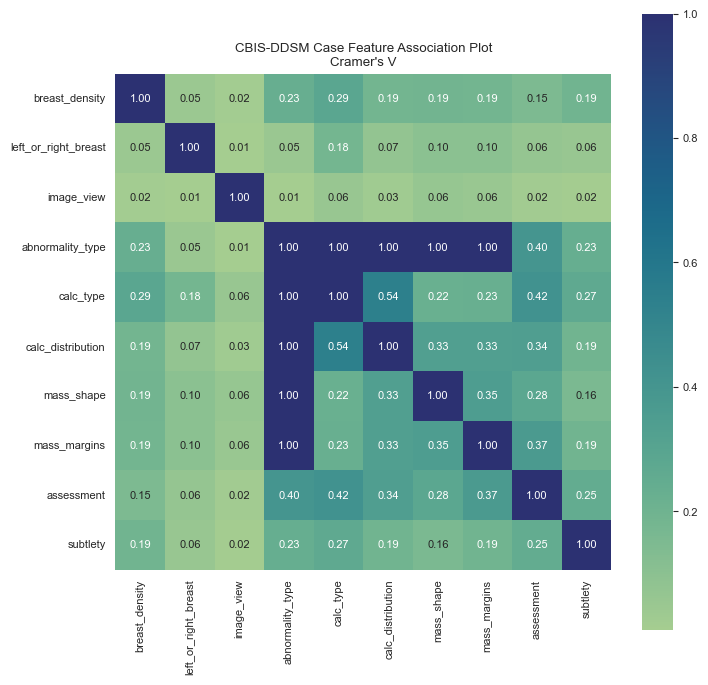

In [52]:
fig, ax = plt.subplots(figsize=(8,8))
cases.plot_feature_associations(ax=ax)

We'll ignore abnormality type and the morphology associationss for now. Calcification and mass morphology associations will be analyzed separately. That said, several observations can be made:
1. Abnormality type has a moderate association with BI-RADS assessment. 
2. There appears to be weak associations among the non-morphological features.

Let's take a look breast density vis-a-vis abnormality type.

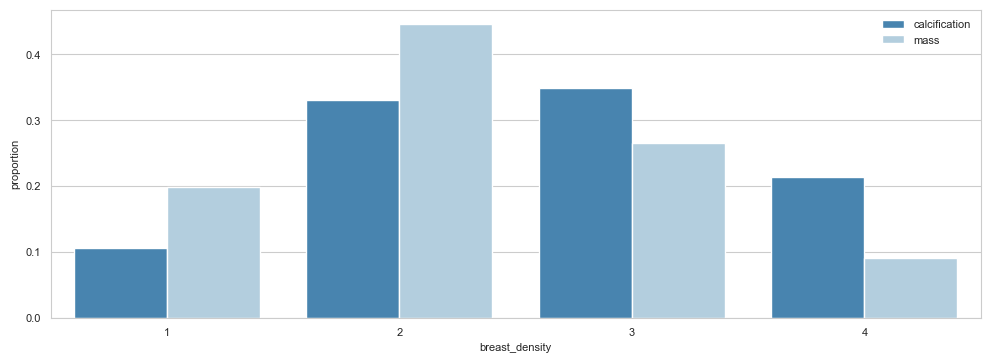

In [53]:
fig, ax = plt.subplots(figsize=(12,4))
df = cases.as_df()
df_props = df[['abnormality_type', 'breast_density']].groupby(by=['abnormality_type']).value_counts(normalize=True, sort=False).to_frame().reset_index()
cases.plot.barplot(data=df_props, x='breast_density', y='proportion', hue='abnormality_type', ax=ax)

Abnormality types tends to behave similarly across breast density categories, thus the weak association.

##### Calcification Feature Bivariate Analysis
Let's examine the relationships among the features among the calcification cases.

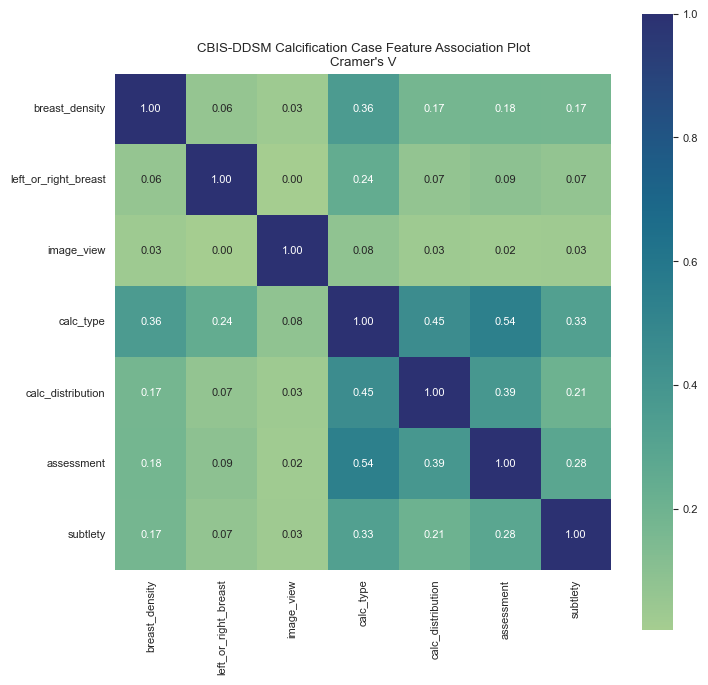

In [54]:
fig, ax = plt.subplots(figsize=(8,8))
calc.plot_calc_feature_associations(ax=ax)

The moderate to strong associations of note are:
- Calcification Type and BI-RADS assessment (0.54) 
- Calcification Type and Distribution (0.45)
- Calcification Distribution and BI-RADS assessment (0.39)
- Breast Density and Calcification Type (0.36)
- Calcification Type and Subtlety (0.33)

Let's visualize these relationships and assess their statistical significance.

###### Calcification Type and Assessment

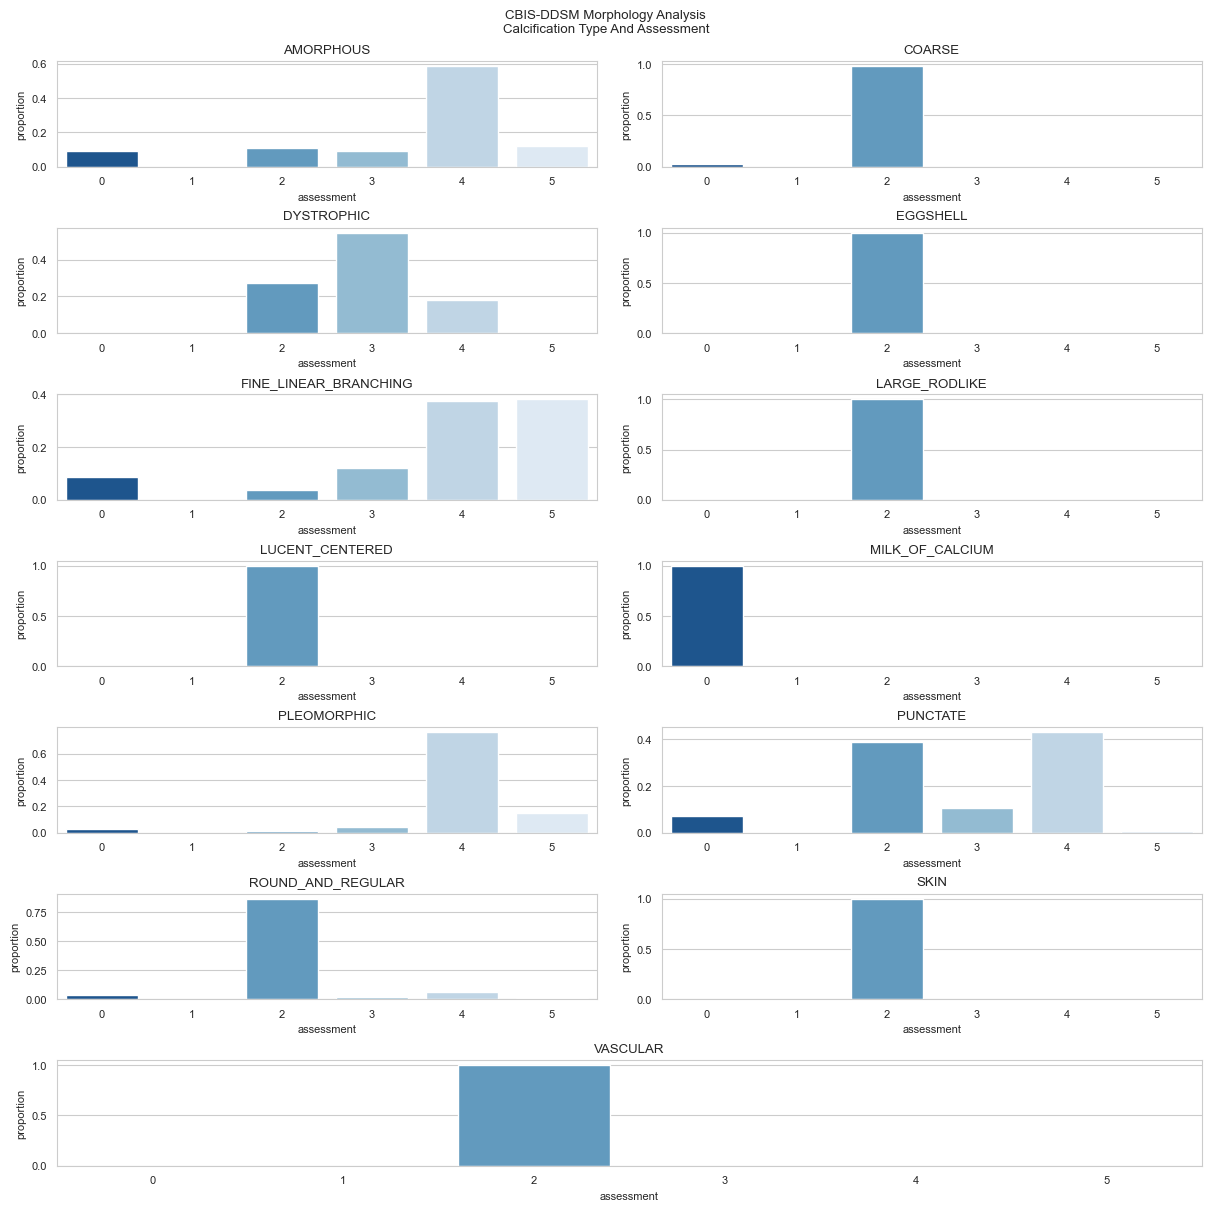

In [55]:
_ = cases.summarize_morphology_by_feature(morphology='calc_type', by='assessment', figsize=(12,12))

Above, we show the proportion of BI-RADS assessments for each calcification type. Pleomorphic, fine linear branching and amorphous calcifications appear to render the highest levels of suspicion with BI-RADS 4 and 5 assessments. Those of intermediate concern are dystrophic and punctate. The remaining are associated with generally benign classifications.

There is a strong association between calcification type and BI-RADS assessment, but is it a statistically significant finding?

In [56]:
cv = calc.stats.cramersv(a='calc_type', b='assessment')
print(cv)



                            CramersV                            
                            Name | Cramer's V
                           Value | 0.5399745903685791
                          Pvalue | 0.0
                           Alpha | 0.05
                        Strength | Large
                               A | calc_type
                               B | assessment
                               N | 1872
                             Dof | 4
                         X2alpha | 0.05
                              X2 | 2183.2953161289365
                           X2dof | 168




Indeed, the result is signficant ($X^2$(4,n=1872)=2183.62 p<0.01, $V$=0.54).

In the prior section, we separated compound calcification types into separate categories; thereby, reducing the number of calcification types from 40 to 13. Let's examine the relationship between these calcification types and assessment.

###### Calcification Type and Calcification Distribution

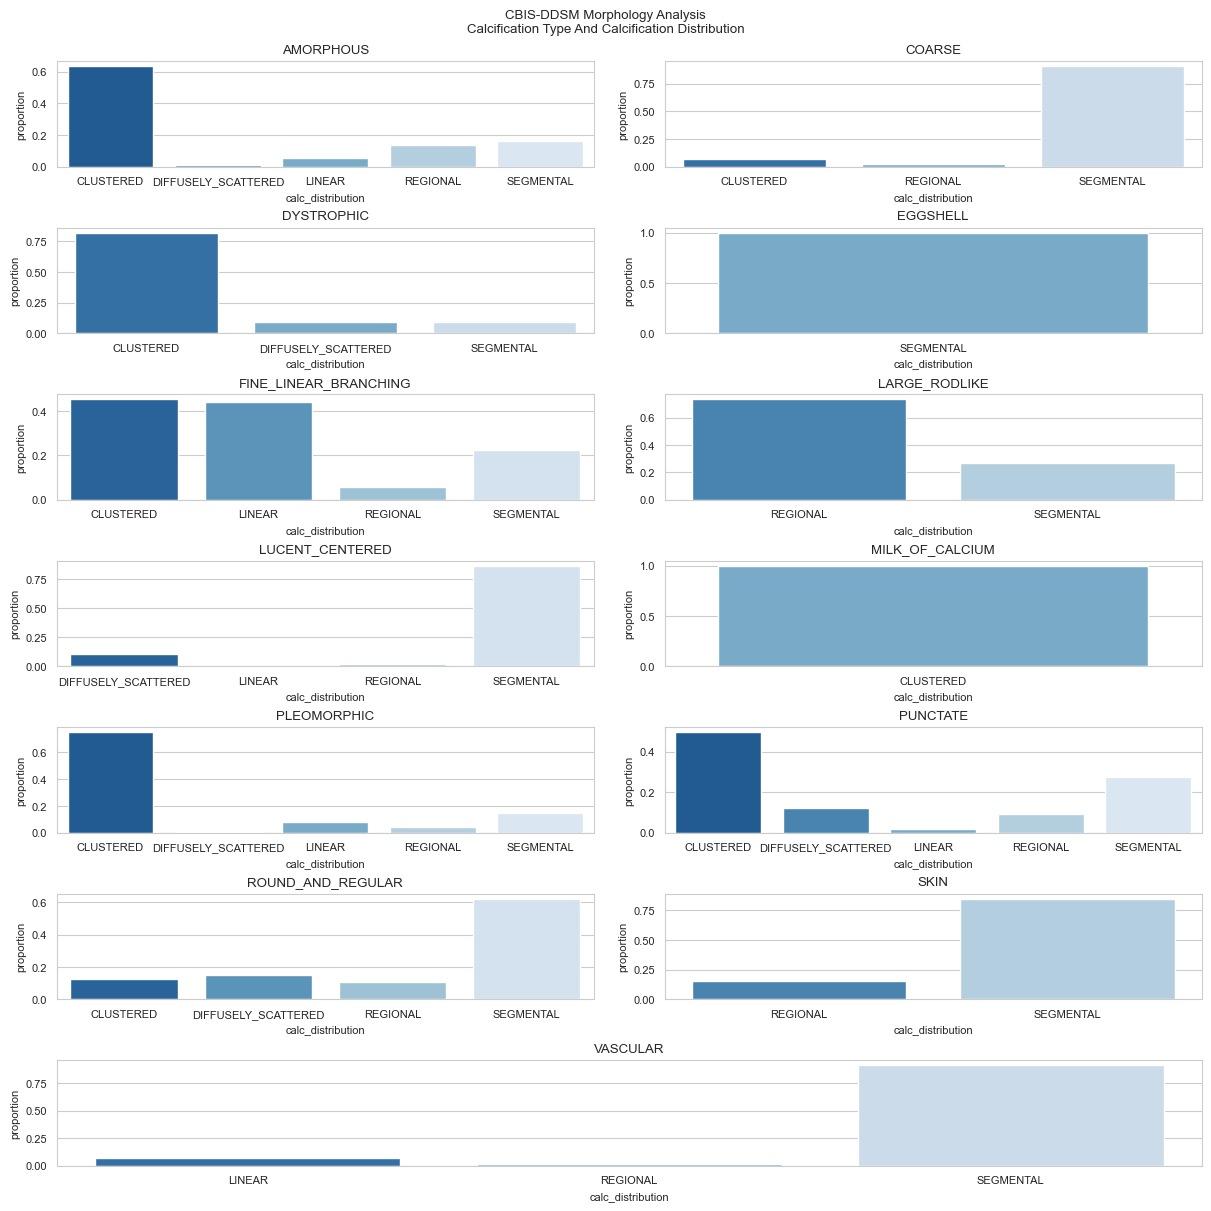

In [57]:
_ = cases.compare_morphology(m1='calc_type', m2='calc_distribution', figsize=(12,12))

For each calcification type, we show the calcification distributions by proportion of calcification type cases in which they co-occur. For instance, amorphous types tend to co-occur with clustered distributions. Eggshell calcifications appear exclusively with segmental distributions in the CBIS-DDSM.  Let's check the statistical signficance.

In [58]:
cv = calc.stats.cramersv(a='calc_type', b='calc_distribution')
print(cv)



                            CramersV                            
                            Name | Cramer's V
                           Value | 0.45403619931007766
                          Pvalue | 0.0
                           Alpha | 0.05
                        Strength | Large
                               A | calc_type
                               B | calc_distribution
                               N | 1872
                             Dof | 8
                         X2alpha | 0.05
                              X2 | 3087.2854813722943
                           X2dof | 336




Again, we observe a statistically significant large association between calcification type and distribution ($X^2$(8,n=1872)=3087.3 p<0.01, $V$=0.45).

###### Calcification Type and Subtlety

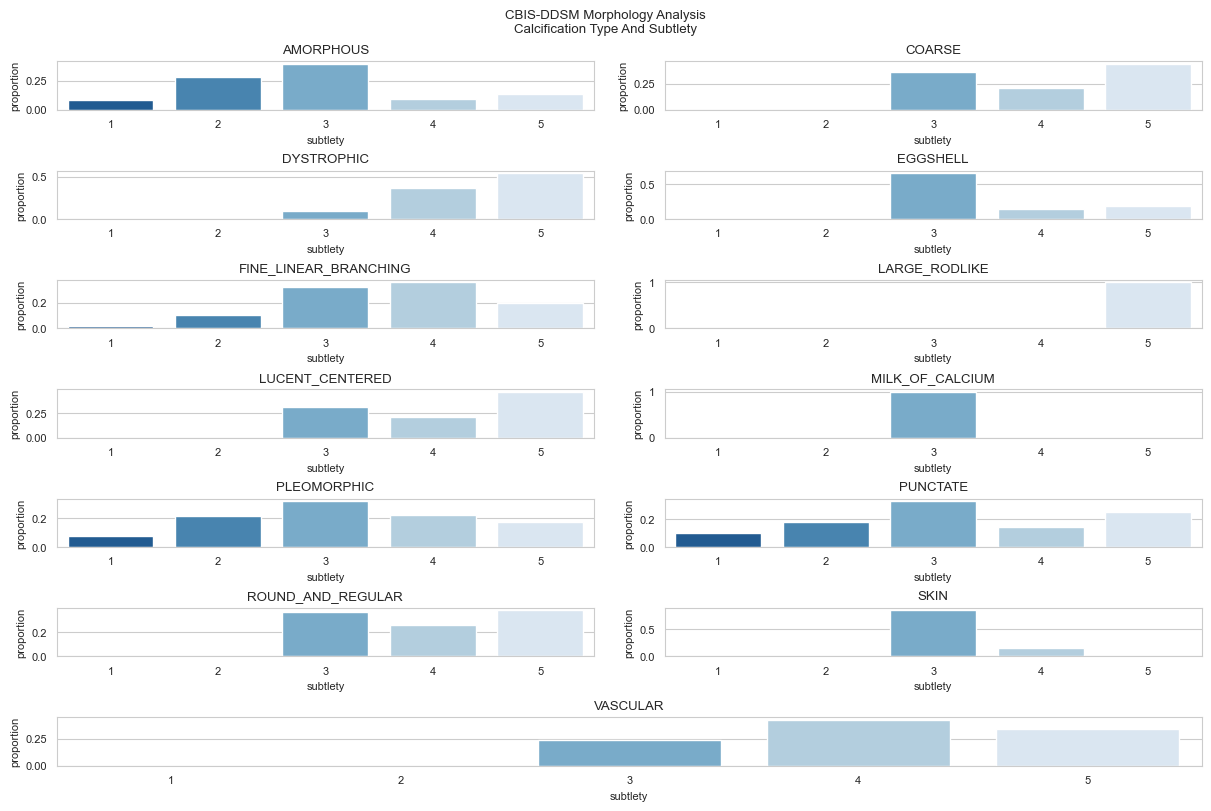

In [59]:
_ = cases.summarize_morphology_by_feature(morphology='calc_type', by='subtlety')

Here, we see that dystrophic, course, large_rodlike, lucent_centered, and round and regular calcifications present less conspicuously than the others.

In [60]:
cv = calc.stats.cramersv(a='calc_type', b='subtlety')
print(cv)



                            CramersV                            
                            Name | Cramer's V
                           Value | 0.32542688359496785
                          Pvalue | 9.164653782848766e-82
                           Alpha | 0.05
                        Strength | Large
                               A | calc_type
                               B | subtlety
                               N | 1872
                             Dof | 4
                         X2alpha | 0.05
                              X2 | 792.9990923686997
                           X2dof | 168




Calcification type and subtlety are strongly related ($X^2$(4,n=1872)=793 p<0.01, $V$=0.33).

###### Calcification Distribution and BI-RADS Assessment

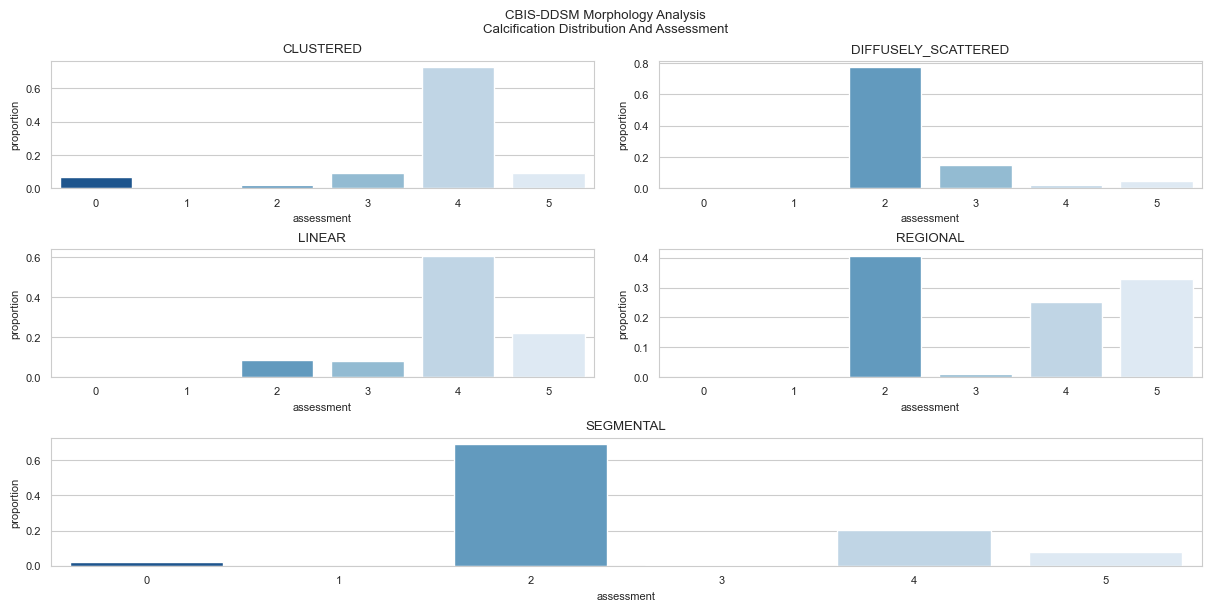

In [61]:
_ = cases.summarize_morphology_by_feature(morphology='calc_distribution', by='assessment', figsize=(12,6))

Clustered and linear calcification distributions tend to be suspicious with assessments in the BI-RADS 4 range. Regional distributions can indicate anything from benign to highly suspicious. Diffusely scattered and segmental distributions are primarily considered benign in the CBIS-DDSM.

In [62]:
cv = calc.stats.cramersv(a='calc_distribution', b='assessment')
print(cv)



                            CramersV                            
                            Name | Cramer's V
                           Value | 0.38789958530499524
                          Pvalue | 3.1562872500601785e-216
                           Alpha | 0.05
                        Strength | Large
                               A | calc_distribution
                               B | assessment
                               N | 1872
                             Dof | 4
                         X2alpha | 0.05
                              X2 | 1126.690069039047
                           X2dof | 32




Calcification distribution and BI-RADS assessment are strongly related ($X^2$(4,n=1872)=1127 p<0.01, $V$=0.39).

###### Calcification Type and Breast Density

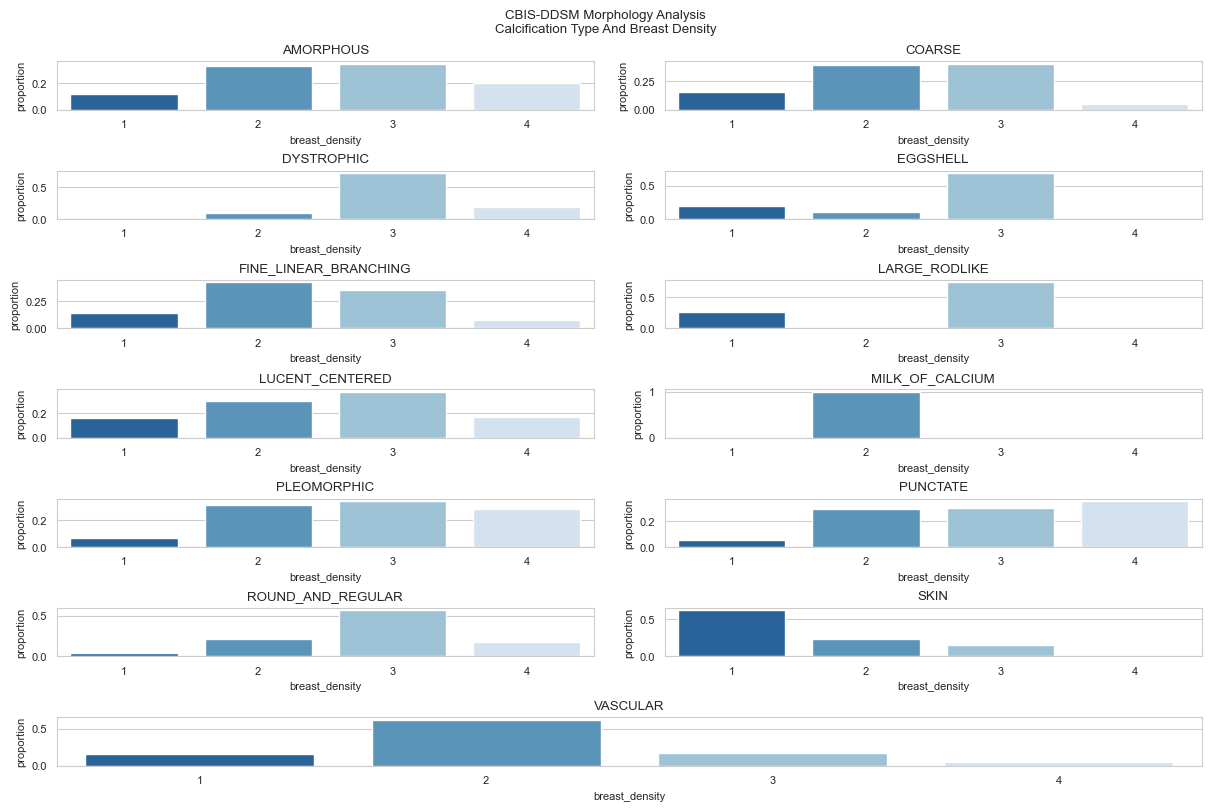

In [63]:
_ = cases.summarize_morphology_by_feature(morphology='calc_type', by='breast_density', figsize=(12,8))

Amorphous, course, fine linear branching, lucent centered, and pleomorphic almost follow a normal distribution. Some cases have fatty breasts, some extremely dense; but, most are in the middle categories 2 and 3. Eggshell, large rodlike, milk of calcium, skin, and vascular types stand out as co-occuring with breasts of specific densities.

In [64]:
cv = calc.stats.cramersv(a='breast_density', b='calc_type')
print(cv)



                            CramersV                            
                            Name | Cramer's V
                           Value | 0.3552474787413507
                          Pvalue | 5.624419427603362e-82
                           Alpha | 0.05
                        Strength | Large
                               A | breast_density
                               B | calc_type
                               N | 1872
                             Dof | 3
                         X2alpha | 0.05
                              X2 | 708.7435307901172
                           X2dof | 126




Again, we obsere a strong association between calcification type and breast density ($X^2$(3,n=1872)=709 p<0.01, $V$=0.36).

##### Mass Feature Bivariate Analysis
Next, let's examine feature relationships for mass cases.

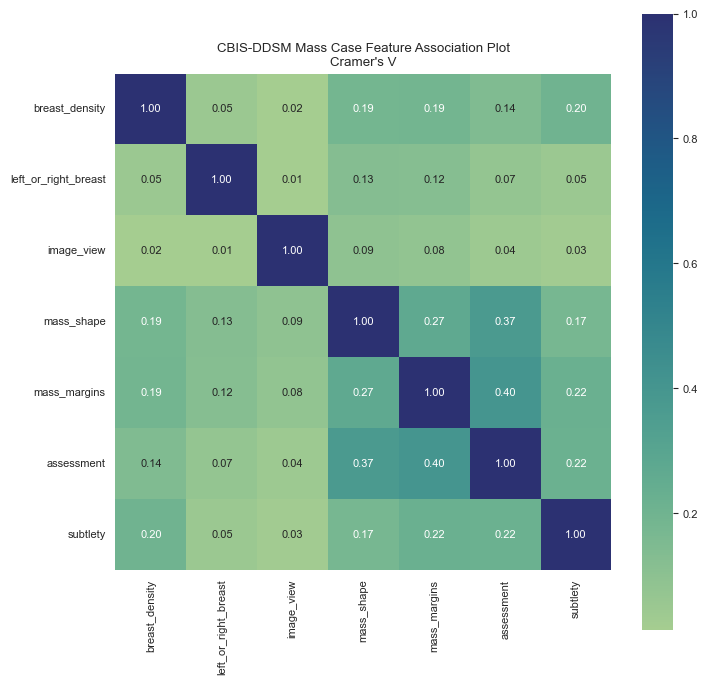

In [65]:
fig, ax = plt.subplots(figsize=(8,8))
mass.plot_mass_feature_associations(ax=ax)

Here, we have the following moderate to strong associations within the mass dataset:
- Mass Margin and BI-RADS Assesment (0.40)
- Mass Shape and BI-RADS Assesment (0.37)

It's notable that mass shape and mass margins are weakly associated.

###### Mass Margins and BI-RADS Assessment

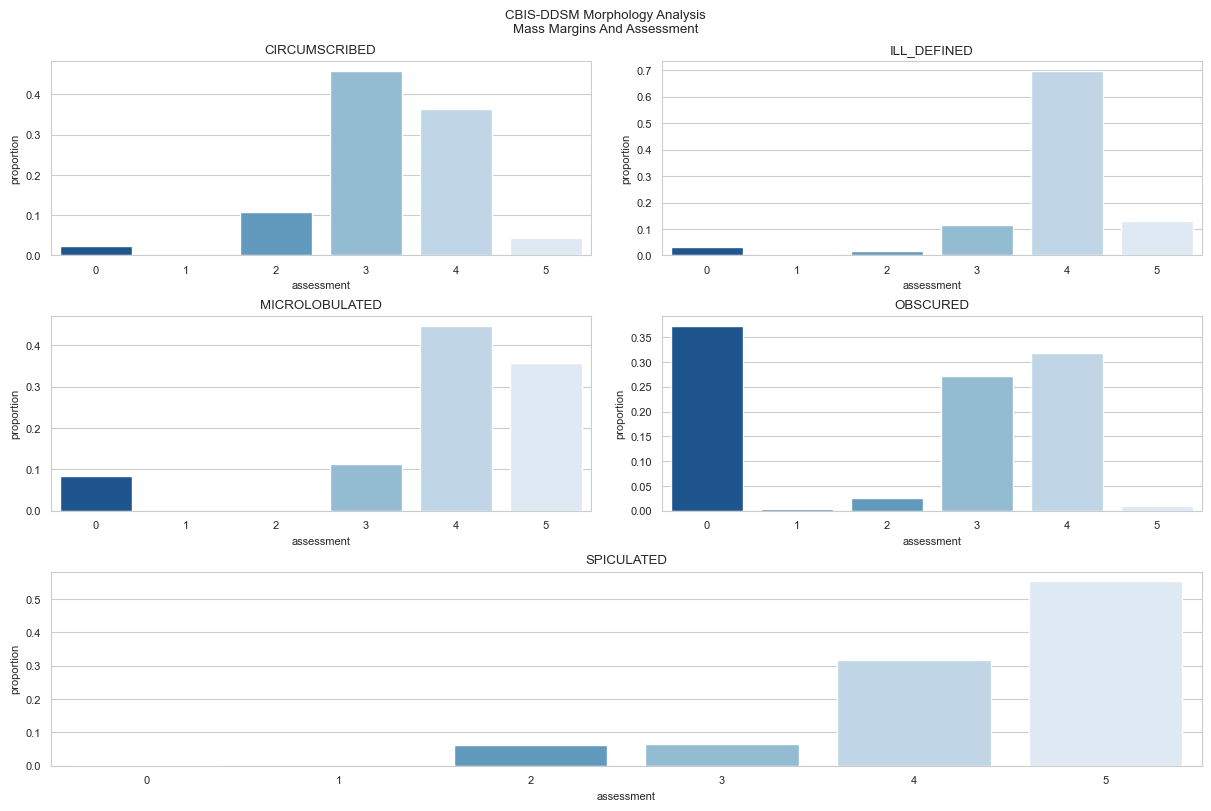

In [66]:
_ = cases.summarize_morphology_by_feature(morphology='mass_margins', by='assessment', figsize=(12,8))

Spiculated, ill-defined, and microlobulated masses appear to be of greater concern than obscured, and perhaps circumscribed mass margins.

In [67]:
cv = mass.stats.cramersv(a='mass_margins', b='assessment')
print(cv)



                            CramersV                            
                            Name | Cramer's V
                           Value | 0.40037910751937816
                          Pvalue | 2.3306037914870686e-225
                           Alpha | 0.05
                        Strength | Large
                               A | mass_margins
                               B | assessment
                               N | 1694
                             Dof | 5
                         X2alpha | 0.05
                              X2 | 1357.7700498809766
                           X2dof | 90




The relationship between mass margins and BI-RADS assessment is strong ($X^2$(5,n=1694)=1358 p<0.01, $V$=0.40).

###### Mass Shape and Assessment

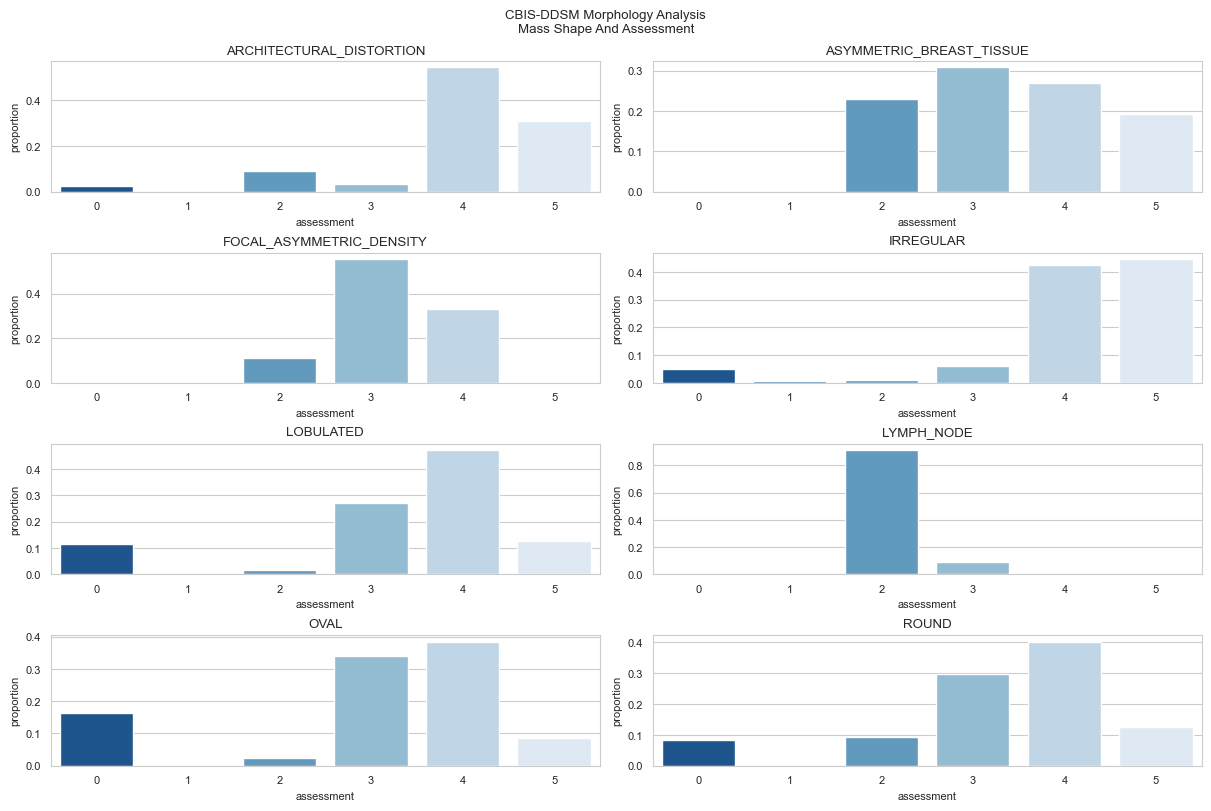

In [68]:
_ = cases.summarize_morphology_by_feature(morphology='mass_shape', by='assessment', figsize=(12,8))

Architectural distortion, irregular, oval, and round shapes tend to render the most concern.

In [69]:
cv = mass.stats.cramersv(a='mass_shape', b='assessment')
print(cv)



                            CramersV                            
                            Name | Cramer's V
                           Value | 0.3693905740902926
                          Pvalue | 8.3746514669523e-182
                           Alpha | 0.05
                        Strength | Large
                               A | mass_shape
                               B | assessment
                               N | 1694
                             Dof | 5
                         X2alpha | 0.05
                              X2 | 1155.7263860406229
                           X2dof | 95




Similarly, the relationship between mass shape and BI-RADS assessment is strong ($X^2$(5,n=1694)=1156 p<0.01, $V$=0.37).

#### Summary CBIS-DDSM Case Bivariate Analysis
This concludes the bivariate component of this exploratory data analysis. Let's summarize our observations thus far.

Our bivariate analysis was conducted in two parts:
1. Bivariate Target Variable Association Analysis
2. Bivariate Feature Association Analysis

The former examined the relationships between the features and the target variable, 'cancer' and the latter explored the relationships between feature pairs.

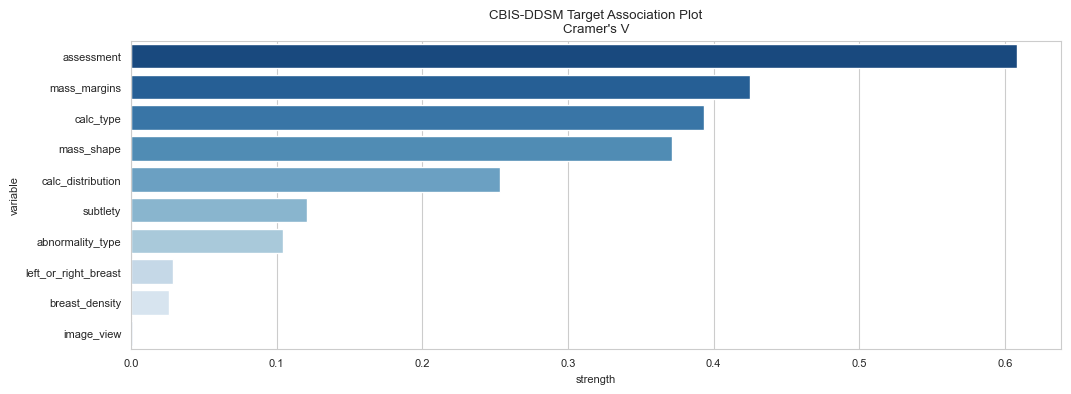

In [70]:
cases.plot_target_associations()

##### Bivariate Target Association Analysis Summary
The plot above depicts the Cramer's V associations between the independent variables and our target variable, 'cancer'. The main observations are as follows:
1. There was strong agreement between the BI-RADS assessments and the pathology ($\tau$=0.60, p<0.01); an expected finding as many of the BI-RADS assessments were likely updated as additional information was gathered by the physician {cite}`leeCuratedMammographyData2017`.
2. Mass margins had the strongest association with pathology ($X^2$(1,n=1694)=588.62 p<0.01, $V$=0.59). Of the 19 categories, the margins most associated with malignancy were:
   1. Obscured-Spiculated,
   2. Obscured-Ill-Defined,
   3. Circumscribed-Spiculated,
   4. Microlobulated-Spiculated, and
   5. Microlobulated-Ill-Defined-Spiculated
   Indeed, 100% of the above cases were malignant. 
3. Calcification type was also strongly associated with pathology ($X^2$(1,n=1872)=539.69 p<0.01, $V$=0.54). Punctate fine linear branching, punctate amorphous pleomorphic, and amorphous round and regular had malignancy rates of 100% in the dataset. Pleomorphic fine linear branching, fine linear branching, amorphous pleomorphic, and pleomorphic all had malignancy rates exceeding 50%.  
4. Mass shape had a large and significant effect on pathology in the dataset ($X^2$(1,n=1694)=440.92 p<0.01, $V$=0.51). Lobulated, round irregular, and irregular architectural distortion were associated with malignancy rates exceeding 80%. 
5. Calcification distribution had a moderate effect on pathology.  ($X^2$(1,n=1872)=198.56 p<0.01, $V$=0.33). Linear segmental, clustered linear, and linear calcification distributions were associated with malignancy rates above 50%.
6. Subtlety, abnormality type, breast, breast density, and image image_view were all weakly associated with pathology.

##### Bivariate Feature Association Analysis Summary
Cramer's V was used to measure the degree of association between the features. We observed several strong associations in both calcification and mass cases:
1. Calcification Cases: 
   1. There was a strong association (V=0.54) between calcification type and BI-RADS assessment. 
   2. Moderate associations were observed between:
      1. breast density and calcification type
      2. calcification type and distribution
      3. calcification type and subtlety
      4. calcification distribution and BI-RADS assessment
   3. The other features were weakly associated. 
2. Mass Cases:
   1. No strong associations were observed among the features in the mass dataset.
   2. Moderate associations were observed between:
      1. mass shape and BI-RADS assessment
      2. mass margins and BI-RADS assessment
   3. Other features were weakly associated.

Next, multivariate data analysis.

### Case Data Multivariate Analysis
The purpose of the multivariate analysis is to elucidate features of the data, beyond that which can be derived from the univariate, and bivariate analyses above. Our objectives; therefore, are to:
1. Identify the variables that most impact the diagnosis of cancer,
2. Estimate the importance of each independent variable in explaining the diagnosis.
3. Establish a model to predict a diagnosis, given the independent variables.

 Logistic Regression, Support Vector Machines, and Random Forests classifiers will be trained on the calcification and mass training data. The models will be evaluated using cross-validation, and the best algorithm will make predictions on the entire mass or calcification dataset.

In [71]:
FORCE_MODEL_FIT = False

#### Build Pipelines
Pipelines are built for each classifier.

In [72]:
pb = PipelineBuilder()
pb.set_jobs(6)
pb.set_standard_scaler()
pb.set_scorer('accuracy')

# Build Logistic Regression Pipeline
params_lr = [{'clf__penalty': ['l1', 'l2'],
		      'clf__C': [1.0, 0.5, 0.1],
		      'clf__solver': ['liblinear']}] 
clf = LogisticRegression(random_state=5)
pb.set_classifier(classifier=clf, params=params_lr)
pb.build_gridsearch_cv()
lr = pb.pipeline

# Build SVM Pipeline
clf = SVC(random_state=5)
params_svc = [{'clf__kernel': ['linear'], 
		       'clf__C': [1,2,3,4,5, 6, 7, 8, 9, 10]}]
pb.set_classifier(classifier=clf, params=params_svc)
pb.build_gridsearch_cv()
svc = pb.pipeline

# Build Random Forest Pipeline
clf = RandomForestClassifier(random_state=5)
param_range = [1,2,3,4,5]
params_rf = [{'clf__criterion': ['gini', 'entropy'],
		      'clf__min_samples_leaf': param_range,
		      'clf__max_depth': param_range,
		      'clf__min_samples_split': param_range[1:]}]  
pb.set_classifier(classifier=clf, params=params_rf)
pb.build_gridsearch_cv()
rf = pb.pipeline


#### Calcification Case Multivariate Analysis
##### Get Model Data

In [73]:
X_train, y_train, X_test, y_test = cases.get_calc_model_data()
X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)

##### Build and Execute Model Selection

In [74]:
BEST_CALC_MODEL_FP = os.path.abspath('model/eda/best_calc_pipeline.pkl')

In [75]:
# Build Model Selector
calc_ms = ModelSelector(filepath=BEST_CALC_MODEL_FP)
calc_ms.add_pipeline(pipeline=lr, name="Logistic Regression")
calc_ms.add_pipeline(pipeline=svc, name="Support Vector Classifier")
calc_ms.add_pipeline(pipeline=rf, name="Random Forest")

##### Prediction Results

In [76]:
calc_ms.run(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, force=FORCE_MODEL_FIT)
y_pred = calc_ms.predict(X=X)
calc_ms.score(y_true=y, y_pred=y_pred)

Best Model: Random Forest loaded from file.

		Accuracy of Random Forest: 0.75
			Classification Report
              precision    recall  f1-score   support

       False       0.73      0.96      0.83      1199
        True       0.83      0.37      0.51       673

    accuracy                           0.75      1872
   macro avg       0.78      0.66      0.67      1872
weighted avg       0.76      0.75      0.71      1872



Logistic Regression outperformed Support Vector Machine and Random Forest on the calcification dataset. It achieved an overall accuracy of 0.72. The precision (positive class), or the ability of the classifier not to classify false negatives was 0.58. The ability of the classifier to find all positive (malignant) cases was 0.79. The weighted harmonic mean of precision and recall was 0.67.

##### Calcification Variable Importance

The coefficients of the model indicate the importance of the feature to the prediction task. A positive value provides evidence that the instance being classified belongs to the positive or malignant class; whereas, a negative value provides evidence that the instance being classified belongs to the negative or benign class. Let's take a look.

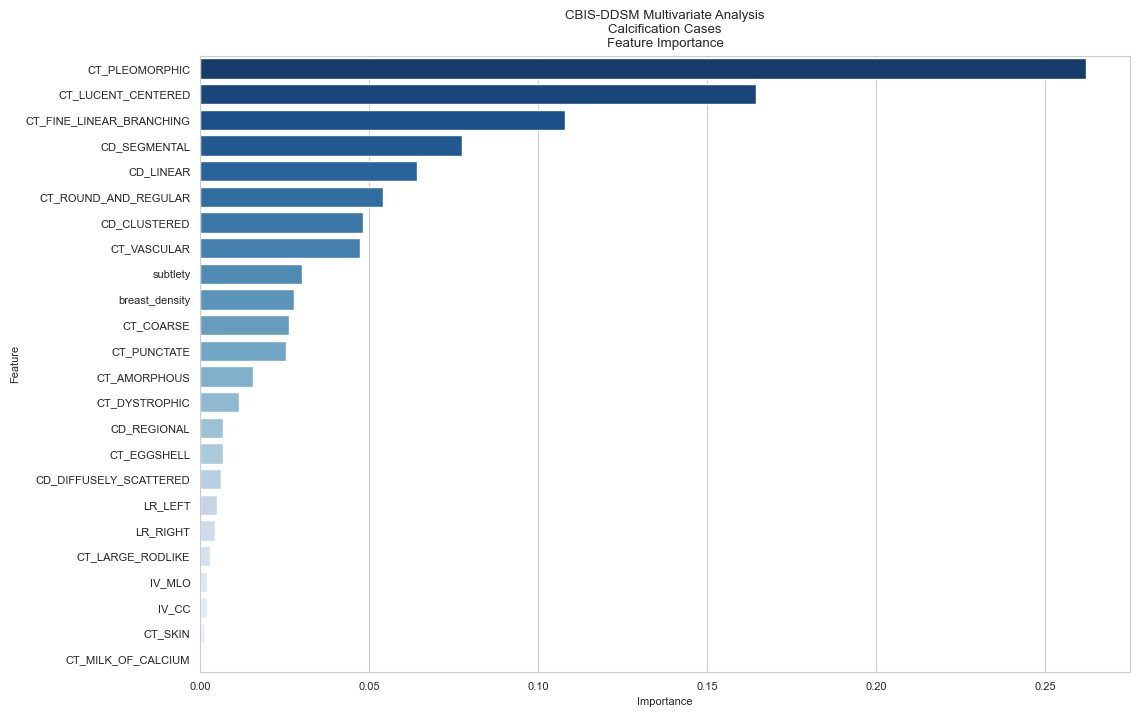

In [77]:
fig, ax = plt.subplots(figsize=(12,8))
title = f"CBIS-DDSM Multivariate Analysis\nCalcification Cases\nFeature Importance"
calc_ms.plot_feature_importance(title=title, ax=ax)

We see that calcification types have the greatest impact on the classification task. Further, the feature weight of evidence aligns with current literature on the differential of breast calcifications. For instance, pleomorphic, fine linear, and fine linear branching calcifications are understood to have a higher probability of malignancy. In contrast, lucent centered, and vascular calcifications are typically classified as BI-RADS 1 or 2.

#### Mass Case Multivariate Analysis
##### Get Model Data

In [78]:
X_train, y_train, X_test, y_test = cases.get_mass_model_data()
X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)

##### Build and Execute Model Selection

In [79]:
BEST_MASS_MODEL_FP = os.path.abspath('model/eda/best_mass_pipeline.pkl')

In [80]:
# Build Model Selector
mass_ms = ModelSelector(filepath=BEST_MASS_MODEL_FP)
mass_ms.add_pipeline(pipeline=lr, name="Logistic Regression")
mass_ms.add_pipeline(pipeline=svc, name="Support Vector Classifier")
mass_ms.add_pipeline(pipeline=rf, name="Random Forest")

##### Prediction Results

In [81]:
mass_ms.run(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, force=FORCE_MODEL_FIT)
y_pred = mass_ms.predict(X=X)
mass_ms.score(y_true=y, y_pred=y_pred)

Best Model: Random Forest loaded from file.

		Accuracy of Random Forest: 0.81
			Classification Report
              precision    recall  f1-score   support

       False       0.85      0.79      0.82       910
        True       0.77      0.84      0.81       784

    accuracy                           0.81      1694
   macro avg       0.81      0.81      0.81      1694
weighted avg       0.82      0.81      0.81      1694



Random Forest performed the best on the mass data. It achieved an accuracy of 0.80. Precision and recall were 0.77, and 0.78 respectively.

##### Mass Variable Importance

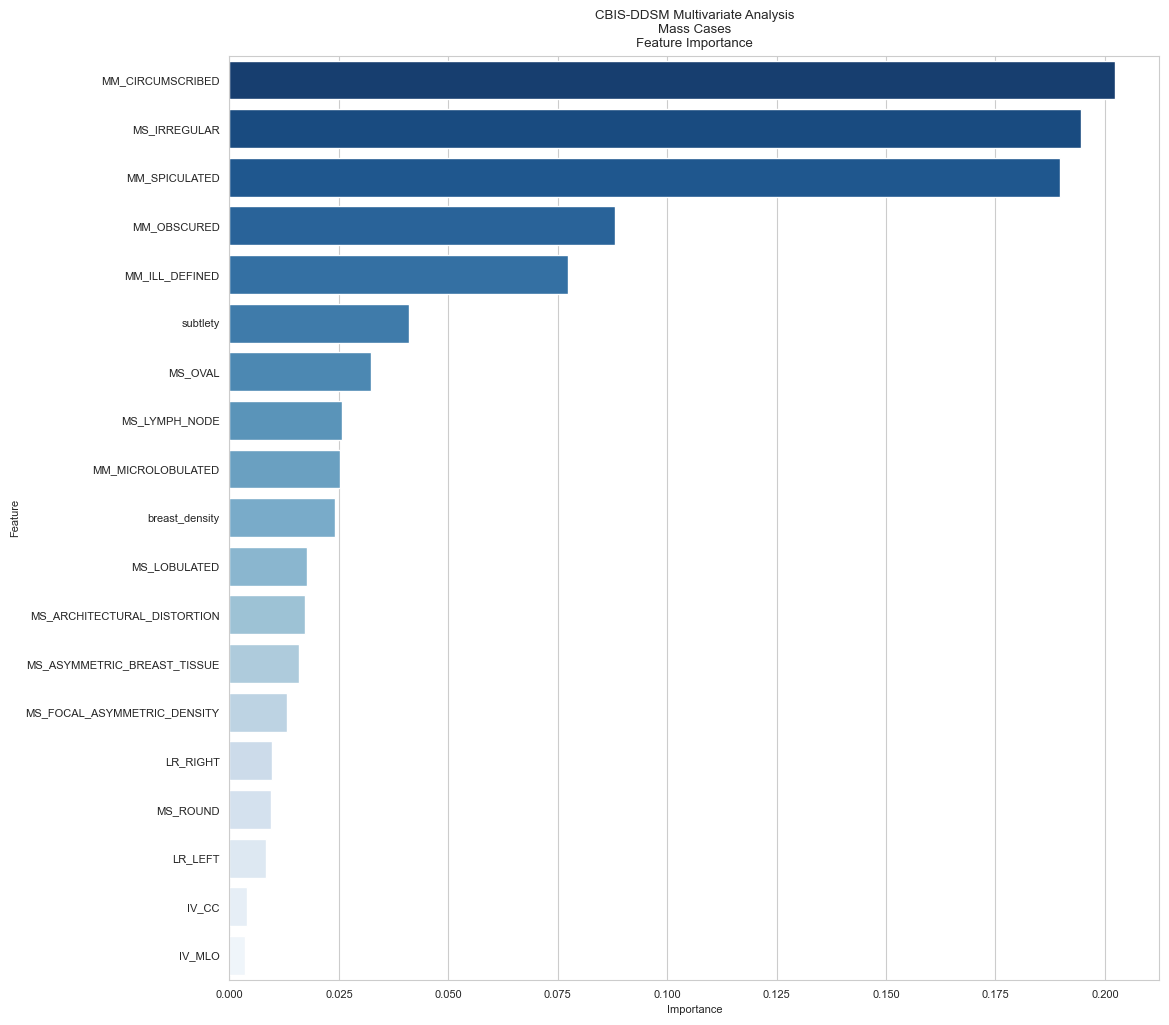

In [82]:
fig, ax = plt.subplots(figsize=(12,12))
title = f"CBIS-DDSM Multivariate Analysis\nMass Cases\nFeature Importance"
mass_ms.plot_feature_importance(title=title, ax=ax)

Random Forest performed best of the three models on the mass data. Unlike Logistic Regression, Random Forest has no coefficients to provide weight of evidence for (or against) the positive class. Rather, Random Forest computes a feature's non-negative importance according to its ability to increase the purity of the leaves in each tree. Pure leaves have data points from only one class. Therefore, we would expect the most important features to be strongly associated with a benign or malignant finding. Let's examine a few of the top features.

Spiculated masses are characterized by lines of varying length and thickness radiating from the margins of the mass and are considered very suspicious for malignancy {cite}`braggOncologicImaging2002`. Circumscribed masses have margins with a sharp demarcation between the lesion and surrounding tissue {cite}`princeMultipleCircumscribedMasses2018`. Most circumscribed masses are benign. Irregular masses, those having margins that are neither round nor oval, tend to imply a more suspicious finding {cite}`princeMultipleIrregularMasses2018`.  An obscured mass is a mass with greater than 25% of its margin hidden by surrounding fibro glandular tissue on the mammography; hence, it cannot be fully assessed. {cite}`elezabyObscuredMass2018`. In practice; however, this term is commonly used when the portion of the margin that is visualized is circumscribed, implying a lower likelihood of malignancy.

## DICOM Metadata EDA
Let's summarize the available DICOM metadata.

In [83]:
ds = DicomExplorer(filepath=DICOM_FP)

In [84]:
ds.info

Column  DataType  Complete  Null  Completeness  \
0                          uid    object      3565     0          1.00   
1                   series_uid    object      3565     0          1.00   
2                     filepath    object      3565     0          1.00   
3   photometric_interpretation  category      3565     0          1.00   
4            samples_per_pixel     int32      3565     0          1.00   
5                       height     int64      3565     0          1.00   
6                        width     int64      3565     0          1.00   
7                         size     int64      3565     0          1.00   
8                 aspect_ratio   float64      3565     0          1.00   
9                    bit_depth  category      3565     0          1.00   
10             min_pixel_value     int64      3565     0          1.00   
11             max_pixel_value     int64      3565     0          1.00   
12          range_pixel_values     int64      3565     0          1.00   
13            mean_pixel_value   float64      3565     0          1.00   
14          median_pixel_value     int64      3565     0          1.00   
15             std_pixel_value   float64      3565     0          1.00   
16          series_description    object      3565     0          1.00   
17                  patient_id    object      3565     0          1.00   
18              breast_density     int64      3565     0          1.00   
19        left_or_right_breast  category      3565     0          1.00   
20                  image_view  category      3565     0          1.00   
21              abnormality_id     int64      3565     0          1.00   
22            abnormality_type    object      3565     0          1.00   
23                   calc_type    object      3565     0          1.00   
24           calc_distribution    object      3565     0          1.00   
25                  assessment     int64      3565     0          1.00   
26                   pathology    object      3565     0          1.00   
27                    subtlety     int64      3565     0          1.00   
28                     fileset    object      3565     0          1.00   
29                  mass_shape    object      3565     0          1.00   
30                mass_margins    object      3565     0          1.00   
31                     case_id    object      3565     0          1.00   
32                      cancer      bool      3565     0          1.00   

    Unique  Duplicate  Uniqueness    Size  
0     3100        465        0.87  331545  
1     3100        465        0.87  430492  
2     3100        465        0.87  606875  
3        1       3564        0.00    3633  
4        1       3564        0.00   14260  
5      349       3216        0.10   28520  
6      425       3140        0.12   28520  
7     2591        974        0.73   28520  
8     2595        970        0.73   28520  
9        1       3564        0.00    3624  
10       1       3564        0.00   28520  
11     233       3332        0.07   28520  
12     233       3332        0.07   28520  
13    3031        534        0.85   28520  
14    1086       2479        0.30   28520  
15    3031        534        0.85   28520  
16       1       3564        0.00  278070  
17    1566       1999        0.44  228160  
18       4       3561        0.00   28520  
19       2       3563        0.00    3796  
20       2       3563        0.00    3684  
21       7       3558        0.00   28520  
22       2       3563        0.00  234313  
23      44       3521        0.01  253086  
24      10       3555        0.00  244027  
25       6       3559        0.00   28520  
26       3       3562        0.00  240560  
27       5       3560        0.00   28520  
28       2       3563        0.00  220326  
29      21       3544        0.01  245884  
30      20       3545        0.01  249740  
31    3565          0        1.00  322810  
32       2       3563        0.00    3565

The DICOM metadata contains 30 variables which can be categorized as:
- Series metadata: Series UID and description
- Case metadata: Patient ID, side, image image_view, case id, abnormality and morphology information
- Image metadata: Image height, width, size, aspect ratio, bit depth, pixel ranges, and image quality

Series and case metadata are cross-referenced from the series and case data examined above. Our focus here will be the following *image* metadata:
- photometric_interpretation, samples_per_pixel, and bit depth
- height, width, size, and aspect_ratio
- smallest, largest, image pixel values and ranges

### Photometric Interpretation, Samples per Pixel and Bit Depth

All images are of the MONOCHROME2 representation.
All images have 1 sample(s) per pixel.


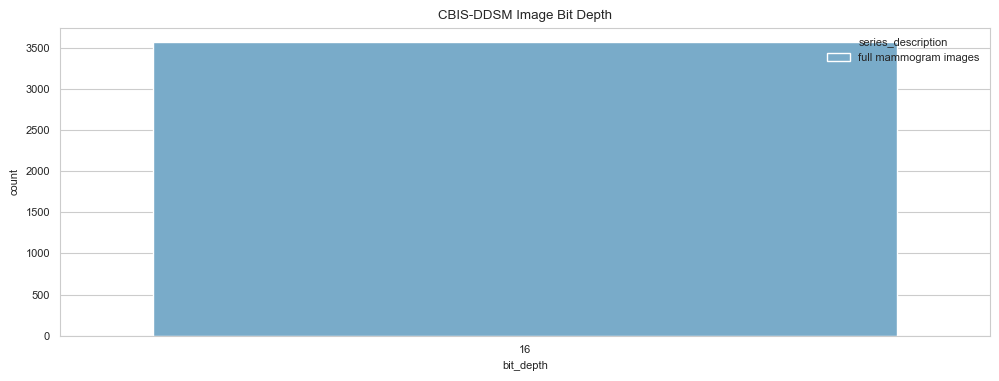

In [85]:
df = ds.as_df()
print(f"All images are of the {df['photometric_interpretation'].unique()[0]} representation.")
print(f"All images have {df['samples_per_pixel'].unique()[0]} sample(s) per pixel.")
fig, ax = plt.subplots(figsize=(12,4))
ds.plot.countplot(x='bit_depth', ax=ax, hue='series_description', title ="CBIS-DDSM Image Bit Depth", plot_counts=False)


The full mammogram images have a bit depth of 16. The ROI masks appear to be evenly distributed between 8 and 16 bit_depth, and cropped images have a depth of 16 bit_depth.

### DICOM Image Height, Width, Size, and Aspect Ratio
Here, we examine the properties for the full mammography images.

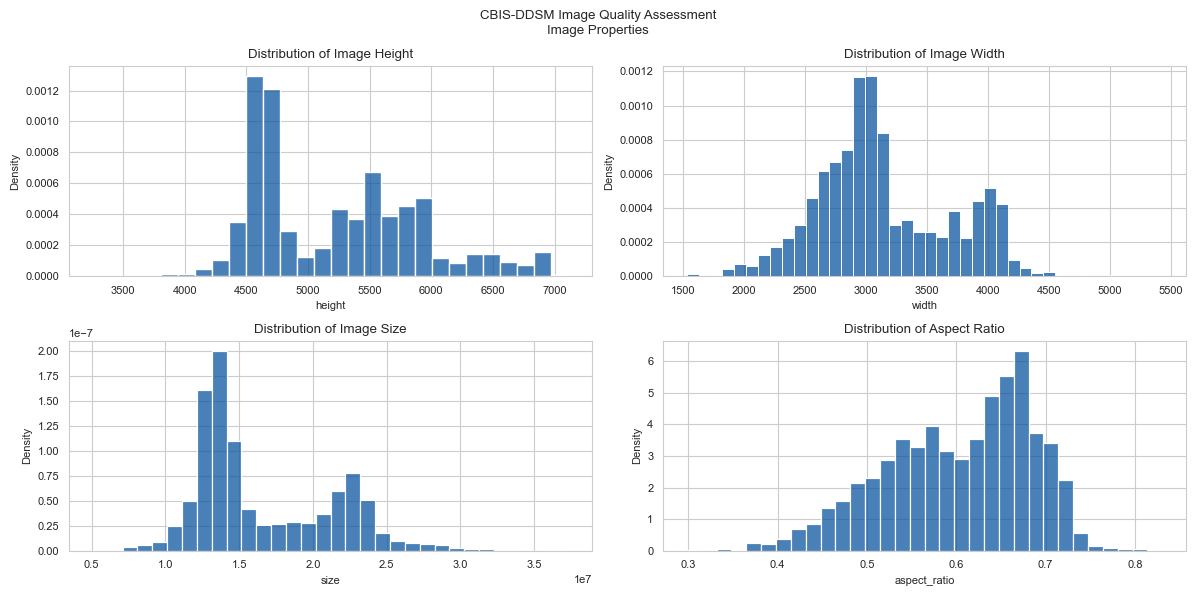

In [86]:
df = ds.as_df()
df_full = df.loc[df['series_description'] == 'full mammogram images']

fig, axes = plt.subplots(figsize=(12,6), nrows=2, ncols=2)
ds.plot.histogram(data=df_full, x='height', ax=axes[0,0], title="Distribution of Image Height")
ds.plot.histogram(data=df_full, x='width', ax=axes[0,1], title="Distribution of Image Width")
ds.plot.histogram(data=df_full, x='size', ax=axes[1,0], title="Distribution of Image Size")
ds.plot.histogram(data=df_full, x='aspect_ratio', ax=axes[1,1], title="Distribution of Aspect Ratio")
_ = fig.suptitle("CBIS-DDSM Image Quality Assessment\nImage Properties")
plt.tight_layout()

The plot above reveals the distribution of image height, width, size, and aspect ratio. All full mammogram images will be transformed to a common height and width.

### DICOM Image Pixel Values
Again, our interest is the full mammography images.

In [87]:
df_full_desc = pd.DataFrame()
df_full_desc['min_pixel_value'] = df_full['min_pixel_value'].describe().T
df_full_desc['max_pixel_value'] = df_full['max_pixel_value'].describe().T
df_full_desc['range_pixel_values'] = df_full['range_pixel_values'].describe().T
df_full_desc.T

count      mean      std       min       25%       50%  \
min_pixel_value    3,565.00      0.00     0.00      0.00      0.00      0.00   
max_pixel_value    3,565.00 64,926.25 1,946.78 40,968.00 65,535.00 65,535.00   
range_pixel_values 3,565.00 64,926.25 1,946.78 40,968.00 65,535.00 65,535.00   

                         75%       max  
min_pixel_value         0.00      0.00  
max_pixel_value    65,535.00 65,535.00  
range_pixel_values 65,535.00 65,535.00

Full mammogram image pixels range from zero to 65,535, which comports with a depth of 16 bit_depth.

## DICOM Image EDA
The purpose of this section is three fold:
1. Inspect image quality for noise, annotations, artifacts, and labeling that may negatively affect the classification task.
2. Visually compare cases, abnormality types, subtlety and BI-RADS assessment.
3. Examine interclass dissimilarity and intraclass similarity by abnormality type and morphology.

As such, this section is organized as follows:
1.  **DICOM Image Quality Analysis**: Visual image quality assessment
2.  **DICOM Calcification Case Analysis**: Visual analysis of various calcification types and distributions by BI-RADS Assessment.   
3.  **DICOM Mass Case Analysis**: Visual analysis of various mass sizes and margins by BI-RADS Assessment.

### DICOM Image Quality Analysis
Let's sample the image data.

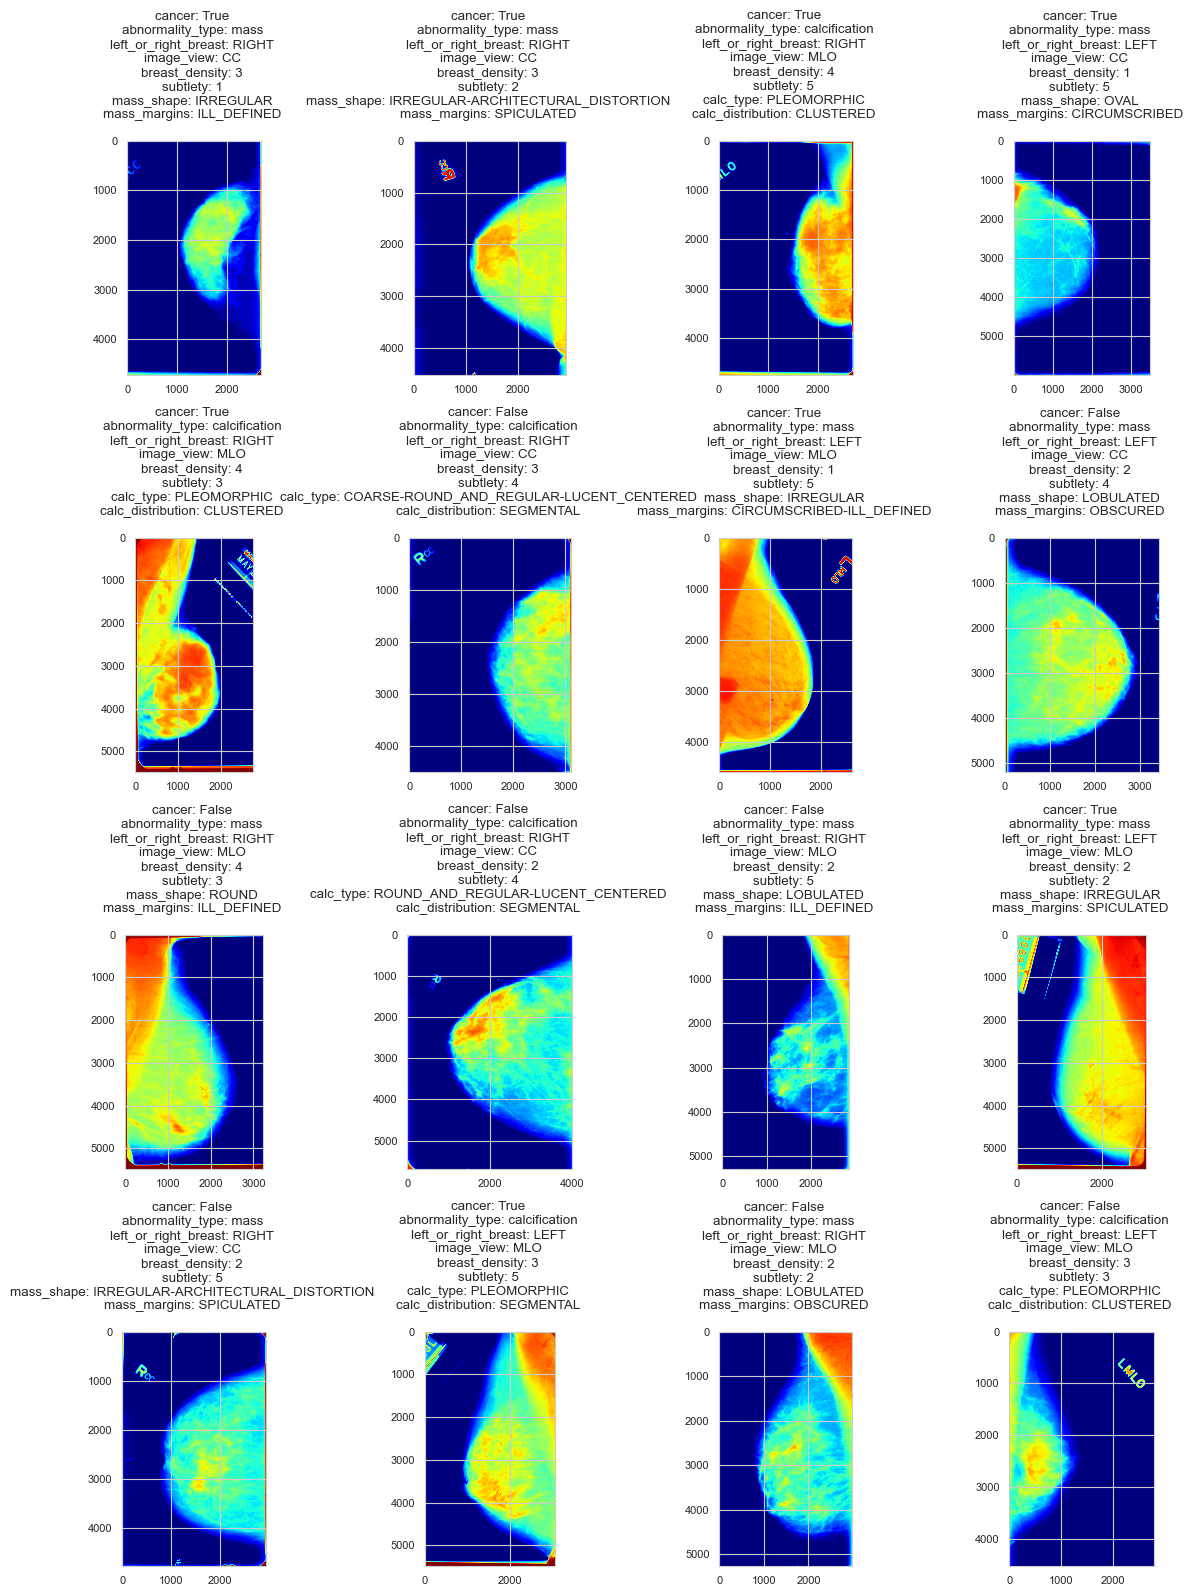

In [88]:
ds.plot_images(random_state=5, nrows=4, ncols=4, n=16)

Thirteen out of 16 images (81%) have artifacts and labeling which may affect the modeling and classification of the cases. Image data preprocessing will remove these artifacts from the images.

### DICOM Calcification Case Analysis
In this section, we sample calcification types and distributions vis-a-vis BI-RADS assessment, subtlety, and diagnosis.

#### DICOM Calcification Cases - Benign
Here, we examine BI-RADS 1 and 2 calcification cases.

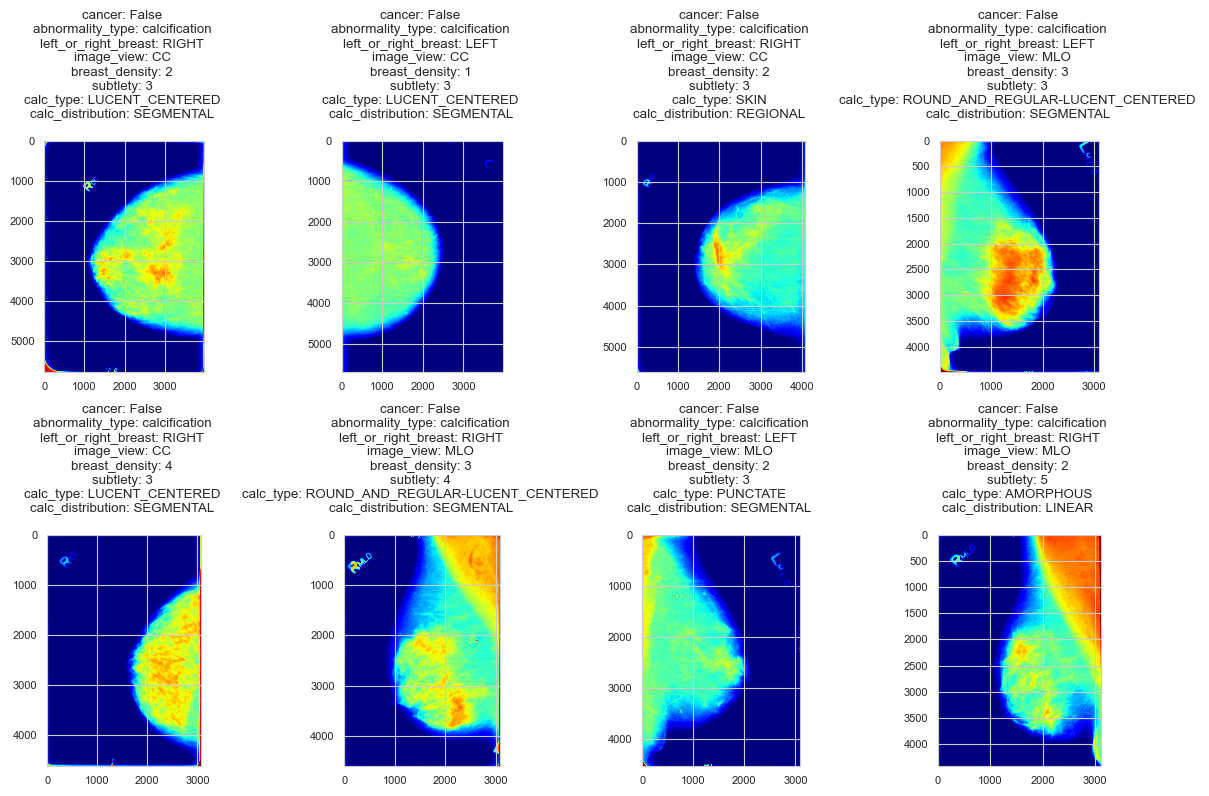

In [89]:
condition = lambda df: ((df['abnormality_type'] == 'calcification') & (df['assessment'].isin([1,2])))
ds.plot_images(condition=condition, n=8, nrows=2, ncols=4)

#### DICOM Calcification Cases - Probably Benign
The following calcification cases are assessed as BI-RADS 3. A finding in this category has a 2% or lower chance of malignancy.

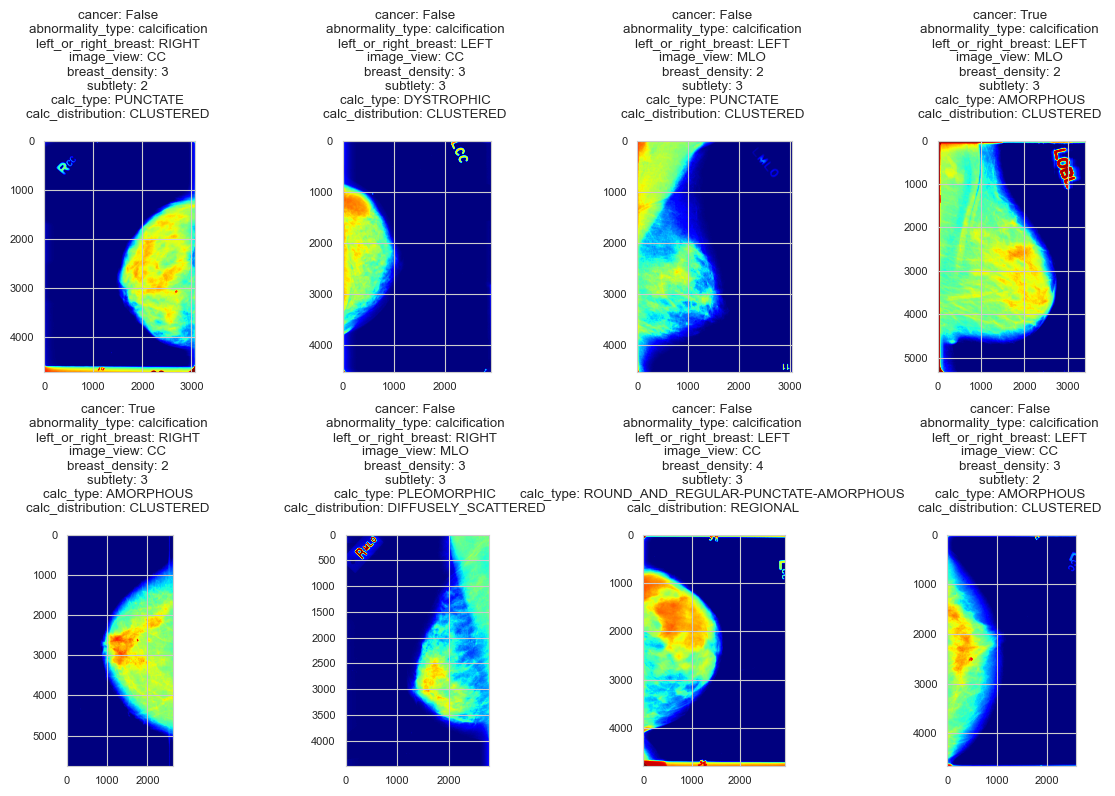

In [90]:
condition = lambda df: ((df['abnormality_type'] == 'calcification') & (df['assessment'] == 3))
ds.plot_images(condition=condition, n=8, nrows=2, ncols=4)

#### DICOM Calcification Cases - Suspicious
The following calcification cases are assessed as BI-RADS 4, a suspicious abnormality with a probability of malignancy ranging from 2%-10%, 10%-50%, and 50%-95% for subcategories 4A, 4B, and 4C respectively.

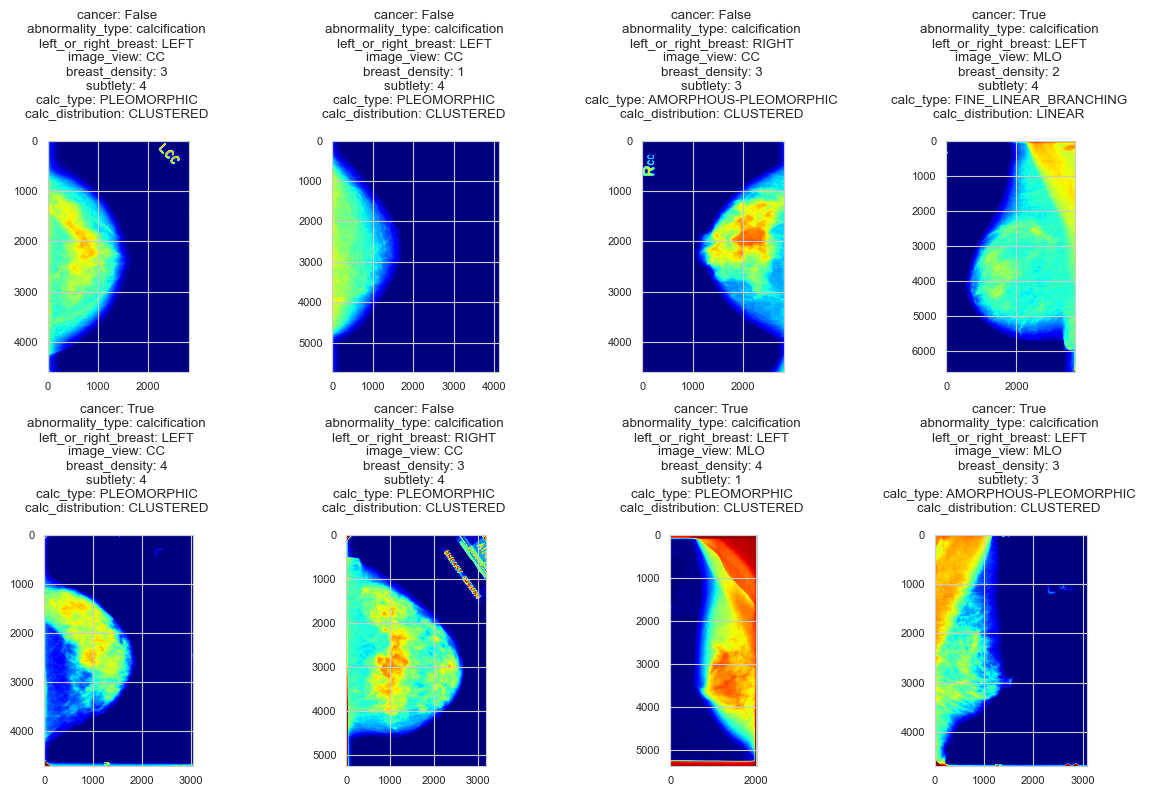

In [91]:
condition = lambda df: ((df['abnormality_type'] == 'calcification') & (df['assessment'] == 4))
ds.plot_images(condition=condition, n=8, nrows=2, ncols=4)

#### DICOM Calcification Cases - Highly Suspicious
The following BI-RADS 5 calcification cases have at least a 95% chance of malignancy.

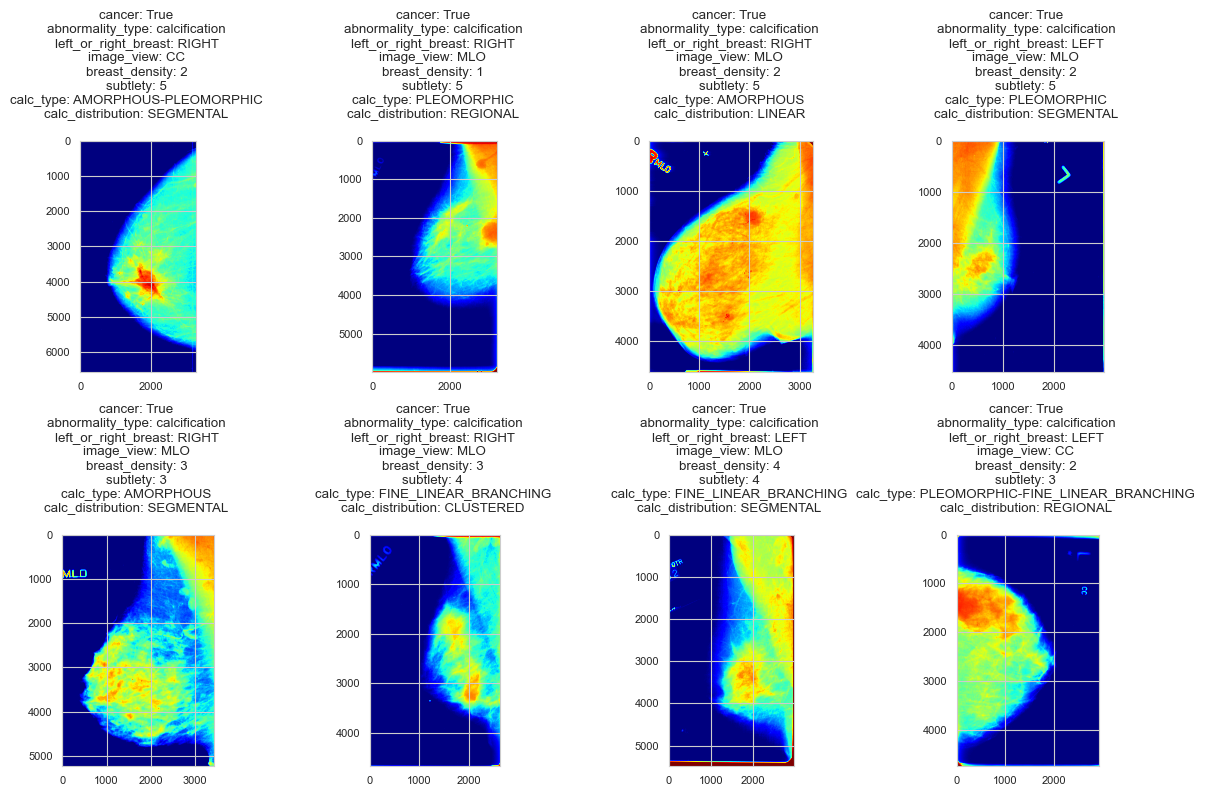

In [92]:
condition = lambda df: ((df['abnormality_type'] == 'calcification') & (df['assessment'] == 5))
ds.plot_images(condition=condition, n=8, nrows=2, ncols=4)

### DICOM Mass Case Analysis

#### DICOM Mass Cases - Benign
Here, we examine BI-RADS 1 and 2 mass cases.

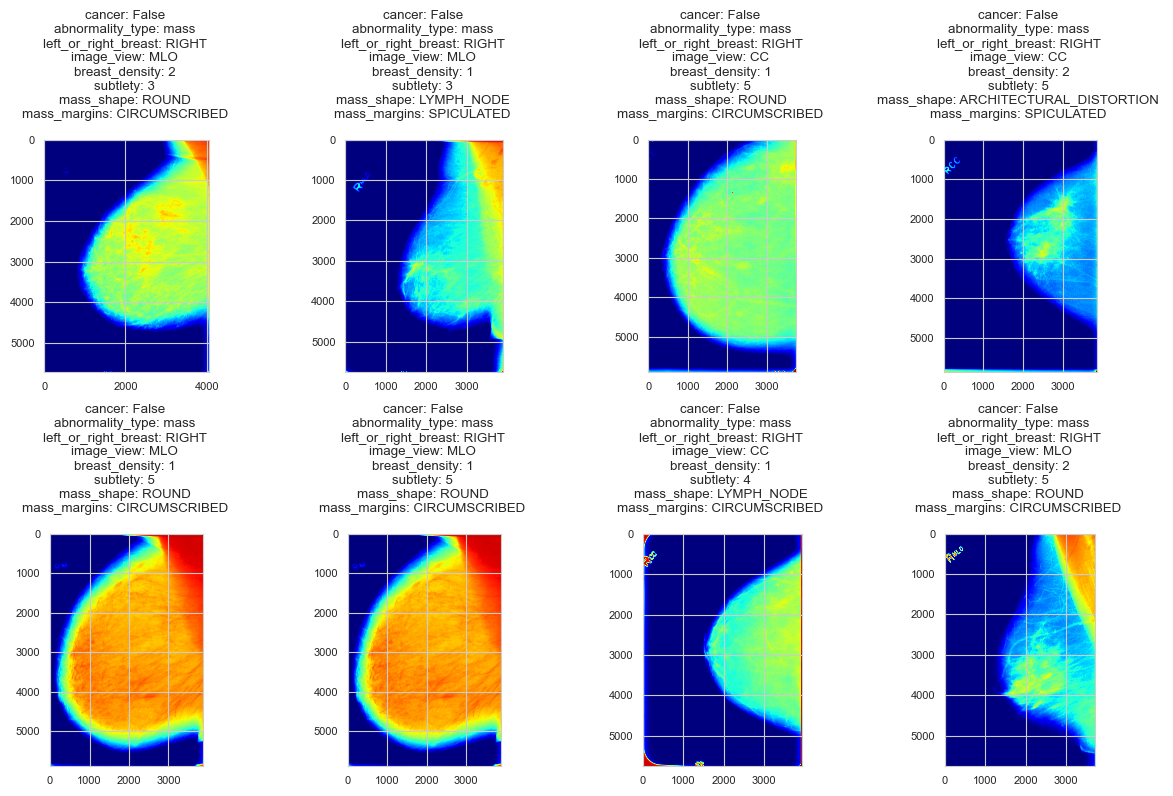

In [93]:
condition = lambda df: ((df['abnormality_type'] == 'mass') & (df['assessment'].isin([1,2])))
ds.plot_images(condition=condition, n=8, nrows=2, ncols=4)

#### DICOM Mass Cases - Probably Benign
The following mass cases are assessed as BI-RADS 3. A finding in this category has a 2% or lower chance of malignancy.

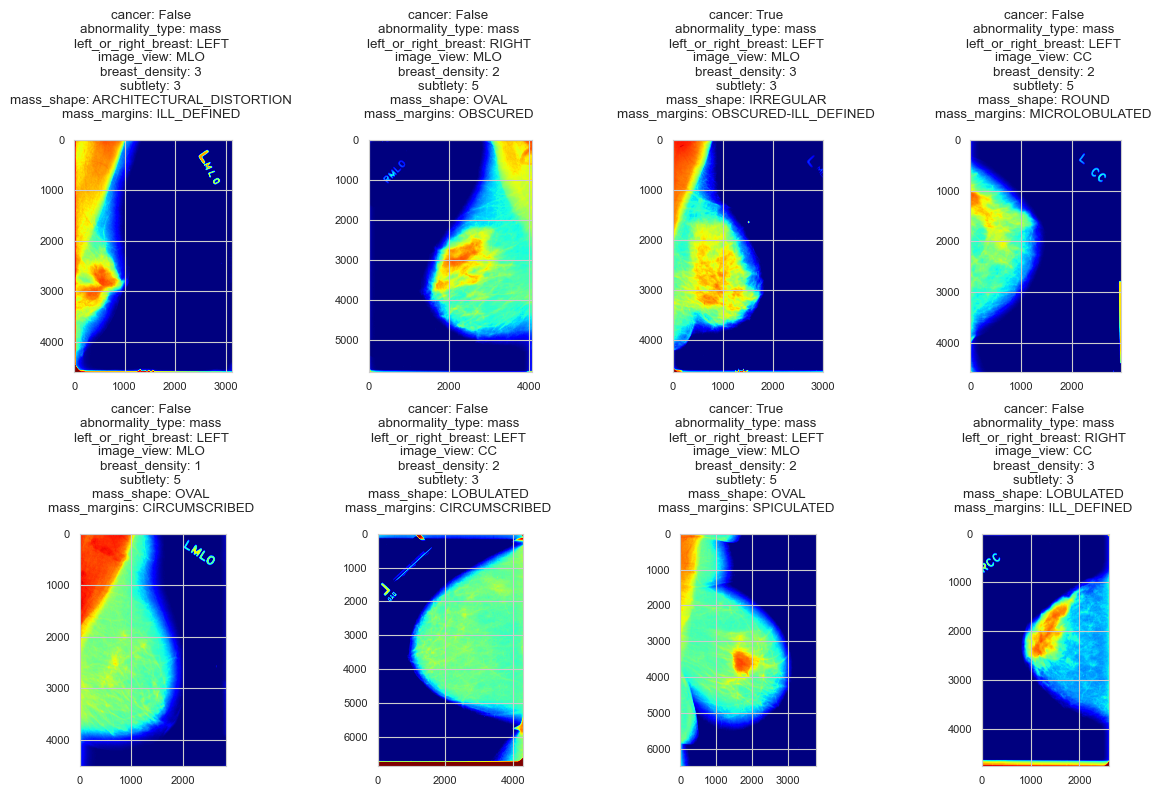

In [94]:
condition = lambda df: ((df['abnormality_type'] == 'mass') & (df['assessment'] == 3))
ds.plot_images(condition=condition, n=8, nrows=2, ncols=4)

#### DICOM Mass Cases - Suspicious
The following mass cases are assessed as BI-RADS 4, a suspicious abnormality with a probability of malignancy ranging from 2%-10%, 10%-50%, and 50%-95% for subcategories 4A, 4B, and 4C respectively.

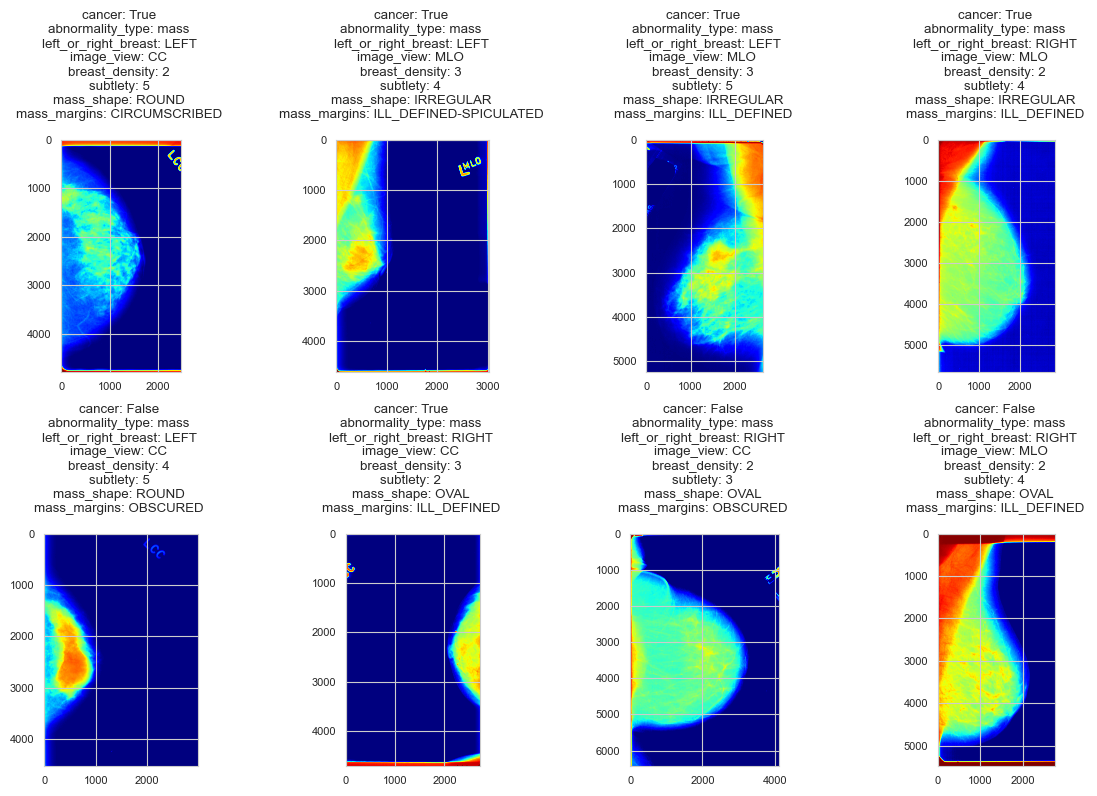

In [95]:
condition = lambda df: ((df['abnormality_type'] == 'mass') & (df['assessment'] == 4))
ds.plot_images(condition=condition, n=8, nrows=2, ncols=4)

#### DICOM Mass Cases - Highly Suspicious
The following BI-RADS 5 mass cases have at least a 95% chance of malignancy.

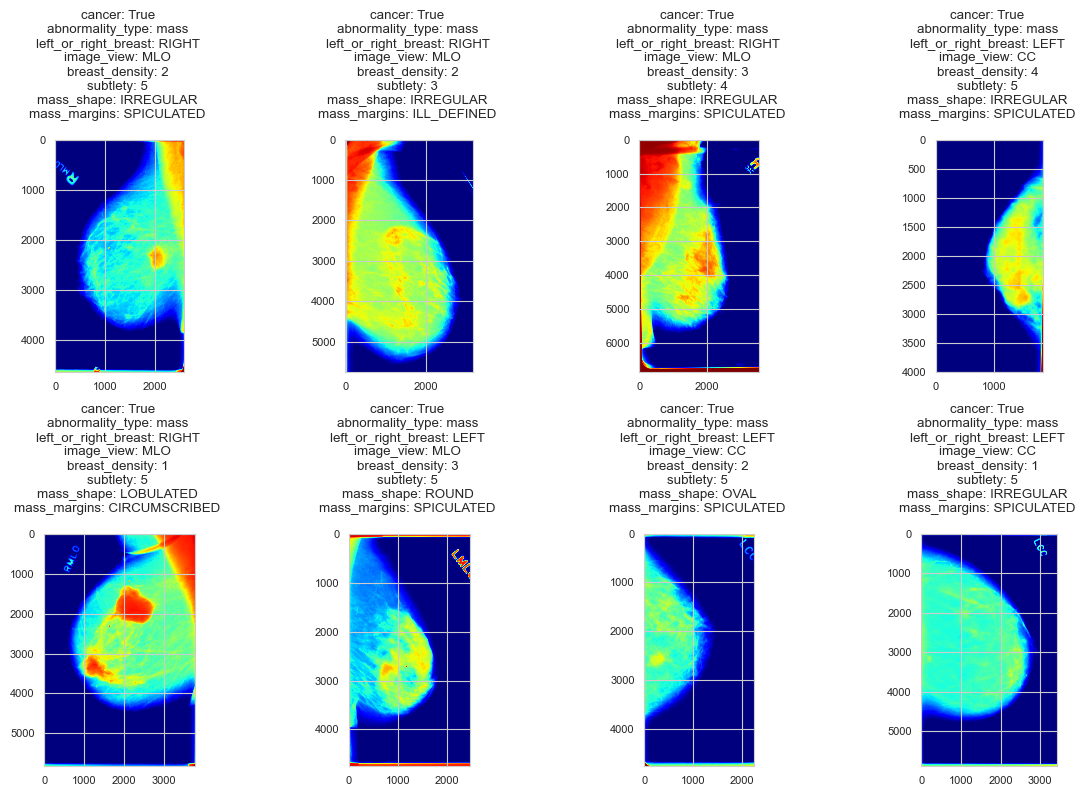

In [96]:
condition = lambda df: ((df['abnormality_type'] == 'mass') & (df['assessment'] == 5))
ds.plot_images(condition=condition, n=8, nrows=2, ncols=4)